# Import

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

import ddpm_Time_Series_copy
import numpy as np
import pandas as pd
import torch

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset

#===========================

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Visualisation of the datasets 

In [2]:
# print the organisation of the datasets folder until the files using os.walk
import os

for root, dirs, files in os.walk('datasets'):
    level = root.replace('datasets', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)

        
#===========================

In [3]:
train_data = np.load(f'../datasets/UTS/WSD/1/train.npy')
print(train_data.shape)
print(train_data[0])
print(type(train_data))

(18235,)
50.0833320618
<class 'numpy.ndarray'>


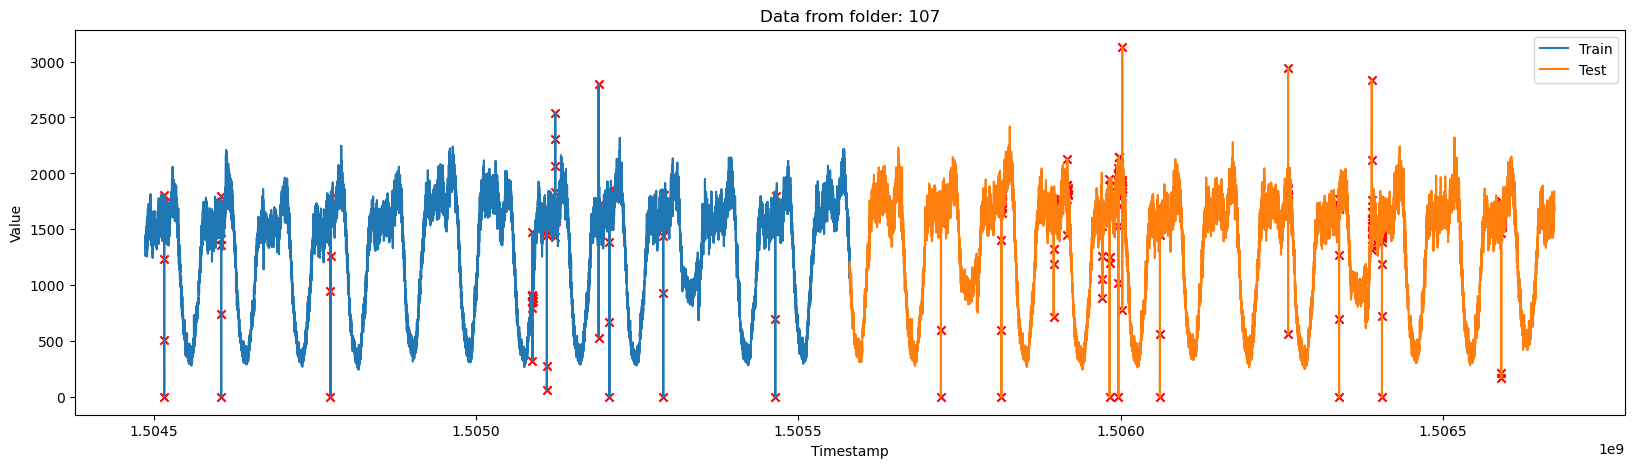

In [4]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

# Select 5 random folders
folders = os.listdir('../datasets/UTS/WSD')
folders = random.sample(folders, 5)
folders = [107]
# Plot the train.npy and test.npy files in each selected folder
for folder in folders:
    train_data = np.load(f'../datasets/UTS/WSD/{folder}/train.npy')
    print
    test_data = np.load(f'../datasets/UTS/WSD/{folder}/test.npy')
    
    train_timestamp = np.load(f'../datasets/UTS/WSD/{folder}/train_timestamp.npy')
    test_timestamp = np.load(f'../datasets/UTS/WSD/{folder}/test_timestamp.npy')
    
    # Plot the train and test data in one figure using different colors
    plt.figure(figsize=(20, 5))
    plt.plot(train_timestamp, train_data, label='Train')
    plt.plot(test_timestamp, test_data, label='Test')
    
    # Plot anomalies as points in red
    train_label = np.load(f'../datasets/UTS/WSD/{folder}/train_label.npy')
    test_label = np.load(f'../datasets/UTS/WSD/{folder}/test_label.npy')
    
    for i, label in enumerate(train_label):
        if label:
            plt.scatter(train_timestamp[i], train_data[i], color='red', marker='x', label='Anomaly' if i == 0 else "")
    for i, label in enumerate(test_label):
        if label:
            plt.scatter(test_timestamp[i], test_data[i], color='red', marker='x', label='Anomaly' if i == 0 else "")
            
    plt.title(f"Data from folder: {folder}")
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    



In [5]:
    
#===========================
# compute the mean and std of the train data in the folder datasets/UTS/WSD/1
train_data = np.load('../datasets/UTS/WSD/1/train.npy')
mean = np.mean(train_data)
std = np.std(train_data)
print(mean, std)

#===========================
# Is train_data a 1D array or a 2D array?
print(train_data.ndim)

# In the variable data save = (train_data as a Tensor, train timestamp as a Tensor)
data = (torch.tensor(train_data), torch.tensor(train_timestamp))
print(data[0].shape, data[1].shape)
print(data)

36.78820118134014 11.438011591627744
1
torch.Size([18235]) torch.Size([18213])
(tensor([50.0833, 48.6667, 46.0833,  ..., 22.5000, 23.3000, 23.9000],
       dtype=torch.float64), tensor([1.5045e+09, 1.5045e+09, 1.5045e+09,  ..., 1.5056e+09, 1.5056e+09,
        1.5056e+09], dtype=torch.float64))


In [6]:
from torch.utils.data import DataLoader
dataloader = DataLoader( data , batch_size=32, shuffle=False, drop_last=True)

print(len(dataloader))
print(type(dataloader))
print(dataloader.batch_size)

for step, batch in enumerate(dataloader):
    print(step, batch[0].shape)

0
<class 'torch.utils.data.dataloader.DataLoader'>
32


# Model debugging

In [1]:
import ddpm_Time_Series_copy
#!python ddpm_Time_Series_point_wize.py --data_path ../datasets/UTS/WSD/1 --output_dir output --num_epochs 1 --train_batch_size 512 --eval_batch_size 512 

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Visualisation of adding noise

In [2]:

import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset
from ddpm_Time_Series_copy import TCN 
from ddpm_Time_Series_copy import NoiseScheduler


import torch
from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

from positional_embeddings import PositionalEmbedding



In [9]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = {
  "data_path": "../datasets/UTS/WSD/107",
  "output_dir": "output",
  "train_batch_size": 28,
  "eval_batch_size": 28,
  "num_epochs": 1,
  
  "learning_rate": 0.0001,
  "num_timesteps": 1001,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.02,
  "save_model_epochs": 1
}


# Create Config object
config = Config(config)



/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model...


Epoch 0:   0%|          | 0/293 [00:00<?, ?it/s]

0
tensor([[-0.0782, -0.0980, -0.0109,  ..., -0.9671, -1.0067, -0.9433],
        [-0.0980, -0.0109,  0.0108,  ..., -1.0067, -0.9433, -0.9374],
        [-0.0109,  0.0108,  0.0900,  ..., -0.9433, -0.9374, -0.9770],
        ...,
        [ 0.1336,  0.4087,  0.0029,  ..., -0.6702, -0.5811, -0.6543],
        [ 0.4087,  0.0029,  0.1375,  ..., -0.5811, -0.6543, -0.5395],
        [ 0.0029,  0.1375,  0.0564,  ..., -0.6543, -0.5395, -0.5771]])
tensor([1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09], dtype=torch.float64)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0.

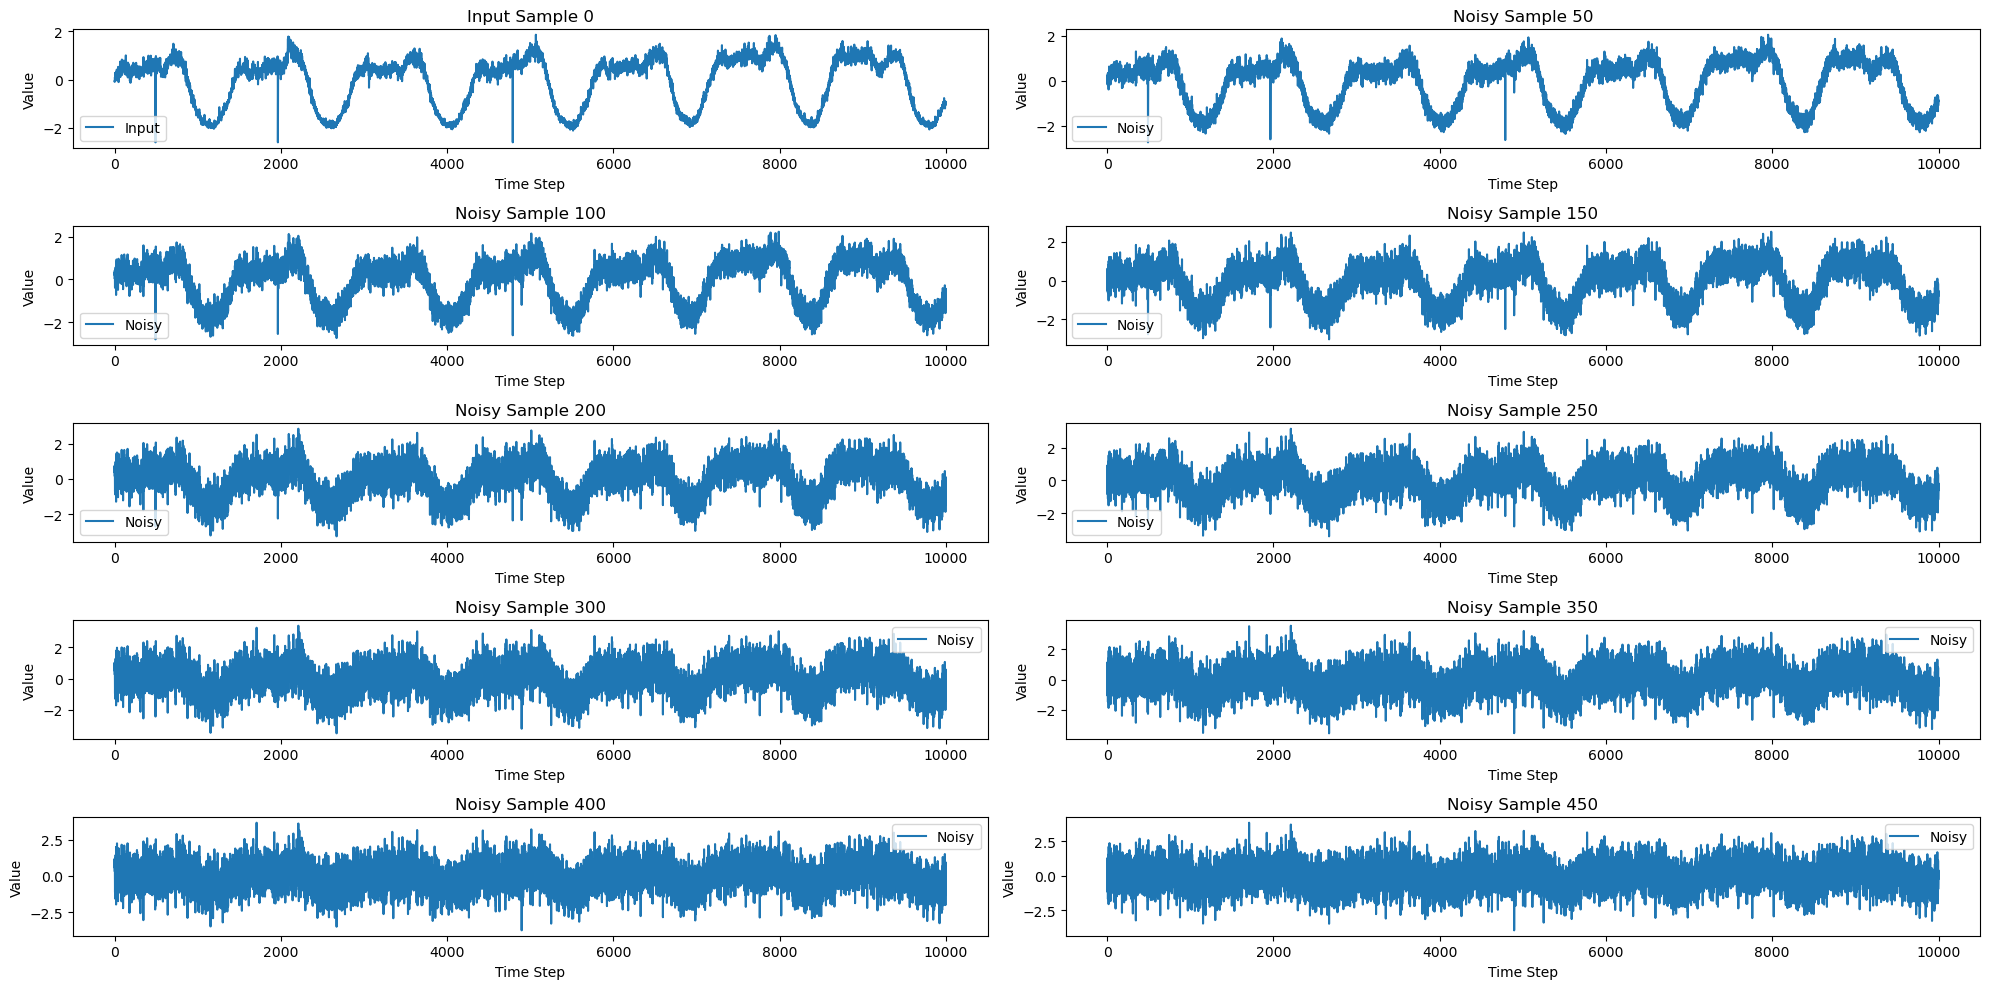

Epoch 0:   0%|          | 0/293 [00:00<?, ?it/s]

Showing input and noisy data


In [10]:

input_size = 2  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,normalize=True)

# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Initialize TCN model
model = TCN(
    input_size=input_size,  # +1 for time information
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
)
#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        print(step)
        print(batch)
        print(timestamps)
        print(labels)
        
        noise = torch.randn_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])

        # Plotting noisy versions of the first sample
        for i in range(9):
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*50]))
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*50}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        print("Showing input and noisy data")
        
        break
    
    progress_bar.close()
    
#Why it doesn't plot anything ?



Explanation:
Constructor: Initializes the parameters similar to the original NoiseScheduler class.
generate_simplex_noise_like Method: Generates a tensor of Simplex noise with the same shape as the input tensor.
step Method: Uses Simplex noise instead of Gaussian noise for the variance term.
add_noise Method: Unchanged, it adds noise to the input data.
This new class SimplexNoiseScheduler will generate and use Simplex noise for the noise addition and sampling steps. The noise generation is done using the noise library's pnoise3 function, which generates 3D Perlin noise (Simplex noise). Adjust the noise generation as needed for your specific application and noise characteristics.

In [15]:
import torch
import torch.nn.functional as F
from opensimplex import OpenSimplex

class SimplexNoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"):

        self.num_timesteps = num_timesteps
        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.)

        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

        # required for reconstruct_x0
        self.sqrt_inv_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(
            1 / self.alphas_cumprod - 1)

        # required for q_posterior
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)
        
        self.simplex = OpenSimplex(seed=42)

    def reconstruct_x0(self, x_t, t, noise):
        s1 = self.sqrt_inv_alphas_cumprod[t]
        s2 = self.sqrt_inv_alphas_cumprod_minus_one[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        return s1 * x_t - s2 * noise

    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        mu = s1 * x_0 + s2 * x_t
        return mu

    def get_variance(self, t):
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    def step(self, model_output, timestep, sample):
        t = timestep
        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = self.generate_simplex_noise_like(model_output)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]

        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)

        return s1 * x_start + s2 * x_noise

    def generate_simplex_noise_like(self, tensor):
        shape = tensor.shape
        simplex_noise = torch.zeros_like(tensor)
        for i in range(shape[0]):
            for j in range(shape[1]):
                simplex_noise[i, j] = self.simplex.noise2(i, j)
        return simplex_noise

    def __len__(self):
        return self.num_timesteps


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model...


Epoch 0:   0%|          | 0/293 [00:00<?, ?it/s]

0
tensor([[-0.0782, -0.0980, -0.0109,  ..., -0.9671, -1.0067, -0.9433],
        [-0.0980, -0.0109,  0.0108,  ..., -1.0067, -0.9433, -0.9374],
        [-0.0109,  0.0108,  0.0900,  ..., -0.9433, -0.9374, -0.9770],
        ...,
        [ 0.1336,  0.4087,  0.0029,  ..., -0.6702, -0.5811, -0.6543],
        [ 0.4087,  0.0029,  0.1375,  ..., -0.5811, -0.6543, -0.5395],
        [ 0.0029,  0.1375,  0.0564,  ..., -0.6543, -0.5395, -0.5771]])
tensor([1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09,
        1.5045e+09, 1.5045e+09, 1.5045e+09, 1.5045e+09], dtype=torch.float64)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0.

timesteps tensor([368, 524, 151, 512, 682, 983, 744, 277, 999, 818, 797, 520, 616, 604,
        306, 324, 674,  16, 281, 150, 284, 177,  10, 666, 284, 883,   1, 613])
Batch shape: torch.Size([28, 10000])
Noise shape: torch.Size([28, 10000])
Noisy shape: torch.Size([28, 10000])


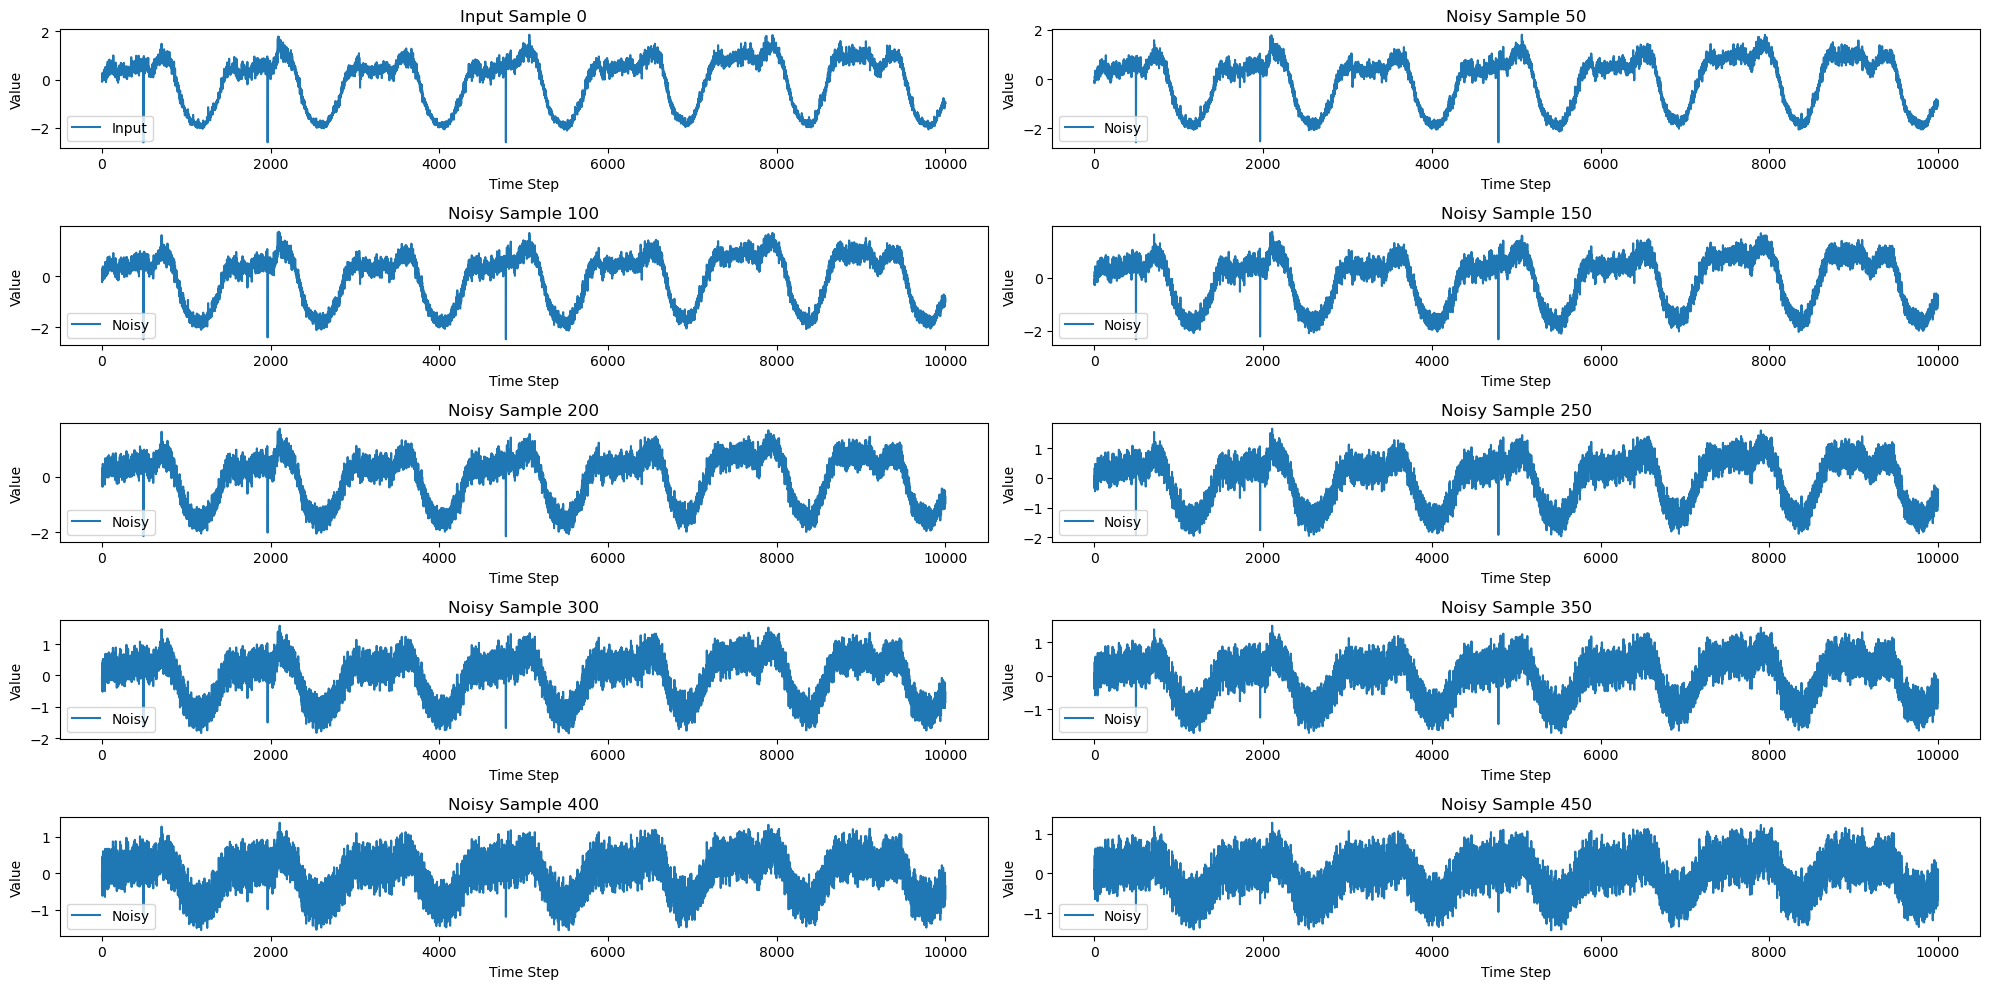

  0%|          | 0/293 [00:03<?, ?it/s]


In [16]:
sequence_length = 18200
input_size = 2  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,normalize=True)

# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Initialize TCN model
model = TCN(
    input_size=input_size,  # +1 for time information
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
)
#================================================================================================

noise_scheduler = SimplexNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        print(step)
        print(batch)
        print(timestamps)
        print(labels)
        
        noise = noise_scheduler.generate_simplex_noise_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print('timesteps', timesteps)

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        print(f"Batch shape: {batch.shape}")
        print(f"Noise shape: {noise.shape}")
        print(f"Noisy shape: {noisy.shape}")
        

        # Visualize the input and noisy data 
        fig, axs = plt.subplots(5, 2, figsize=(20, 10))
        
        # Plotting the first sample
        ax = axs[0, 0]
        ax.plot(batch[0].cpu().numpy())
        ax.set_title("Input Sample 0")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])

        # Plotting noisy versions of the first sample
        for i in range(9):
            noisy_sample = noise_scheduler.add_noise(batch[0], noise[0], torch.tensor([(i+1)*50]))
            ax = axs[(i+1) // 2, (i+1) % 2]
            ax.plot(noisy_sample[0].cpu().numpy())
            ax.set_title(f"Noisy Sample {(i+1)*50}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.legend(["Noisy"])

        fig.tight_layout()
        plt.show()
        
        break

# Reconstruction steps visualisation :

In [2]:

import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset , TimeSeriesTestDataset
from ddpm_Time_Series_copy import TCN 
from ddpm_Time_Series_copy import NoiseScheduler


import torch
from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

from positional_embeddings import PositionalEmbedding

In [9]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = {
  "data_path": "../datasets/UTS/WSD/107",
  "output_dir": "output",
  "train_batch_size": 16,
  "eval_batch_size": 16,
  "num_epochs": 10,
  
  "learning_rate": 0.0001,
  "num_timesteps": 1000,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.02,
  "save_model_epochs": 1
}


# Create Config object
config = Config(config)

<font size="6">
    <font color='red'>
    Verifier pour la prediction de noise si ce n'est pas un probleme avec la manière de sampling (ma manière d'enlever le bruit)
    </font> 
</font>

## Ajout de buits de manière random avec perso TCN - prediction noise


The Evaluation and visualization part of the code performs the following tasks:


1. Model Evaluation:
   - It switches the model to evaluation mode (`model.eval()`).
   - This part runs every 5 epochs or at the end of training.

2. Sample Generation:
   - It creates a batch of random noise samples (`torch.randn(eval_batch_size, sequence_length)`).
   - It then uses the trained model to gradually denoise these samples.

3. Denoising Process:
   - It iterates through the timesteps in reverse order.
   - For each timestep, it:
     a. Creates a tensor of the current timestep.
     b. Uses the model to predict the residual noise.
     c. Applies the noise scheduler to update the sample.

4. Visualization:
   - It creates a 2x2 grid of subplots.
   - For up to 4 generated samples:
     a. It plots each sample on a subplot.
     b. Sets titles, labels, and adjusts the layout.
   - Finally, it displays the plot.

This process allows you to visually inspect the quality of the generated samples throughout the training process, helping you assess how well the model is learning to generate time series data.

Would you like me to explain any specific part of this process in more detail?

In [33]:
input_size = 2  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=True)

# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Initialize TCN model
model = TCN(
    input_size=input_size,  # +1 for time information
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
)
#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        noise = torch.randn_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        print("timesteps", timesteps)
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)

        # pred noise from the model
        noise_pred = model(noisy, timesteps)
        
        """order proposed by claude --- to verify """
        loss = nn.MSELoss()(noise_pred, noise)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
        
        
        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
    print(f"epoch number {epoch} done")
    print("number of epochs in the configuration", config.num_epochs)
    
    # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0 :
        model.eval()
        eval_batch_size = config.eval_batch_size
        sample = torch.randn(eval_batch_size, sequence_length)
        timesteps = list(range(noise_scheduler.num_timesteps))[::-1]

        with torch.no_grad():
            for i, t in enumerate(tqdm(timesteps, desc="Sampling")):
                time_tensor = torch.full((eval_batch_size,), t, device=sample.device, dtype=torch.long)
                residual = model(sample, time_tensor)
                sample = noise_scheduler.step(residual, time_tensor[0], sample)
    
        # Visualize the generated samples
        fig, axs = plt.subplots(2, 5, figsize=(25, 10))  # Changed to 2 rows, 5 columns
        for i in range(eval_batch_size):
            ax = axs[i // 5, i % 5]  # Adjust subplot selection
            ax.plot(sample[i].cpu().numpy())
            ax.set_title(f"Sample {i+1}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.tick_params(axis='both', which='major', labelsize=8)  # Smaller tick labels

        plt.tight_layout()
        plt.show()

        
    progress_bar.close()


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model...


  0%|          | 0/1 [00:00<?, ?it/s]?, ?it/s]

timesteps tensor([195, 344, 150, 377, 196, 470, 297,  63,  73,  76,  49, 164, 295, 239,
         99, 414])


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [28]:
import torch

device = None
# Check if GPU is available
device = torch.device( "cpu")

# Your code here


## Ajout de buit incrémentalement perso TCN - prediction noise:

In [4]:
sequence_length=5000
input_size = 2  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=True)

# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Initialize TCN model
model = TCN(
    input_size=input_size,  # +1 for time information
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
)
#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        noise = torch.randn_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        # order timesteps 
        timesteps = timesteps.sort()[0]
        
        print('timesteps', timesteps)
        
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        # pred noise from the model
        noise_pred = model(noisy, timesteps)
        
        loss = F.mse_loss(noise_pred, noise)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
   # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0 :
        model.eval()
        eval_batch_size = config.eval_batch_size
        sample = torch.randn(eval_batch_size, sequence_length)
        timesteps = list(range(noise_scheduler.num_timesteps))[::-1]

        with torch.no_grad():
            for i, t in enumerate(tqdm(timesteps, desc="Sampling")):
                time_tensor = torch.full((eval_batch_size,), t, device=sample.device, dtype=torch.long)
                residual = model(sample, time_tensor)
                sample = noise_scheduler.step(residual, time_tensor[0], sample)
    
        # Visualize the generated samples
        fig, axs = plt.subplots(2, 5, figsize=(25, 10))  # Changed to 2 rows, 5 columns
        for i in range(eval_batch_size):
            ax = axs[i // 5, i % 5]  # Adjust subplot selection
            ax.plot(sample[i].cpu().numpy())
            ax.set_title(f"Sample {i+1}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Value")
            ax.tick_params(axis='both', which='major', labelsize=8)  # Smaller tick labels

        plt.tight_layout()
        plt.show()

        
    progress_bar.close()


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model...


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 17,  43,  52, 144, 177, 184, 208, 222, 257, 259, 335, 347, 348, 432,
        473, 490])


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  3,  12,  12,  41, 102, 115, 148, 184, 191, 195, 246, 249, 309, 432,
        461, 483])


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  9,  73, 128, 129, 141, 165, 181, 191, 211, 338, 363, 379, 423, 455,
        466, 497])


Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  3,   8,  36,  77,  85, 260, 293, 311, 322, 353, 363, 379, 401, 402,
        462, 468])


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 14,  96, 103, 113, 168, 182, 190, 228, 298, 318, 374, 379, 418, 423,
        476, 486])


Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 16,  16,  22,  38,  38, 116, 144, 149, 154, 218, 271, 329, 336, 346,
        415, 494])


Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 50,  59, 113, 144, 149, 169, 260, 260, 273, 288, 304, 311, 343, 417,
        449, 450])


Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 47,  65,  91,  97, 166, 196, 201, 227, 241, 245, 266, 286, 343, 363,
        394, 482])


Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  5,  17,  74,  98, 112, 115, 122, 155, 156, 210, 220, 255, 292, 351,
        375, 442])


Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 33, 105, 154, 164, 167, 206, 223, 237, 248, 249, 278, 286, 402, 420,
        455, 498])


Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 10,  50,  55, 103, 122, 169, 236, 245, 255, 265, 332, 335, 338, 393,
        481, 494])


Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  3,  66, 145, 180, 224, 225, 285, 331, 363, 369, 378, 378, 407, 441,
        449, 481])


Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 45,  81,  99, 133, 239, 239, 328, 334, 379, 392, 403, 429, 441, 465,
        479, 489])


Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  7,  49, 148, 172, 226, 242, 269, 289, 310, 318, 348, 369, 394, 406,
        475, 499])


Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 11,  20, 100, 129, 165, 167, 208, 225, 263, 274, 293, 310, 317, 464,
        491, 495])


Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 43,  78, 101, 106, 111, 112, 122, 152, 157, 213, 290, 381, 399, 404,
        468, 470])


Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 38,  60,  66, 102, 125, 140, 153, 281, 299, 332, 336, 345, 353, 456,
        465, 492])


Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([111, 134, 193, 211, 226, 327, 356, 384, 397, 403, 407, 412, 427, 441,
        463, 495])


Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  7,   7,  55,  83, 217, 239, 255, 287, 296, 312, 332, 382, 393, 423,
        429, 430])


Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 36,  57,  77,  89, 144, 163, 176, 243, 246, 273, 277, 284, 408, 419,
        439, 489])


Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  5,   7,  18,  23,  73, 119, 132, 140, 154, 154, 294, 361, 364, 411,
        420, 454])


Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 26,  75, 113, 137, 186, 187, 190, 224, 231, 252, 309, 309, 319, 438,
        492, 493])


Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 11,  63,  64,  70,  72, 129, 167, 199, 211, 278, 279, 312, 369, 390,
        421, 481])


Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 19,  54,  68, 102, 110, 147, 169, 232, 238, 269, 297, 320, 341, 374,
        462, 493])


Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 10,  23,  85, 108, 188, 194, 239, 260, 286, 315, 343, 355, 368, 422,
        464, 476])


Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  3,  58, 124, 134, 136, 150, 234, 284, 291, 295, 348, 350, 430, 439,
        441, 459])


Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 14,  35,  93,  95, 160, 181, 184, 188, 247, 318, 320, 331, 354, 415,
        439, 453])


Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 19,  33,  70, 137, 177, 218, 308, 314, 326, 339, 345, 371, 385, 417,
        430, 481])


Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 15,  24,  43,  76, 170, 180, 209, 288, 301, 342, 376, 409, 417, 480,
        486, 487])


Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 34,  38,  38,  43,  47,  53,  61,  65, 146, 186, 192, 227, 365, 408,
        416, 438])


Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 29, 105, 128, 146, 170, 181, 187, 189, 258, 283, 306, 308, 391, 402,
        424, 470])


Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([107, 113, 137, 141, 148, 165, 168, 223, 250, 254, 315, 329, 345, 399,
        477, 493])


Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  24, 117, 156, 161, 172, 213, 253, 350, 370, 404, 438, 453, 466,
        479, 483])


Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([119, 194, 195, 196, 209, 214, 225, 242, 251, 287, 352, 356, 416, 419,
        422, 468])


Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  5,  27,  70, 187, 192, 206, 248, 270, 299, 348, 397, 401, 403, 418,
        421, 424])


Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 28,  28,  29,  64,  68, 109, 123, 132, 218, 249, 271, 369, 387, 403,
        434, 472])


Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  6,  24,  48,  51,  87, 107, 163, 168, 201, 211, 271, 277, 279, 344,
        382, 454])


Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  0,  39,  86,  99, 110, 287, 323, 339, 350, 352, 355, 407, 423, 455,
        456, 473])


Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 10,  13,  23,  29,  38,  40,  86, 118, 119, 145, 154, 322, 330, 342,
        439, 496])


Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 31, 127, 141, 187, 230, 233, 253, 311, 335, 347, 370, 382, 446, 459,
        463, 476])


Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 17,  57,  79, 121, 132, 191, 223, 228, 288, 344, 366, 423, 447, 451,
        471, 482])


Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 17,  23,  37,  79,  86,  91, 117, 141, 183, 254, 294, 321, 357, 393,
        464, 497])


Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 25,  28,  59,  74,  81, 115, 129, 164, 172, 222, 263, 329, 334, 344,
        464, 465])


Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 73, 103, 124, 164, 176, 192, 252, 267, 294, 306, 315, 346, 383, 401,
        464, 468])


Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  9,  17,  32,  88,  94, 149, 183, 217, 243, 282, 315, 380, 428, 464,
        474, 484])


Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  7,   9,  25,  29,  93, 128, 138, 201, 277, 333, 374, 375, 379, 382,
        407, 484])


Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 62,  94, 105, 109, 109, 178, 230, 237, 272, 310, 354, 386, 426, 479,
        481, 489])


Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 11,  20,  80, 103, 115, 153, 158, 188, 263, 267, 271, 412, 446, 454,
        454, 455])


Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([  4, 153, 160, 186, 211, 234, 280, 297, 323, 378, 385, 396, 416, 423,
        438, 492])


Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s]

timesteps tensor([ 56,  74,  95,  98, 105, 151, 163, 185, 219, 268, 286, 300, 327, 417,
        473, 490])


100%|██████████| 1/1 [00:01<00:00,  1.99s/it] 1.99s/it, loss=1, step=49]


NameError: name 'sequence_length' is not defined

## Ajout de buit incrémentalement perso TCN - prediction Image de base :

Batch shape: torch.Size([16, 5000])
Noise shape: torch.Size([16, 5000])
Noisy shape: torch.Size([16, 5000])

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model...


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.02s/it] 2.02s/it, loss=2.66e+5, step=49]


eval timesteps tensor([442, 245, 100,  59, 467, 307, 312, 100, 450, 267, 365, 449,   3, 371,
        491, 417])


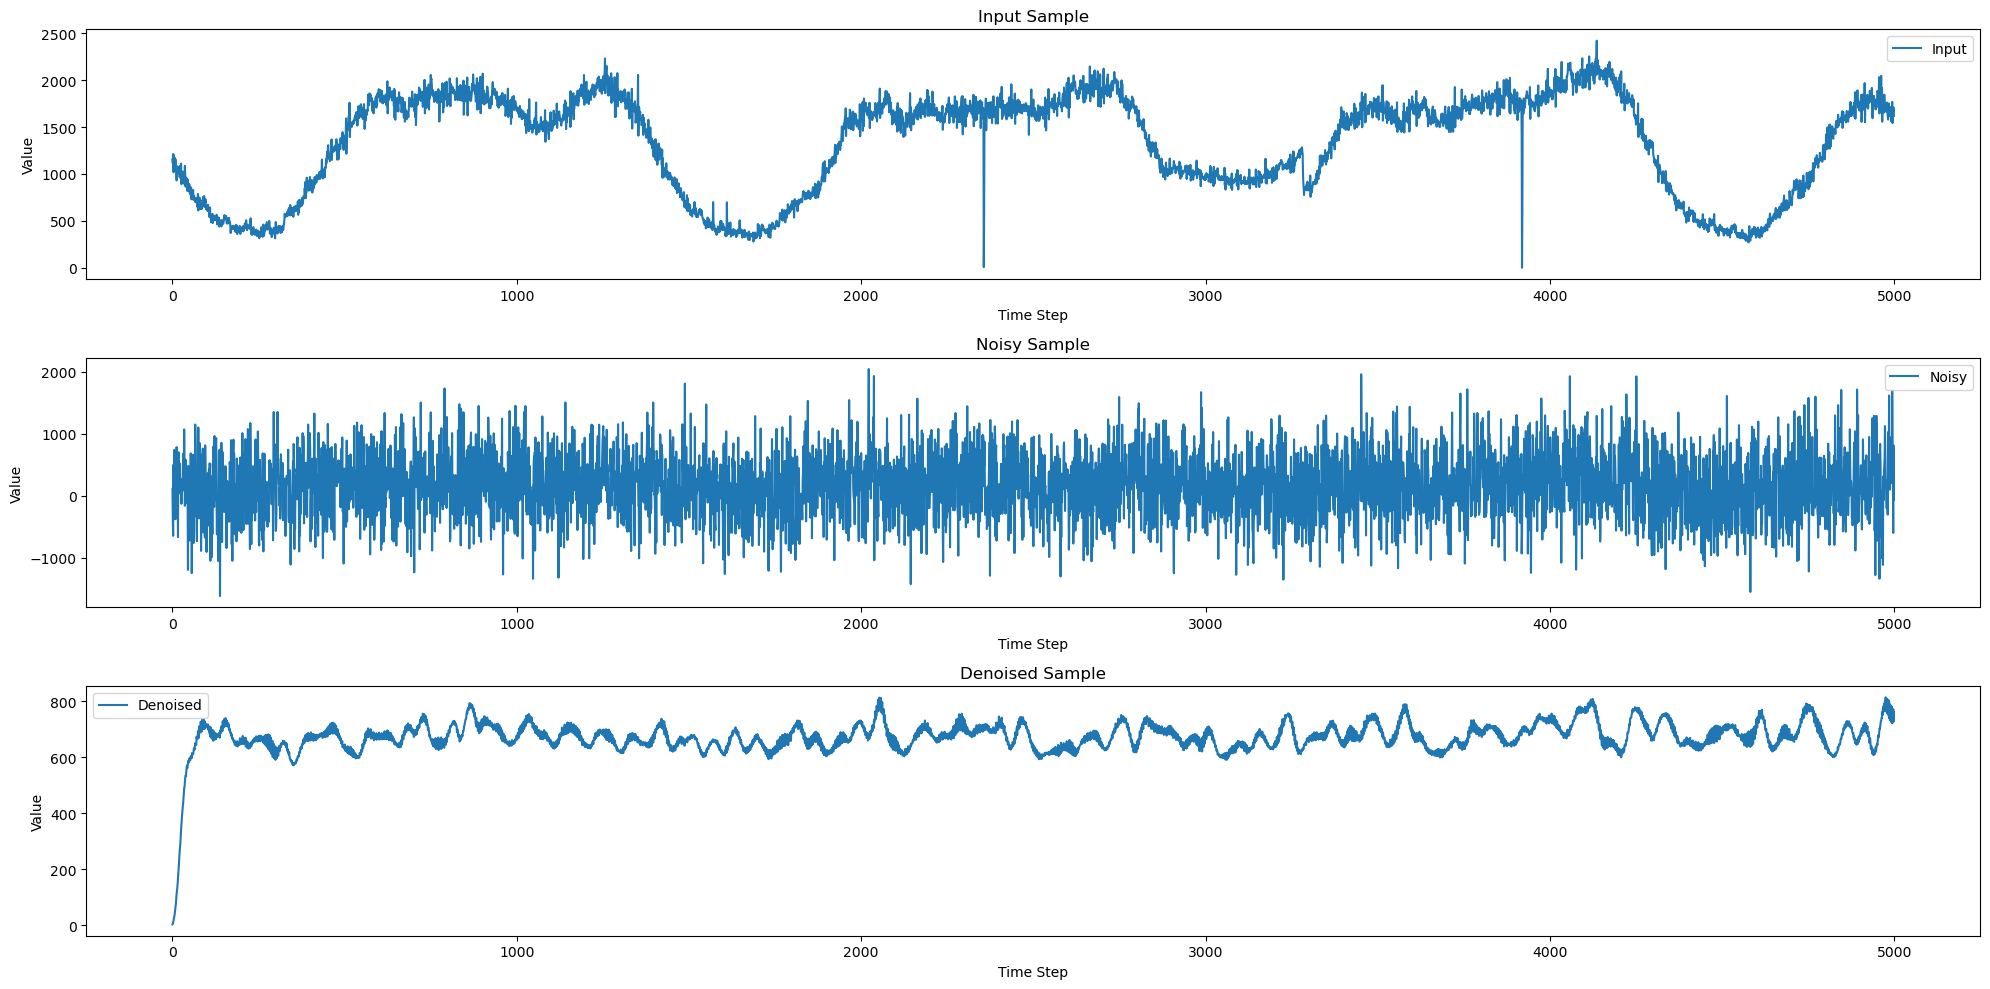

Epoch 49: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, loss=2.66e+5, step=49]


In [33]:
sequence_length = 5000
input_size = 2  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)
# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Set up dataset and dataloader for test data
test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

# Create dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)


# Initialize TCN model
model = TCN(
    input_size=input_size,  # +1 for time information
    output_size=1,
    num_channels=[64, 128, 256, 512],
    kernel_size=3,
    dropout=0.2
)
#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        
        #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        # order timesteps 
        timesteps = timesteps.sort()[0]
        
        std_data = torch.std(batch)
                
        #noise = torch.randn_like(batch)
        
        # I want the noise level increasing with epoch
    
        noise_level = 0.1 * (epoch+10)/5
        noise = torch.randn_like(batch) * std_data * noise_level

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        # pred noise from the model
        noise_pred = model(noisy, timesteps)
        
        loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
   # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0 :
        model.eval()
        eval_batch_size = config.eval_batch_size

        for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
            
            # after sapling random noise, predict using the model to denoise the sample
            with torch.no_grad():
                timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
                print("eval timesteps", timesteps)
                
                std_data = torch.std(batch)
                noise_level = 1
                noise = torch.randn_like(batch) * std_data * noise_level
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                denoised_sample = model(noisy_sample, timesteps)
                
                # Visualize the input the noisy and denoised data
                
                fig, axs = plt.subplots(3, 1, figsize=(20, 10))
                ax = axs[0]
                ax.plot(sample[0].cpu().numpy())
                ax.set_title("Input Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Input"])
                
                ax = axs[1]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title("Noisy Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Noisy"])
                
                ax = axs[2]
                ax.plot(denoised_sample[0].cpu().numpy())
                ax.set_title("Denoised Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Denoised"])
                
                plt.tight_layout()
                plt.show()
                
            break
            

        
    progress_bar.close()


### evaluation and anomaly prediction 

  0%|          | 0/1 [00:00<?, ?it/s]

eval timesteps tensor([269, 477, 188, 171, 299,  94, 171, 206,  95, 246, 344, 195,  33, 431,
        498, 289])
std_data tensor(527.8704)


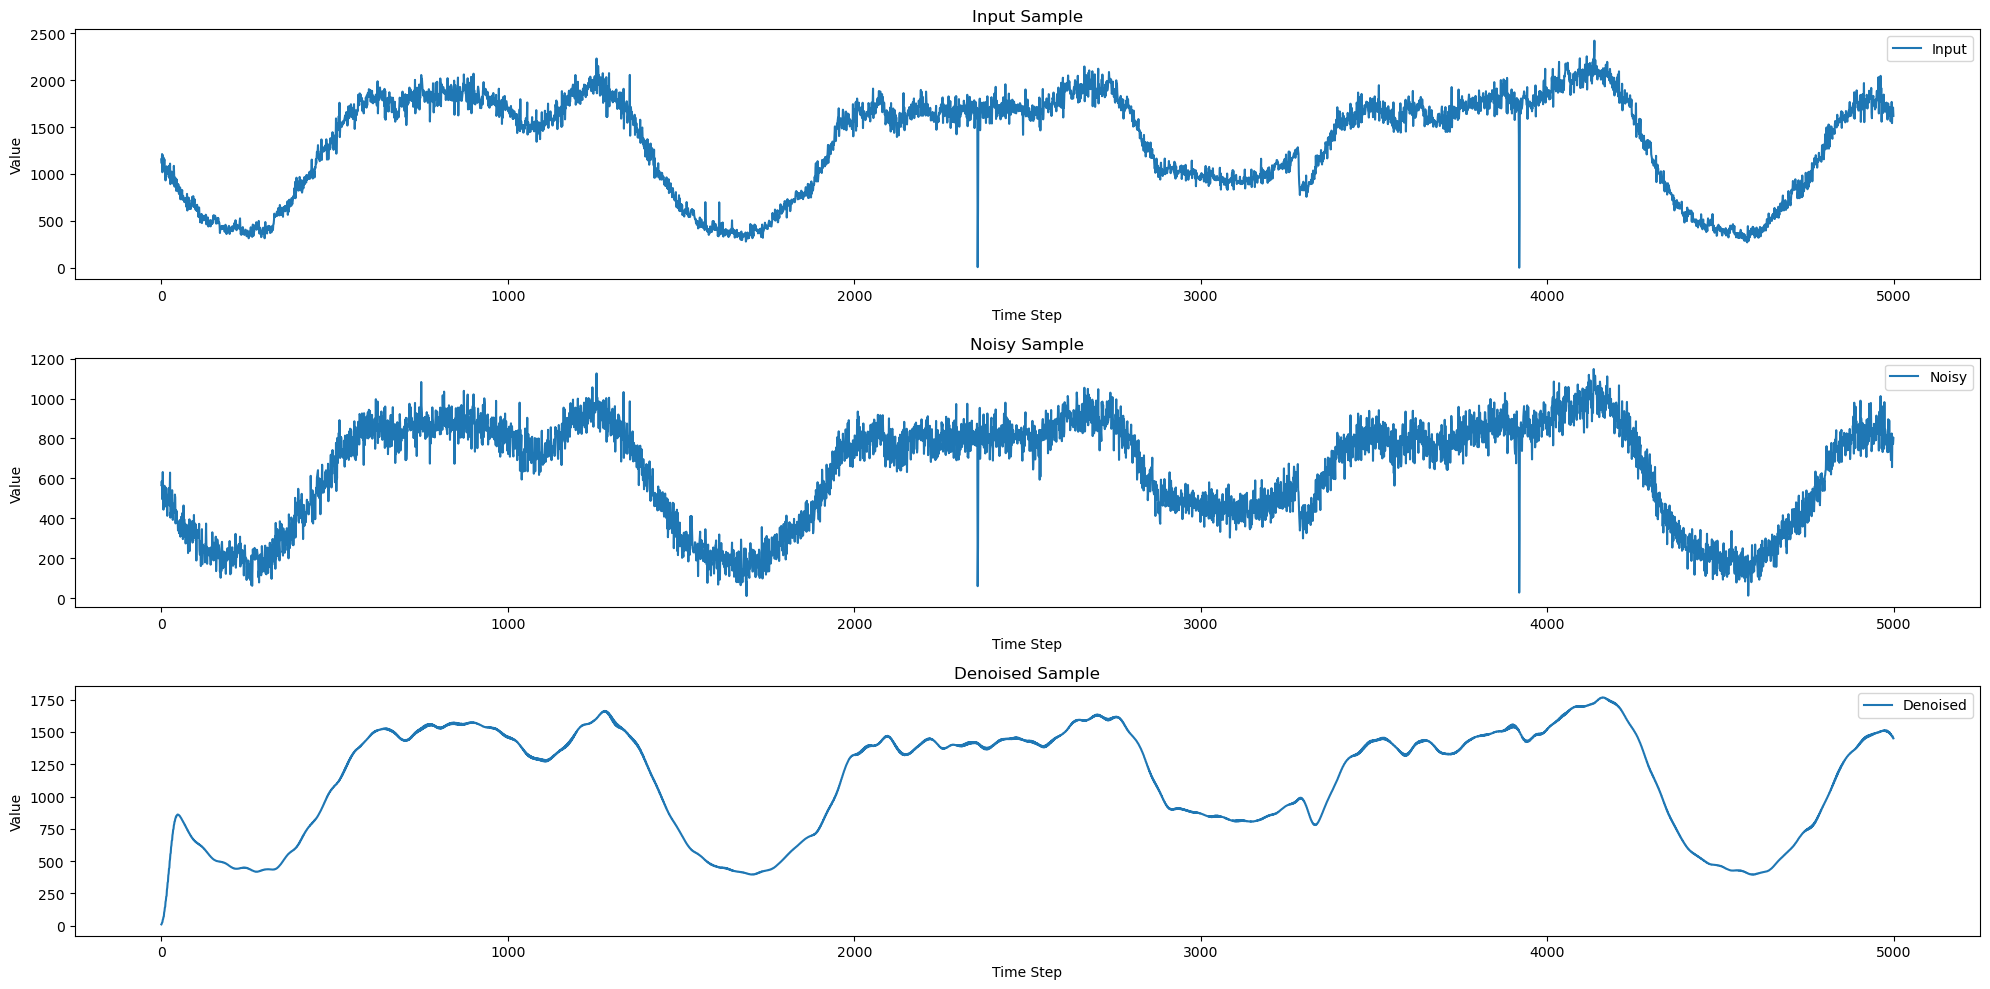

Outliers: [[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [False False False ... False False False]]
labels tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


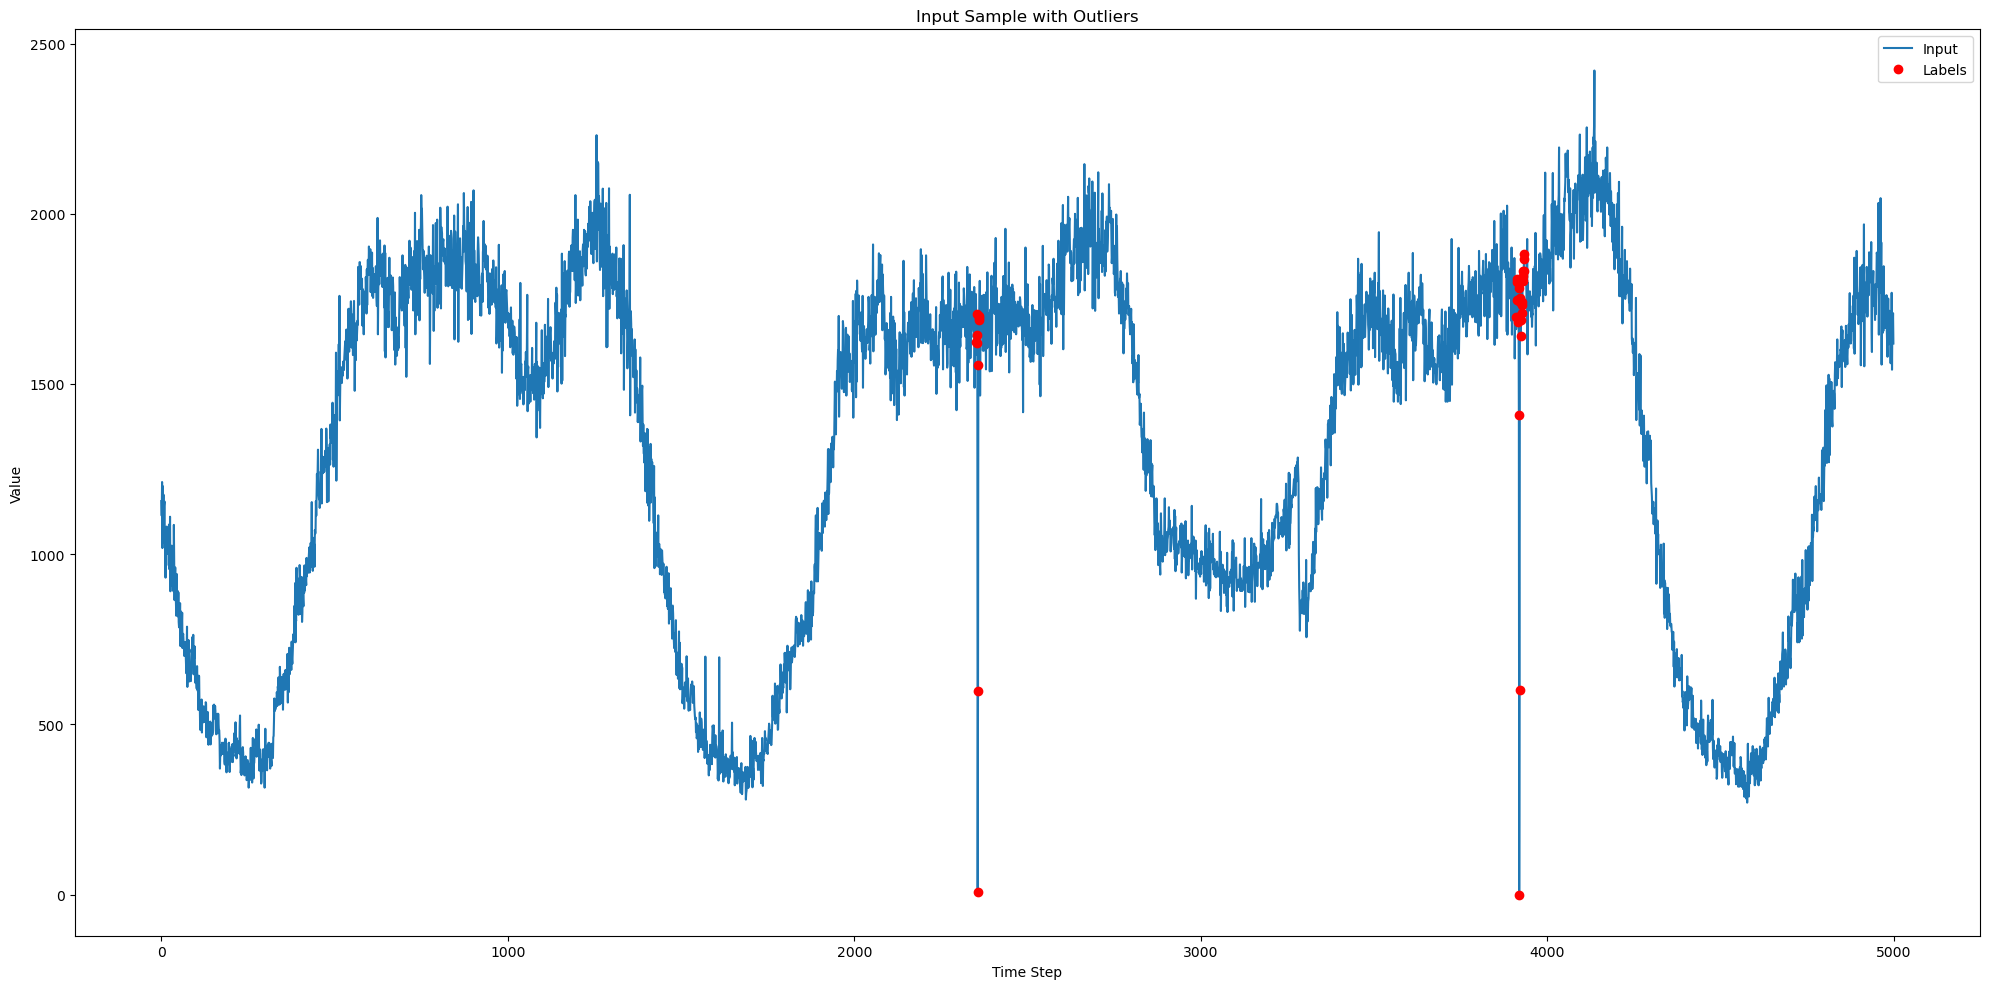

  0%|          | 0/1 [00:00<?, ?it/s]


In [62]:
model.eval()
eval_batch_size = config.eval_batch_size

for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
    
    # after sapling random noise, predict using the model to denoise the sample
    with torch.no_grad():
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
        print("eval timesteps", timesteps)
        
        std_data = torch.std(sample)
        print("std_data", std_data)
        noise_level = 0.1
        noise = torch.randn_like(sample) * std_data * noise_level
        noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
        
        denoised_sample = model(sample, timesteps)
        
        # Visualize the input the noisy and denoised data
        
        fig, axs = plt.subplots(3, 1, figsize=(20, 10))
        ax = axs[0]
        ax.plot(sample[0].cpu().numpy())
        ax.set_title("Input Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])
        
        ax = axs[1]
        ax.plot(noisy_sample[0].cpu().numpy())
        ax.set_title("Noisy Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Noisy"])
        
        ax = axs[2]
        ax.plot(denoised_sample[0].cpu().numpy())
        ax.set_title("Denoised Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Denoised"])
        
        plt.tight_layout()
        plt.show()
        
        # predict outlier points in the input sample by comparing the denoised sample with the input sample with a threshold
        threshold = 600
        
        outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()

        print("Outliers:", outliers)
        print("labels", labels)
        
        labels = labels.cpu().numpy()
        
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        #outlier_indices = np.where(outliers[0] == 1)[0]
        #ax.plot(outlier_indices, sample[0][outlier_indices].cpu().numpy(), 'ro', label="Outliers")
        
        label_indices = np.where(labels[0] == True)[0]
        ax.plot(label_indices, sample[0][label_indices].cpu().numpy(), 'ro', label="Labels")
        
        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
    break

Test results :  with shuffle =  FALSE on 5000 data batch size 16 and normalize = TRUE 

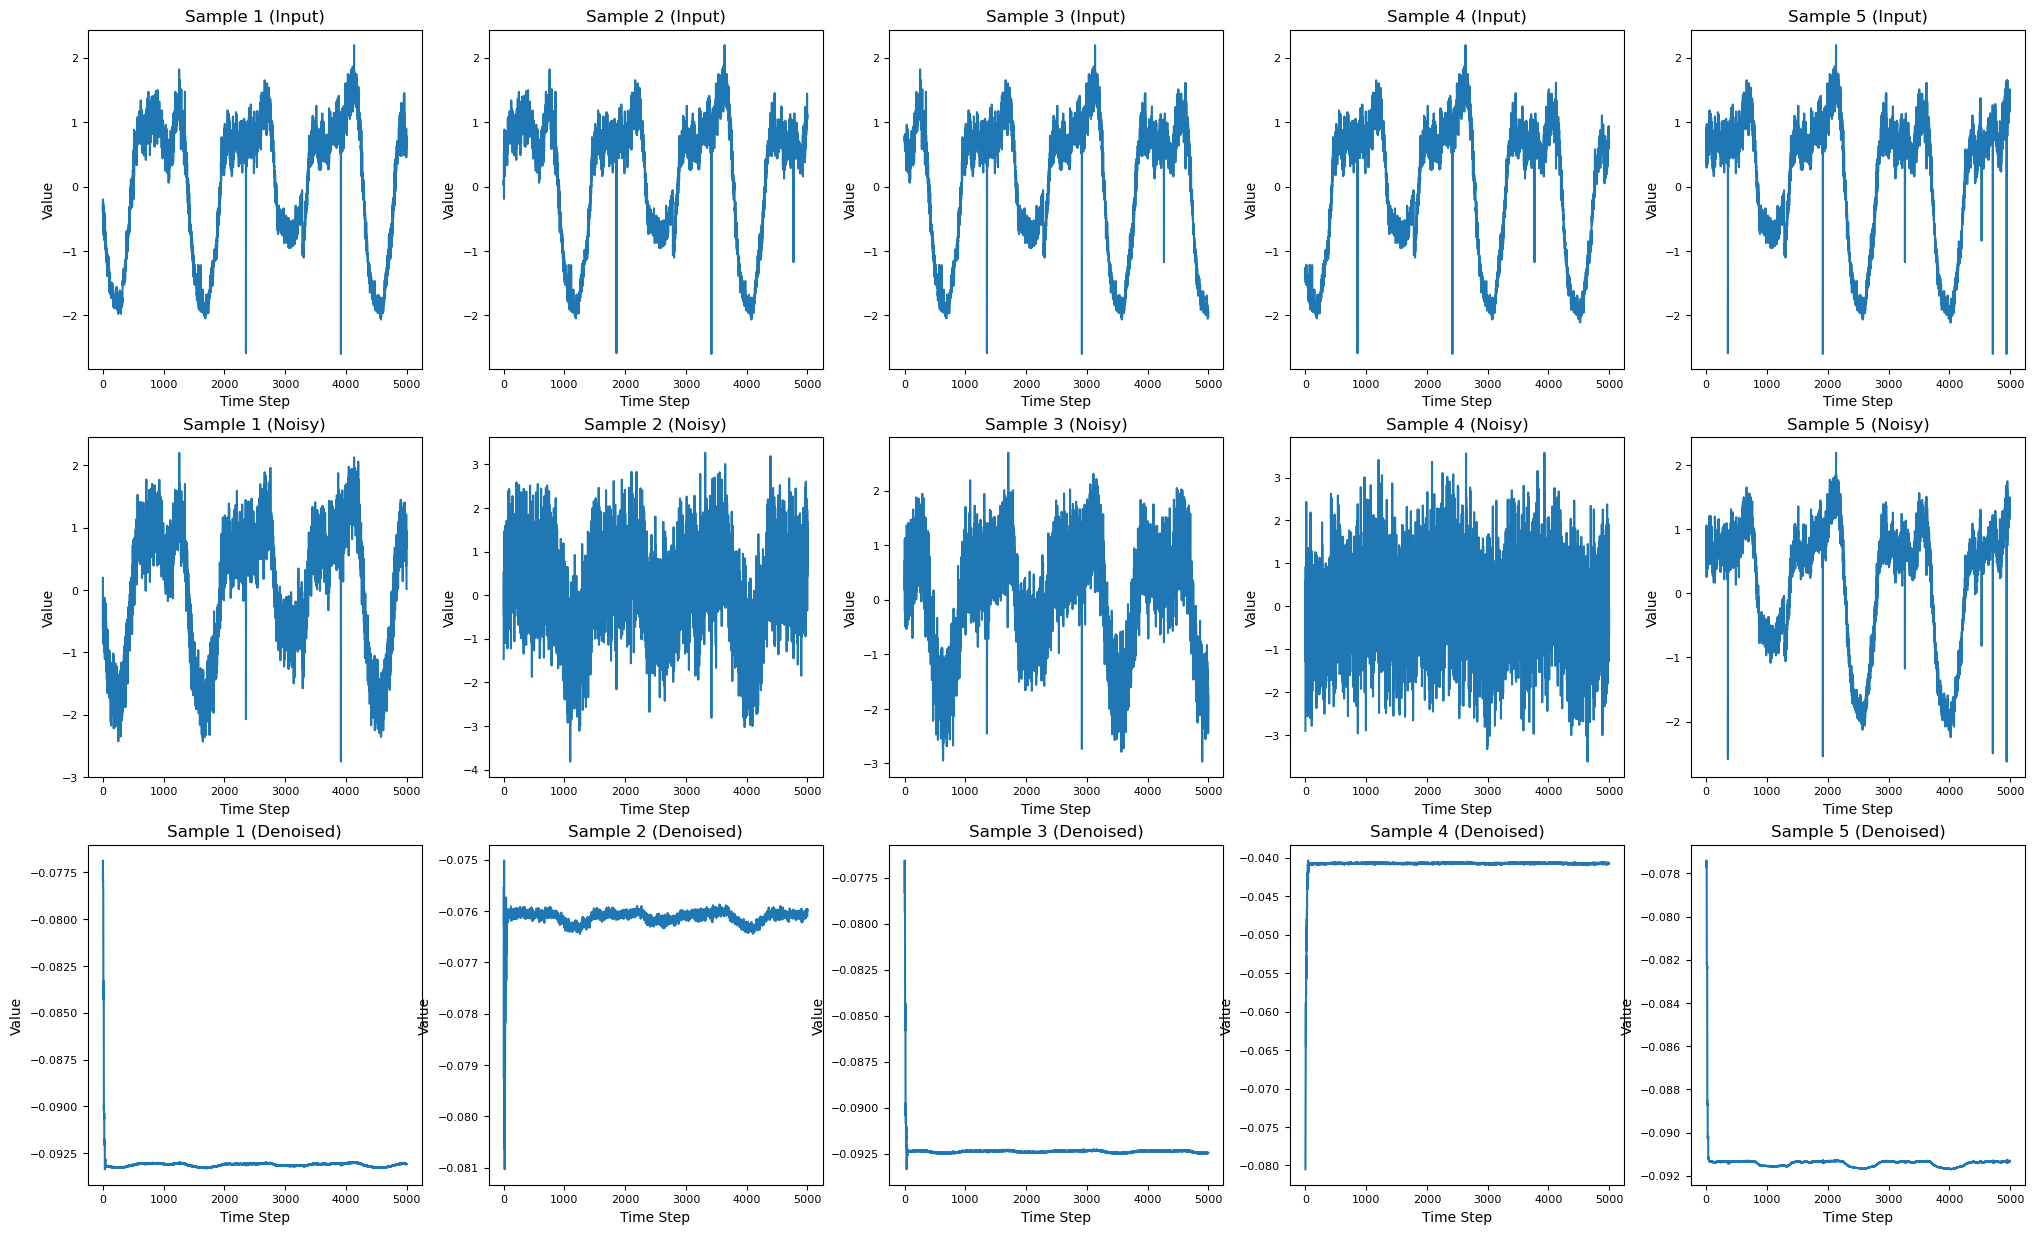

st results :  with shuffle =  TRUE on 5000 data batch size 16 and normalize = TRUE 
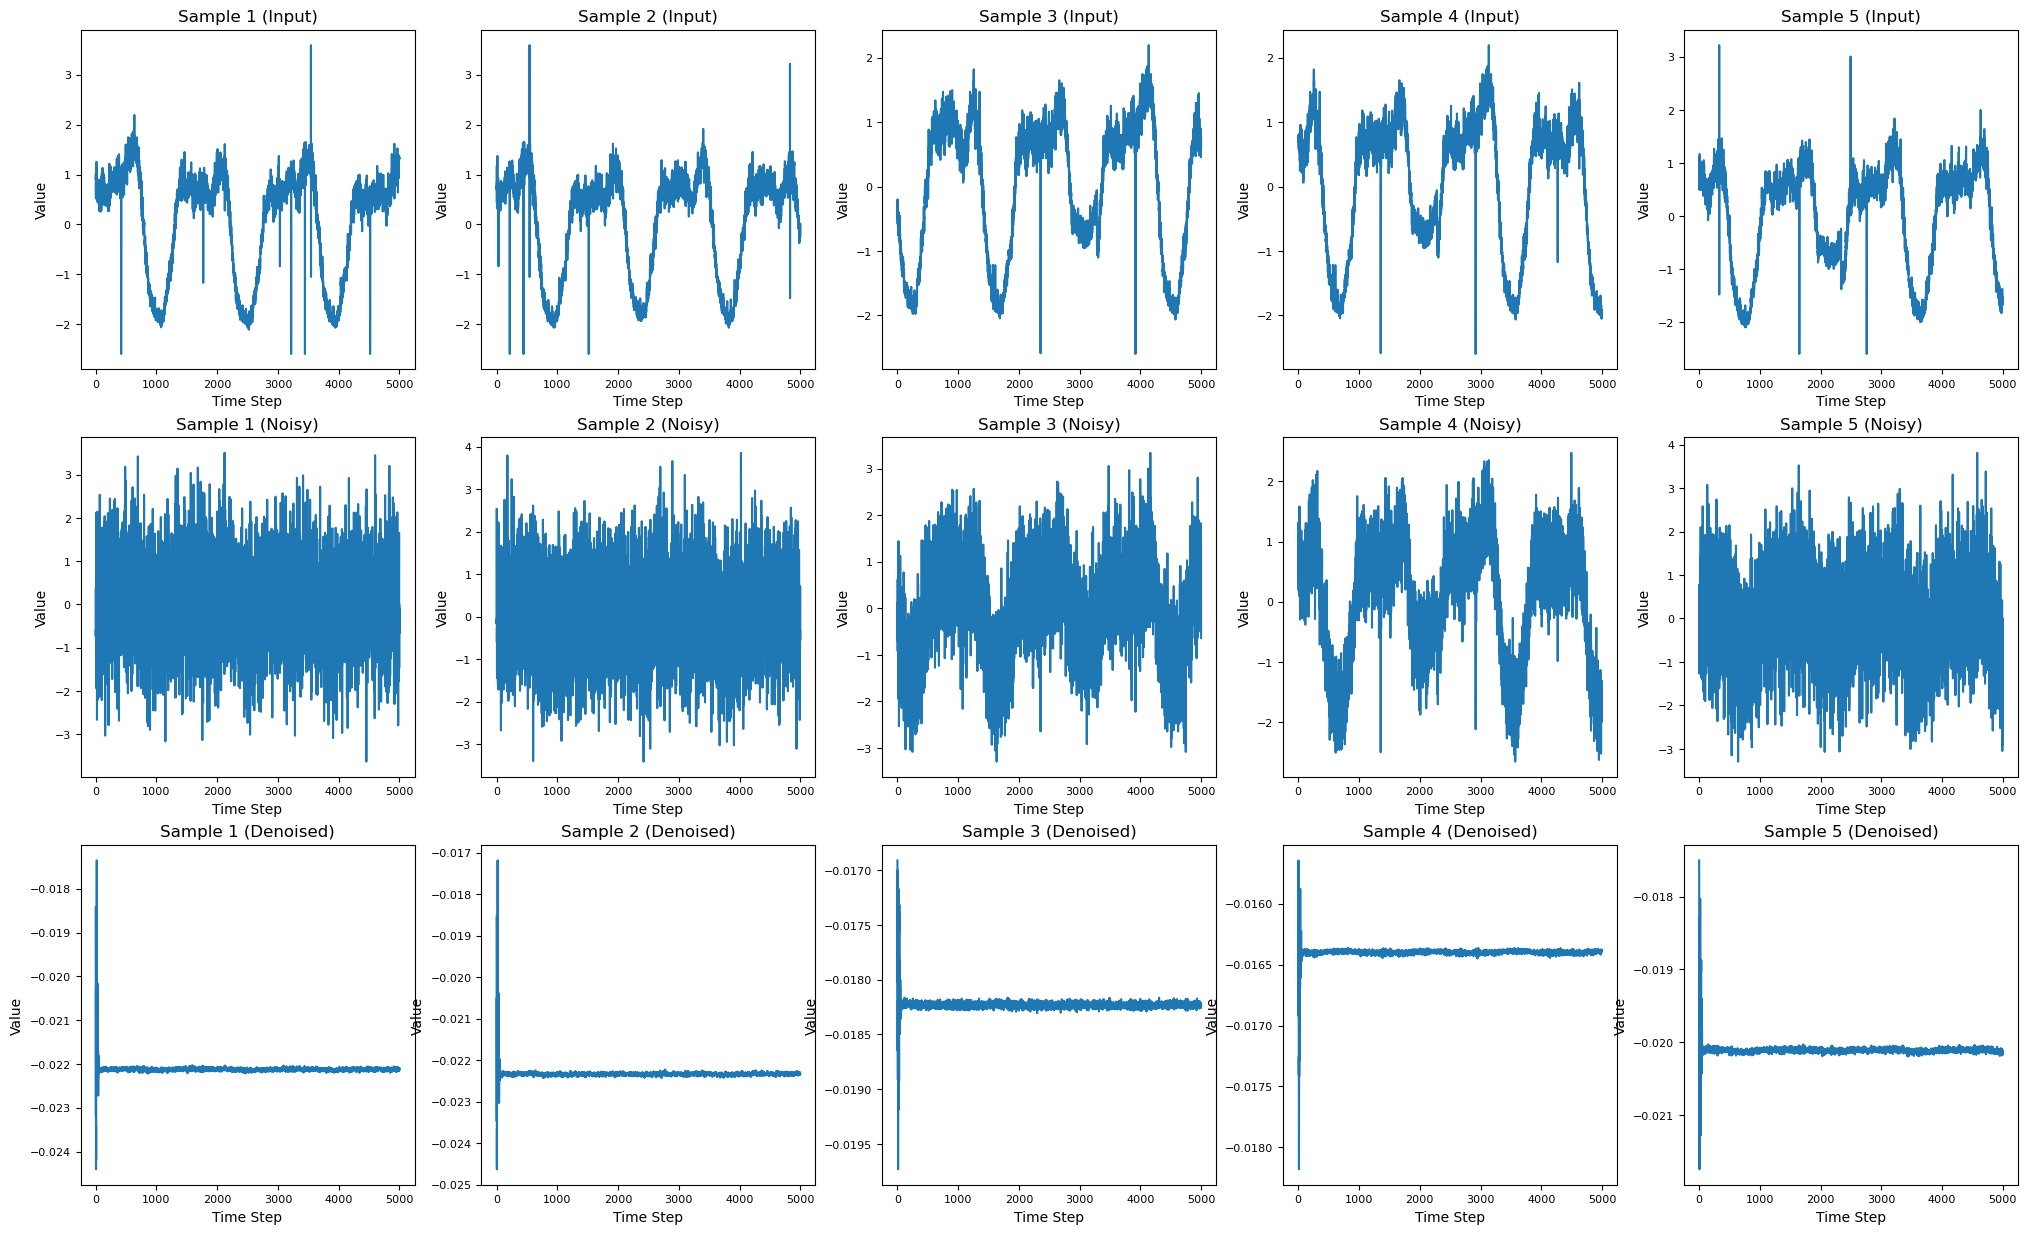

## <font color='green'> Ajout de buit incrémentalement PyTorch TCN - prediction Image de base :</font> 

In [ ]:
!pip install pytorch-tcn

Training model...


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s]

noise_pred torch.Size([16, 5000, 1])


100%|██████████| 1/1 [00:02<00:00,  3.00s/it] 3.00s/it, loss=1.88e+5, step=49]


eval timesteps tensor([396, 159, 337, 284, 299,  42, 332, 133, 392, 329, 255, 283, 474, 116,
        483, 162])


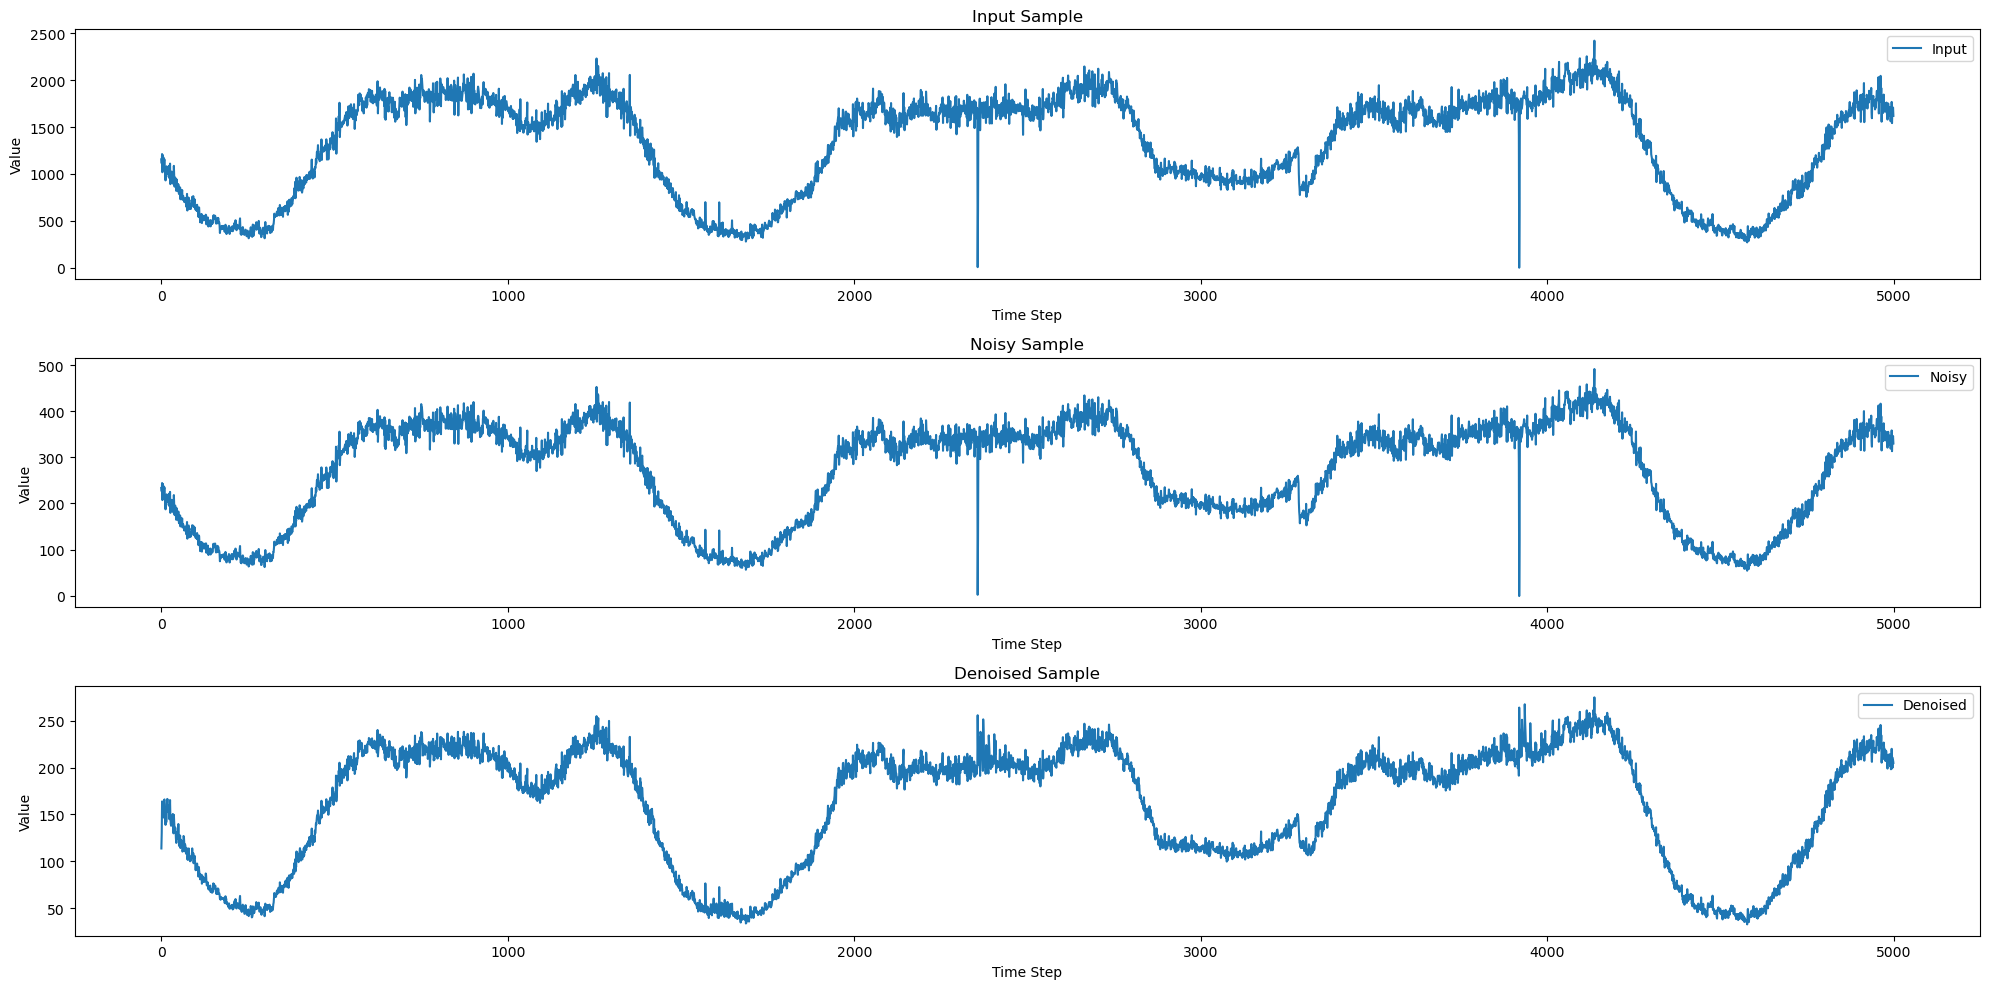

Epoch 49: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it, loss=1.88e+5, step=49]


In [11]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

# Continue with the rest of your training loop...

sequence_length = 5000
input_size = 1  # Assuming 1D time series data


# Assuming you have the rest of your code defined already...

# Initialize the new TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[64, 128, 256, 512,256,128,64,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)


# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)
# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Set up dataset and dataloader for test data
test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

# Create dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(tqdm(dataloader)):
        '''if model.input_shape == 'NCL':
            batch = batch.unsqueeze(1)  # Add channel dimension: (batch_size, 1, sequence_length)'''
        #elif model.input_shape == 'NLC':
            #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        #noise = torch.randn_like(batch)
        
        # timesteps from o to num_timesteps
        #timesteps = torch.arange(0, noise_scheduler.num_timesteps).repeat(batch.shape[0], 1)
        
        #timesteps = torch.linspace(0, noise_scheduler.num_timesteps - 1, steps=batch.shape[0]).long()
        std_data = torch.std(batch)

        # I want the noise level increasing with epoch
        noise_level = 0.1 * (epoch+10)/5
        noise = torch.randn_like(batch) * std_data * noise_level
                
        #noise = torch.randn_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        #print("timesteps", timesteps)
        
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        noisy = noisy.unsqueeze(-1) 
        # pred noise from the model
        noise_pred = model(noisy)
        
        print("noise_pred", noise_pred.shape)
        batch = batch.unsqueeze(-1)
        
        loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
   # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0 :
        model.eval()
        eval_batch_size = config.eval_batch_size

        for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
            
            # after sapling random noise, predict using the model to denoise the sample
            with torch.no_grad():
                timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
                print("eval timesteps", timesteps)
                
                std_data = torch.std(sample)
                noise_level = 0.1
                noise = torch.randn_like(sample) #* std_data * noise_level
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = noisy_sample.unsqueeze(-1)
                denoised_sample = model(noisy_sample)
                
                # Visualize the input the noisy and denoised data
                
                fig, axs = plt.subplots(3, 1, figsize=(20, 10))
                
                ax = axs[0]
                ax.plot(sample[0].cpu().numpy())
                ax.set_title("Input Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Input"])
                
                ax = axs[1]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title("Noisy Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Noisy"])
                
                ax = axs[2]
                ax.plot(denoised_sample[0].cpu().numpy())
                ax.set_title("Denoised Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Denoised"])
                
                plt.tight_layout()
                plt.show()
                
            break
            

        
    progress_bar.close()


### evaluation and anomaly prediction

  0%|          | 0/1 [00:00<?, ?it/s]

eval timesteps tensor([397, 257, 412, 464,  22, 344, 263,  93,  75, 250, 382, 247, 391, 405,
        164, 276])


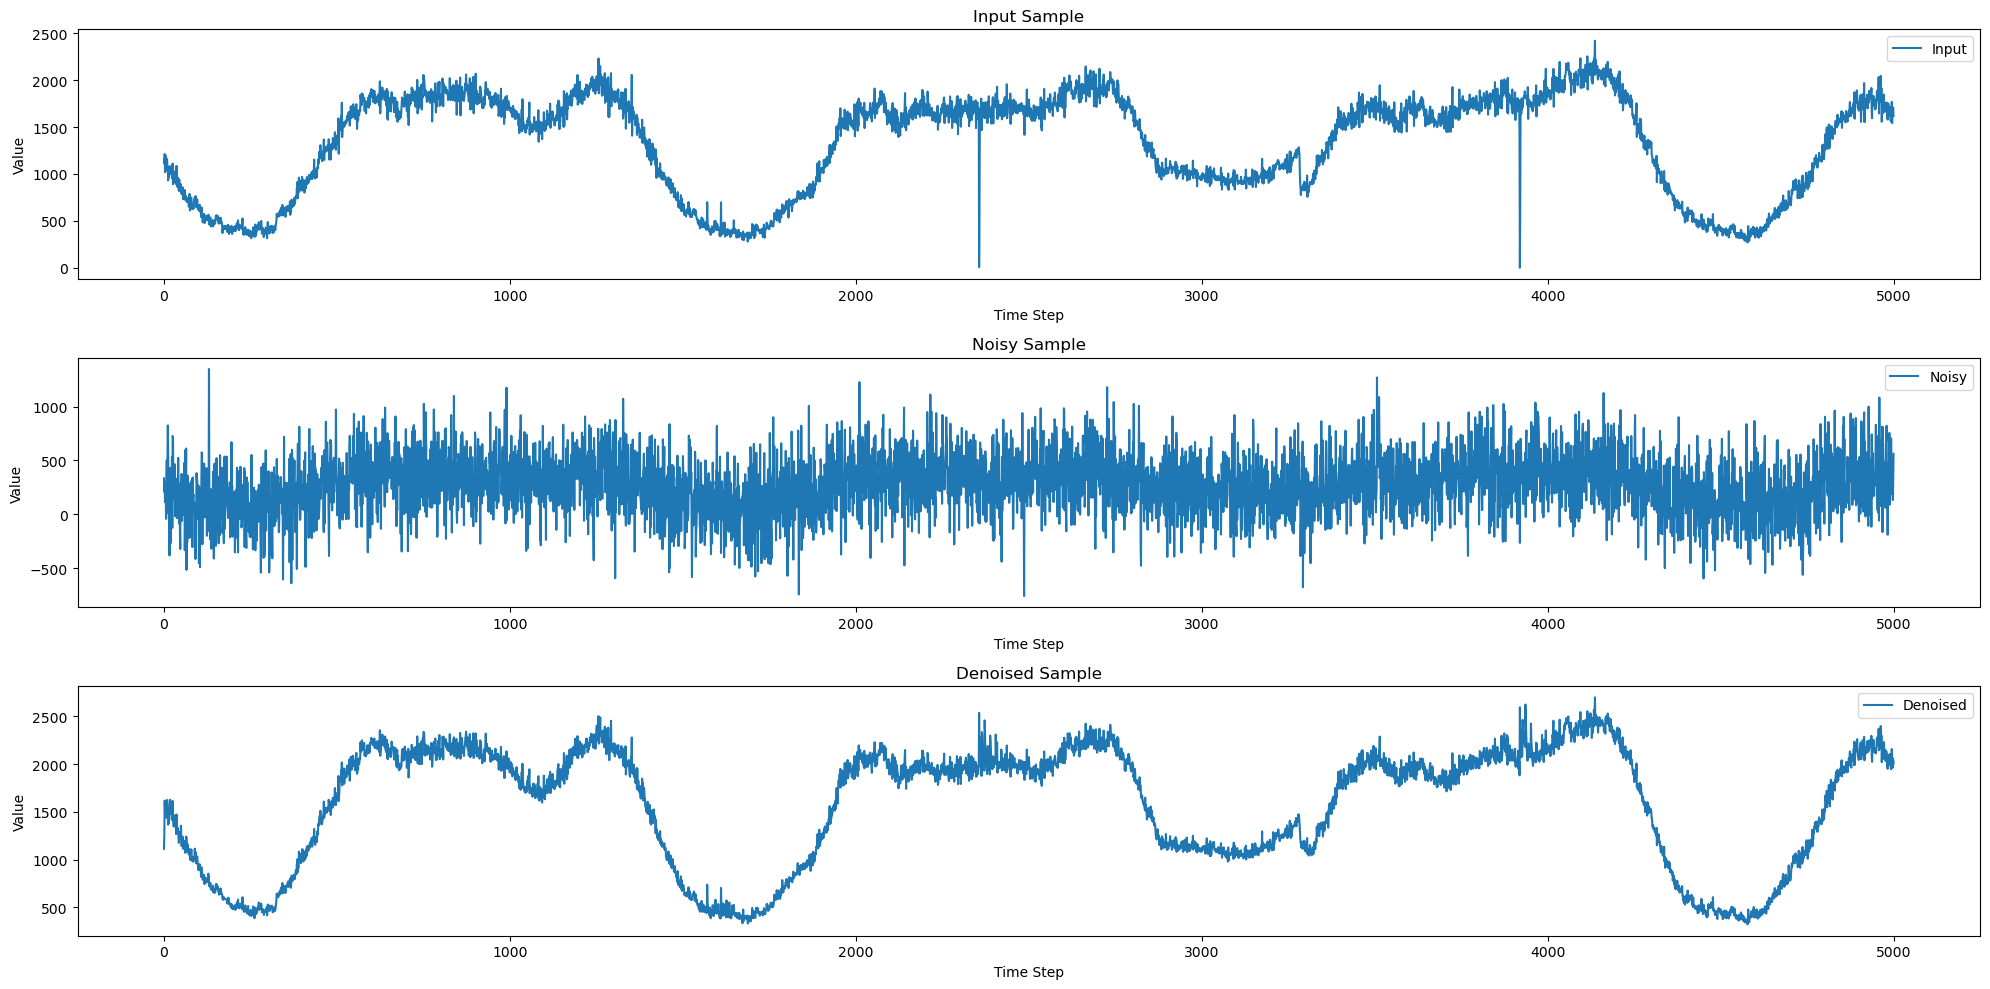

Outliers: [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [ True]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [ True]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [ True]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]
labels tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


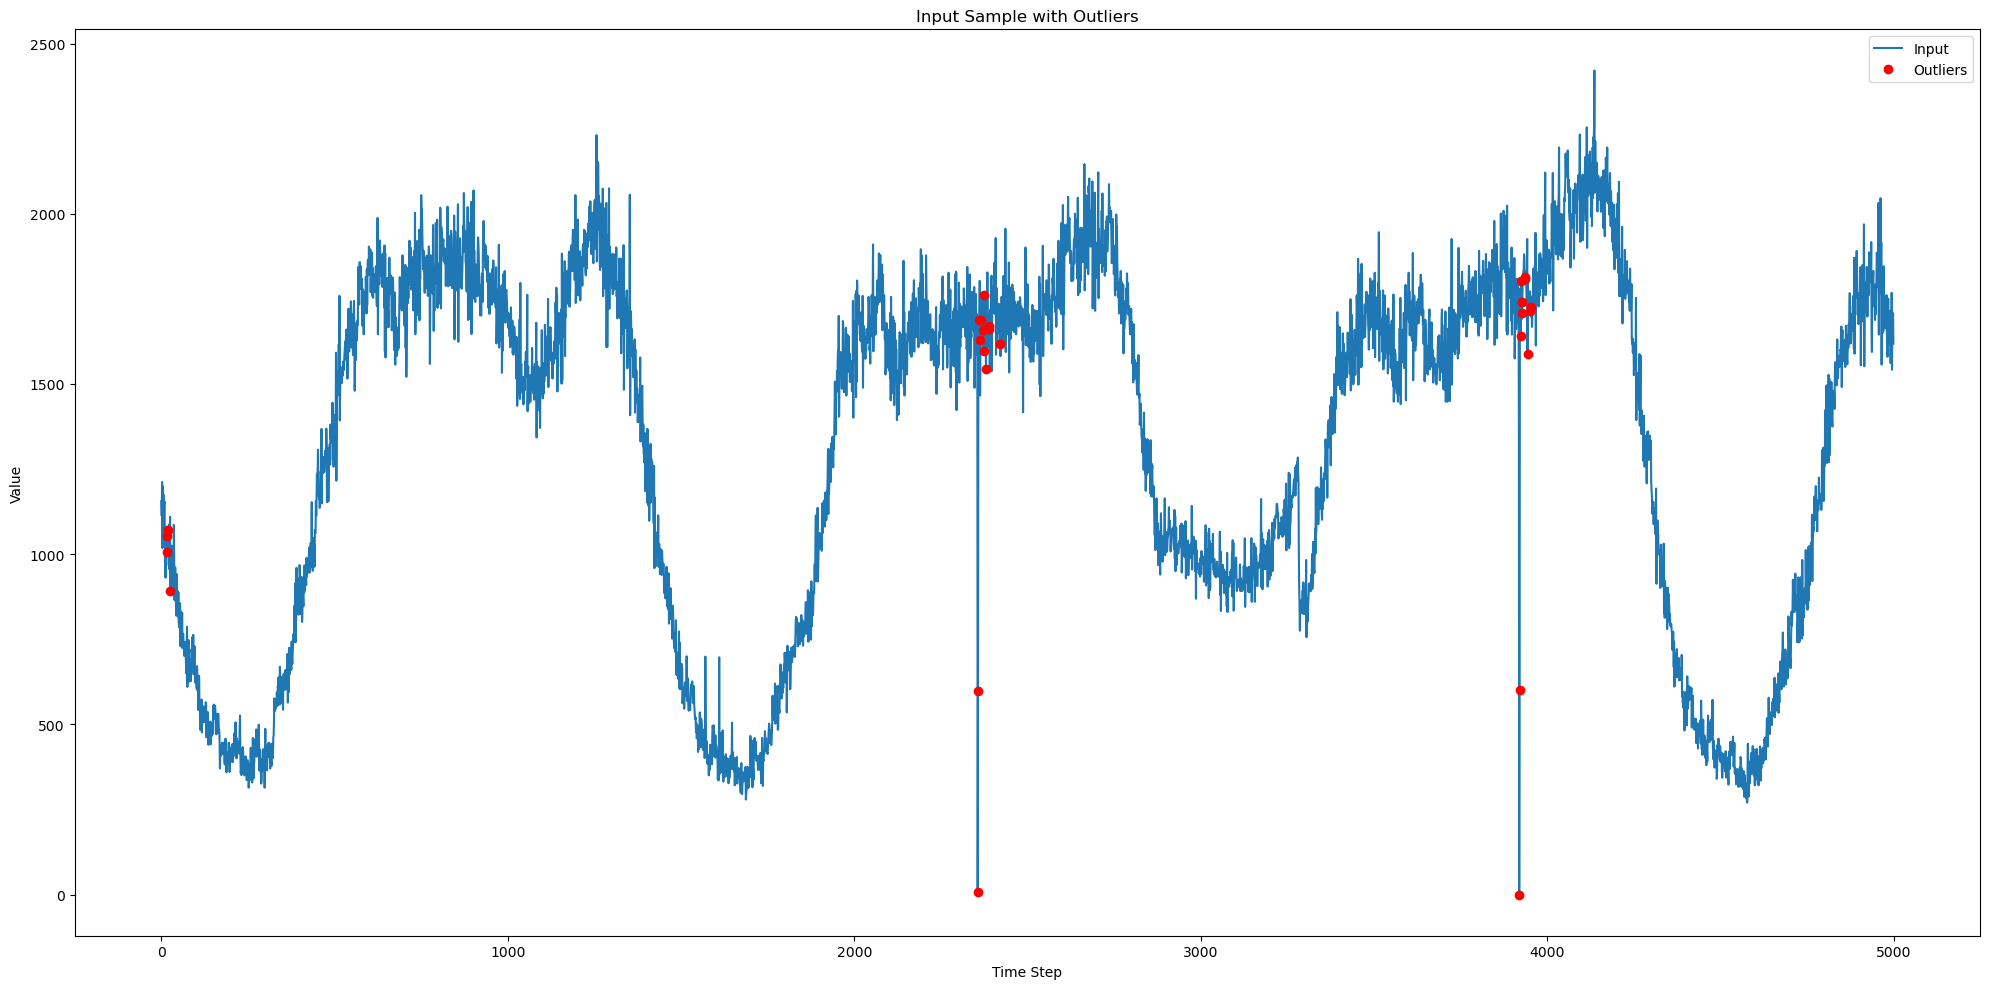

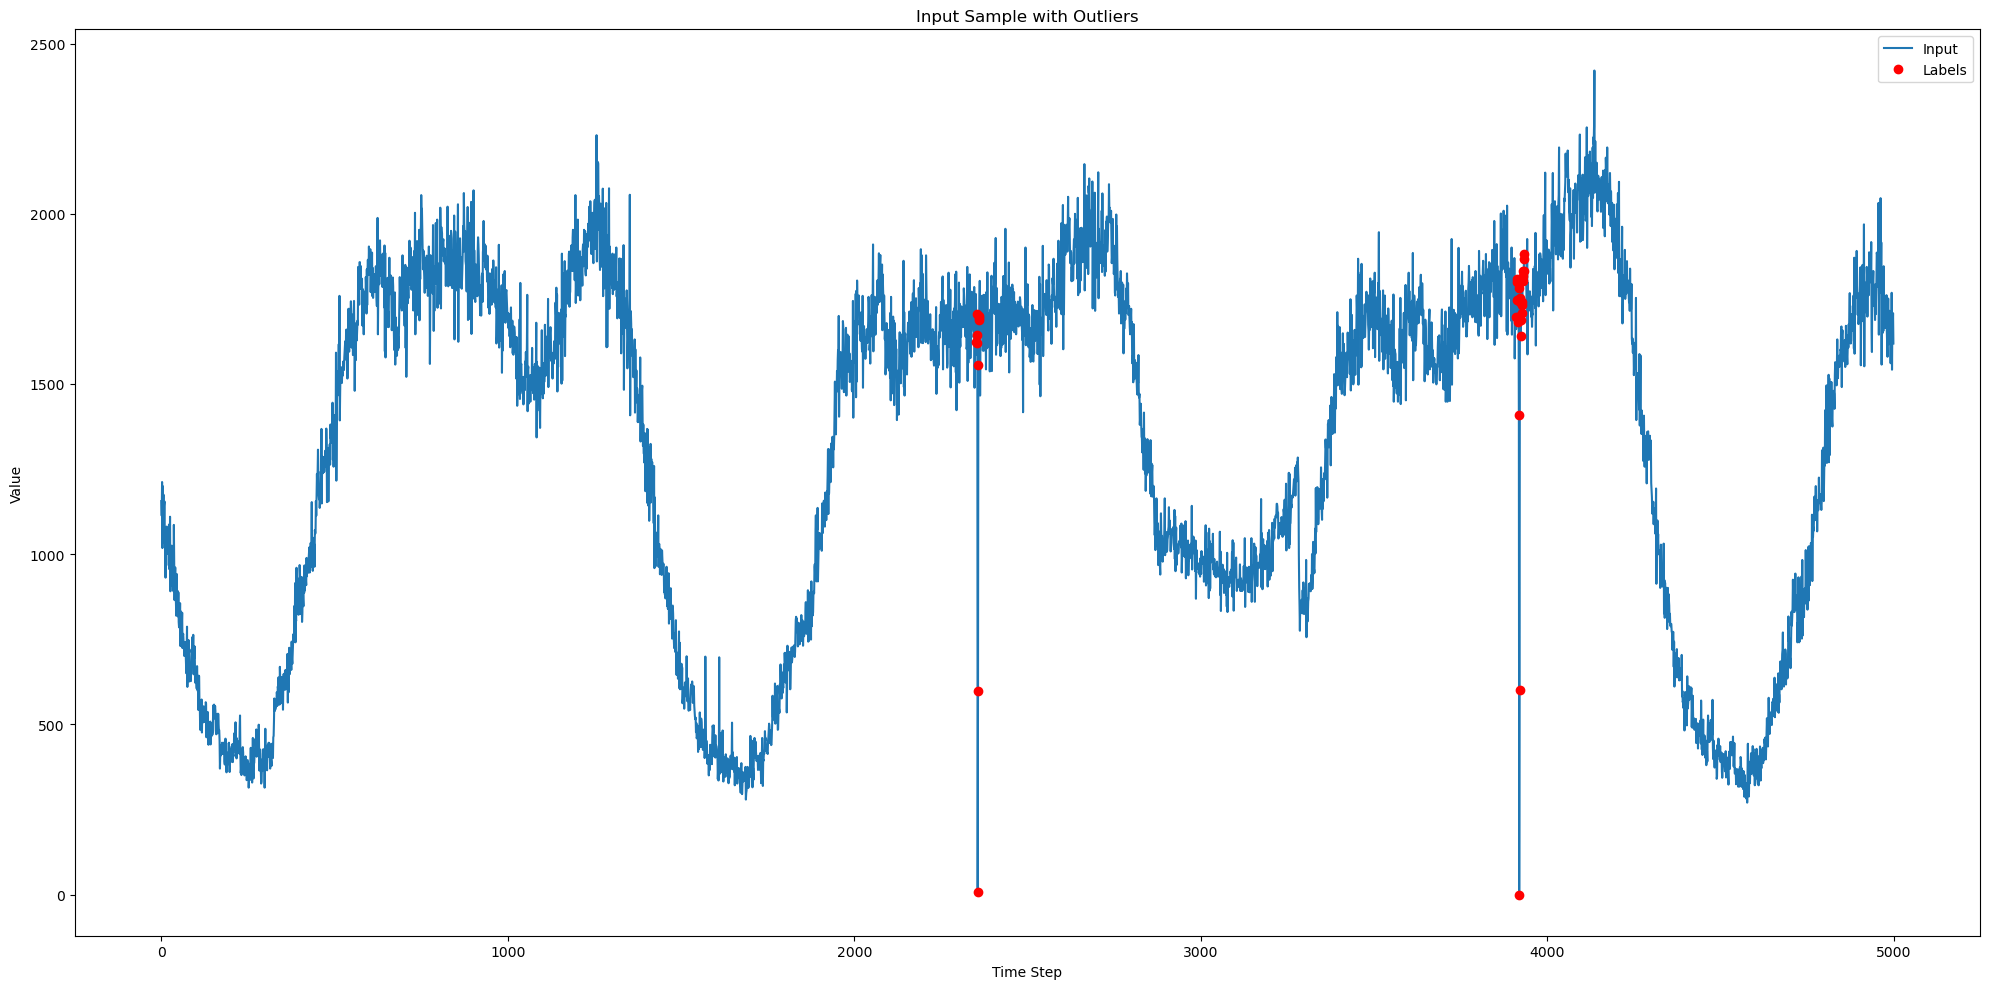

  0%|          | 0/1 [00:01<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      4966
         1.0       0.33      0.26      0.30        34

    accuracy                           0.99      5000
   macro avg       0.66      0.63      0.65      5000
weighted avg       0.99      0.99      0.99      5000



In [22]:
model.eval()
eval_batch_size = config.eval_batch_size

for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
    
    # after sapling random noise, predict using the model to denoise the sample
    with torch.no_grad():
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
        print("eval timesteps", timesteps)
    
        std_data = torch.std(sample)
        noise_level = 0.5
        noise = torch.randn_like(sample) * std_data * noise_level
        noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
        
        noisy_sample = noisy_sample.unsqueeze(-1)
        sample = sample.unsqueeze(-1)
        denoised_sample = model(sample) *2
        # Visualize the input the noisy and denoised data
        
        fig, axs = plt.subplots(3, 1, figsize=(20, 10))
        ax = axs[0]
        ax.plot(sample[0].cpu().numpy())
        ax.set_title("Input Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])
        
        ax = axs[1]
        ax.plot(noisy_sample[0].cpu().numpy())
        ax.set_title("Noisy Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Noisy"])
        
        ax = axs[2]
        ax.plot(denoised_sample[0].cpu().numpy())
        ax.set_title("Denoised Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Denoised"])
        
        plt.tight_layout()
        plt.show()
        
        # predict outlier points in the input sample by comparing the denoised sample with the input sample with a threshold
        threshold = std_data

        outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()

        # before the sample shape was (16, 5000) now it is (16,5000, 1)
        #outliers 
        print("Outliers:", outliers)
        print("labels", labels)
        
        labels = labels.cpu().numpy()
        
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        outlier_indices = np.where(outliers[0] == 1)[0]
        ax.plot(outlier_indices, sample[0][outlier_indices].cpu().numpy(), 'ro', label="Outliers")

        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
                
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        label_indices = np.where(labels[0] == True)[0]
        ax.plot(label_indices, sample[0][label_indices].cpu().numpy(), 'ro', label="Labels")
        
        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        # classification report of outliers vs labels focus on the True positive, True negative, False positive and False negative
        print("Classification report")

        
        
    break


## <font color='green'> Ajout de buit random PyTorch TCN - prediction Image de base :</font> 

Training model...


Epoch 19: 100%|██████████| 1/1 [10:14<00:00, 614.73s/it, loss=6.67e+5, step=19]





 95%|█████████▌| 19/20 [00:55<00:02,  2.96s/it]


eval timesteps tensor([ 92,  72, 399, 187, 250, 353, 411, 299,   5, 244, 277, 136, 123,  93,
         71, 376])


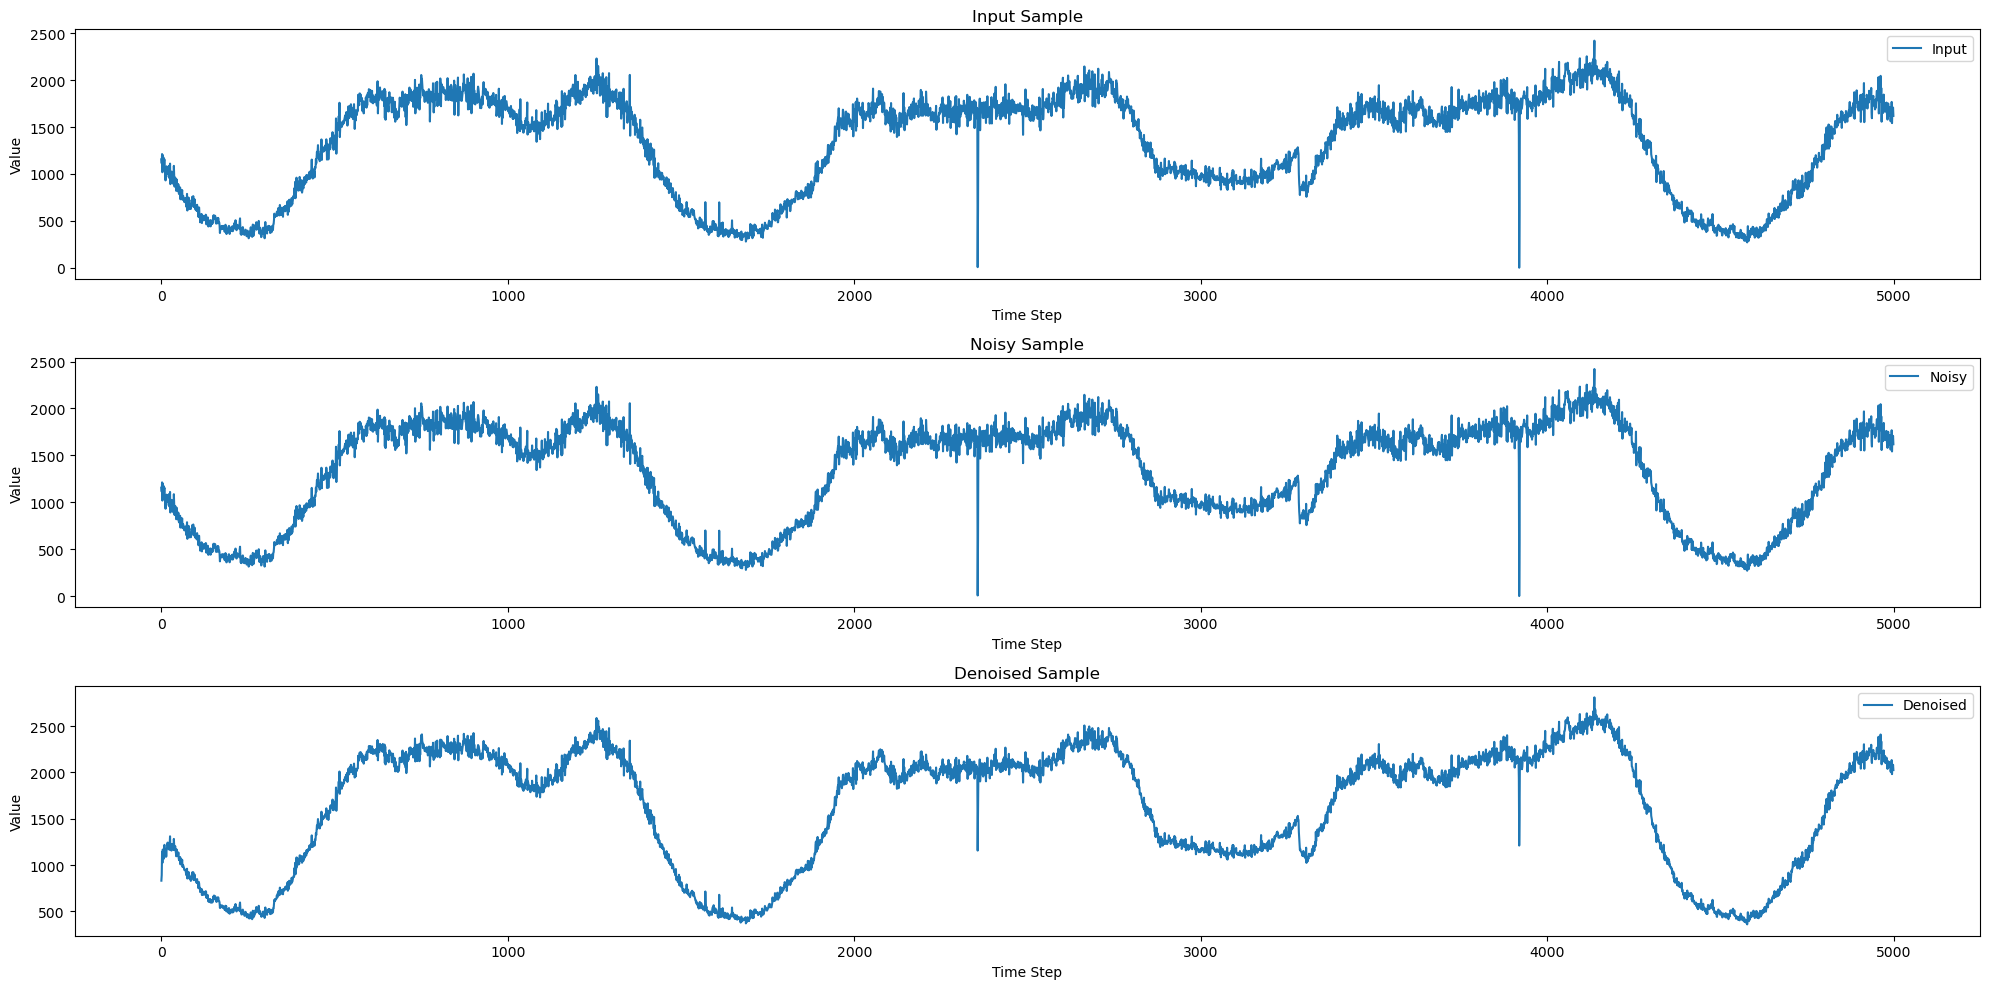

100%|██████████| 20/20 [00:59<00:00,  2.97s/it]


In [11]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

# Continue with the rest of your training loop...

sequence_length = 5000
input_size = 1  # Assuming 1D time series data


# Assuming you have the rest of your code defined already...

# Initialize the new TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[64, 128, 256, 512,256,128,64,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)


# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)
# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Set up dataset and dataloader for test data
test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

# Create dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in tqdm(range(config.num_epochs)):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(dataloader):
        '''if model.input_shape == 'NCL':
            batch = batch.unsqueeze(1)  # Add channel dimension: (batch_size, 1, sequence_length)'''
        #elif model.input_shape == 'NLC':
            #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        #noise = torch.randn_like(batch)
        
        # timesteps from o to num_timesteps
        #timesteps = torch.arange(0, noise_scheduler.num_timesteps).repeat(batch.shape[0], 1)
        
        #timesteps = torch.linspace(0, noise_scheduler.num_timesteps - 1, steps=batch.shape[0]).long()
        std_data = torch.std(batch)
                
        noise = torch.randn_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        #print("timesteps", timesteps)
        
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        noisy = noisy.unsqueeze(-1) 
        # pred noise from the model
        noise_pred = model(noisy)
        
        batch = batch.unsqueeze(-1)
        
        loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
   # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0 :
        model.eval()
        eval_batch_size = config.eval_batch_size

        for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
            
            # after sapling random noise, predict using the model to denoise the sample
            with torch.no_grad():
                timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
                print("eval timesteps", timesteps)
                
                std_data = torch.std(sample)
                noise_level = 0.1
                noise = torch.randn_like(sample)*0.5 #* std_data * noise_level
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = sample.unsqueeze(-1)
                denoised_sample = model(noisy_sample)
                
                # Visualize the input the noisy and denoised data
                
                fig, axs = plt.subplots(3, 1, figsize=(20, 10))
                
                ax = axs[0]
                ax.plot(sample[0].cpu().numpy())
                ax.set_title("Input Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Input"])
                
                
                ax = axs[1]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title("Noisy Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Noisy"])
                
                ax = axs[2]
                ax.plot(denoised_sample[0].cpu().numpy())
                ax.set_title("Denoised Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Denoised"])
                
                plt.tight_layout()
                plt.show()
                
            break
            

        
    progress_bar.close()


  0%|          | 0/1 [00:00<?, ?it/s]

eval timesteps tensor([421, 264, 437, 374, 350, 228, 163, 433,  19,  10, 263, 399,  99,  16,
        149, 238])


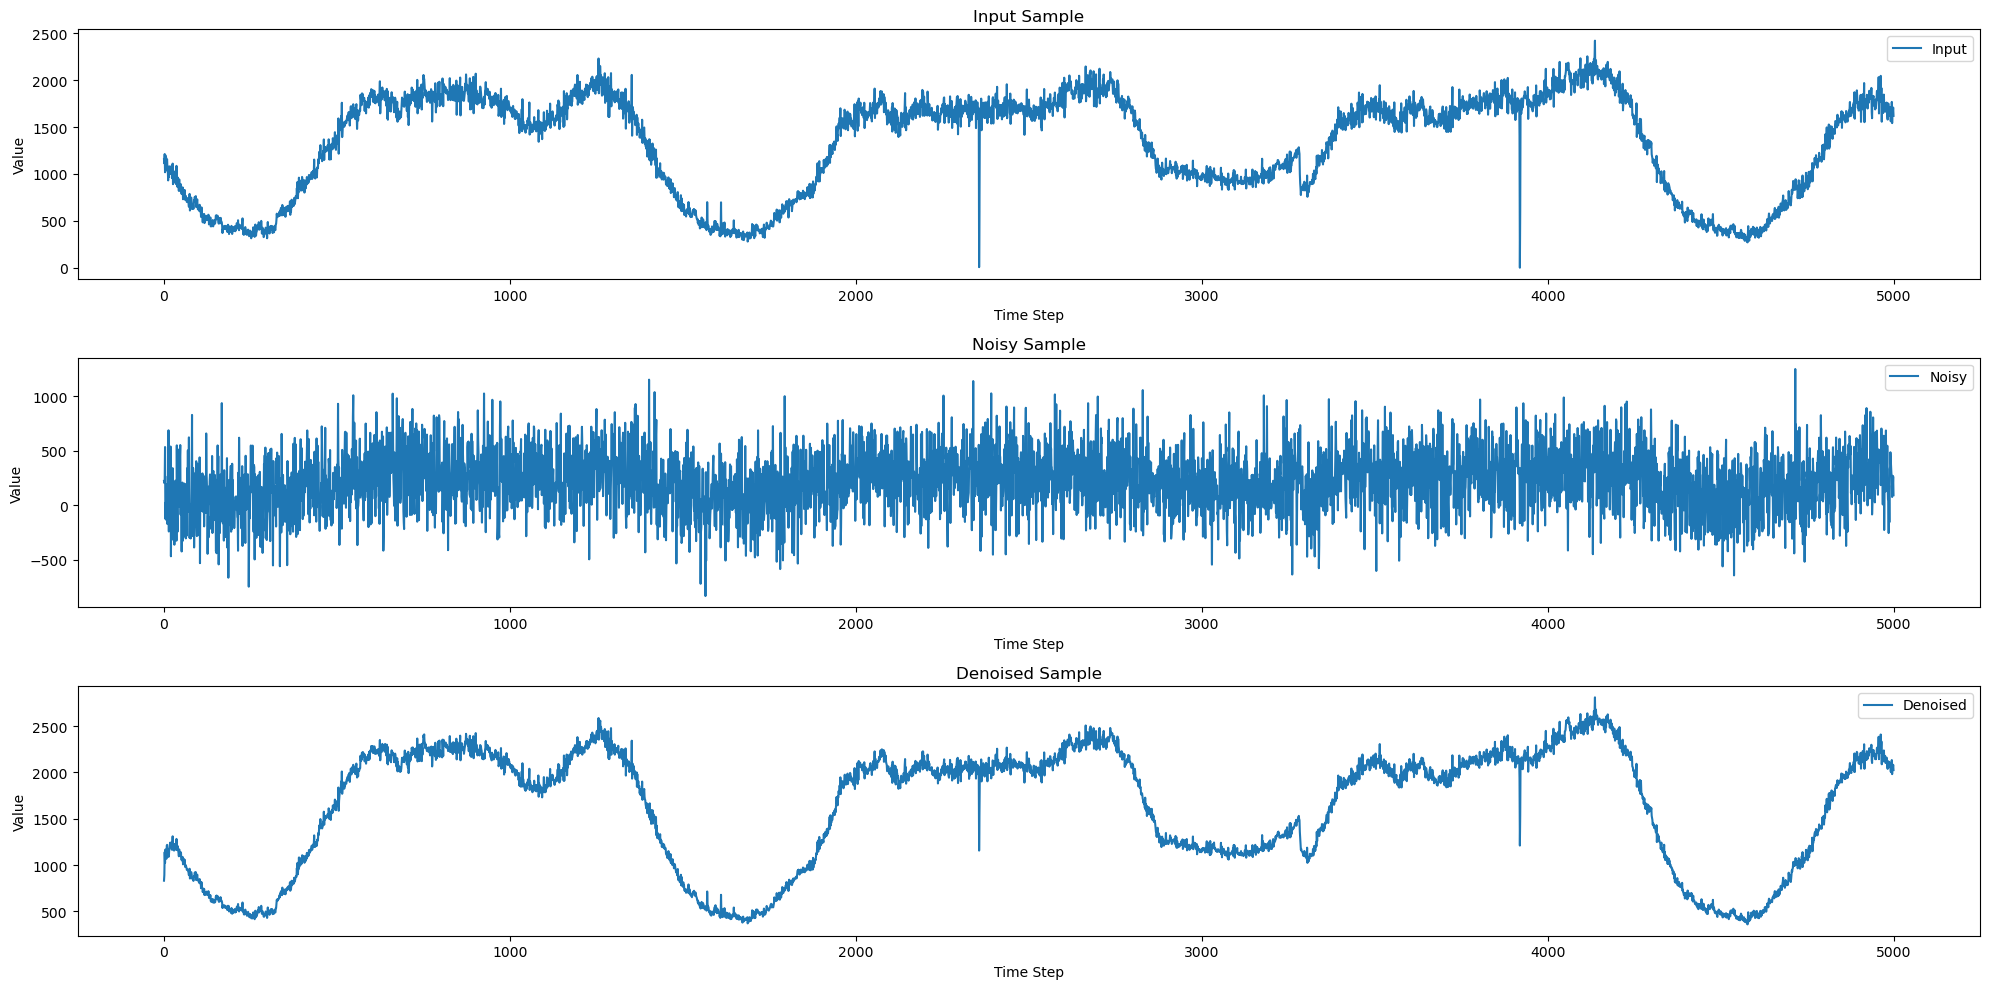

Outliers: [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]
labels tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


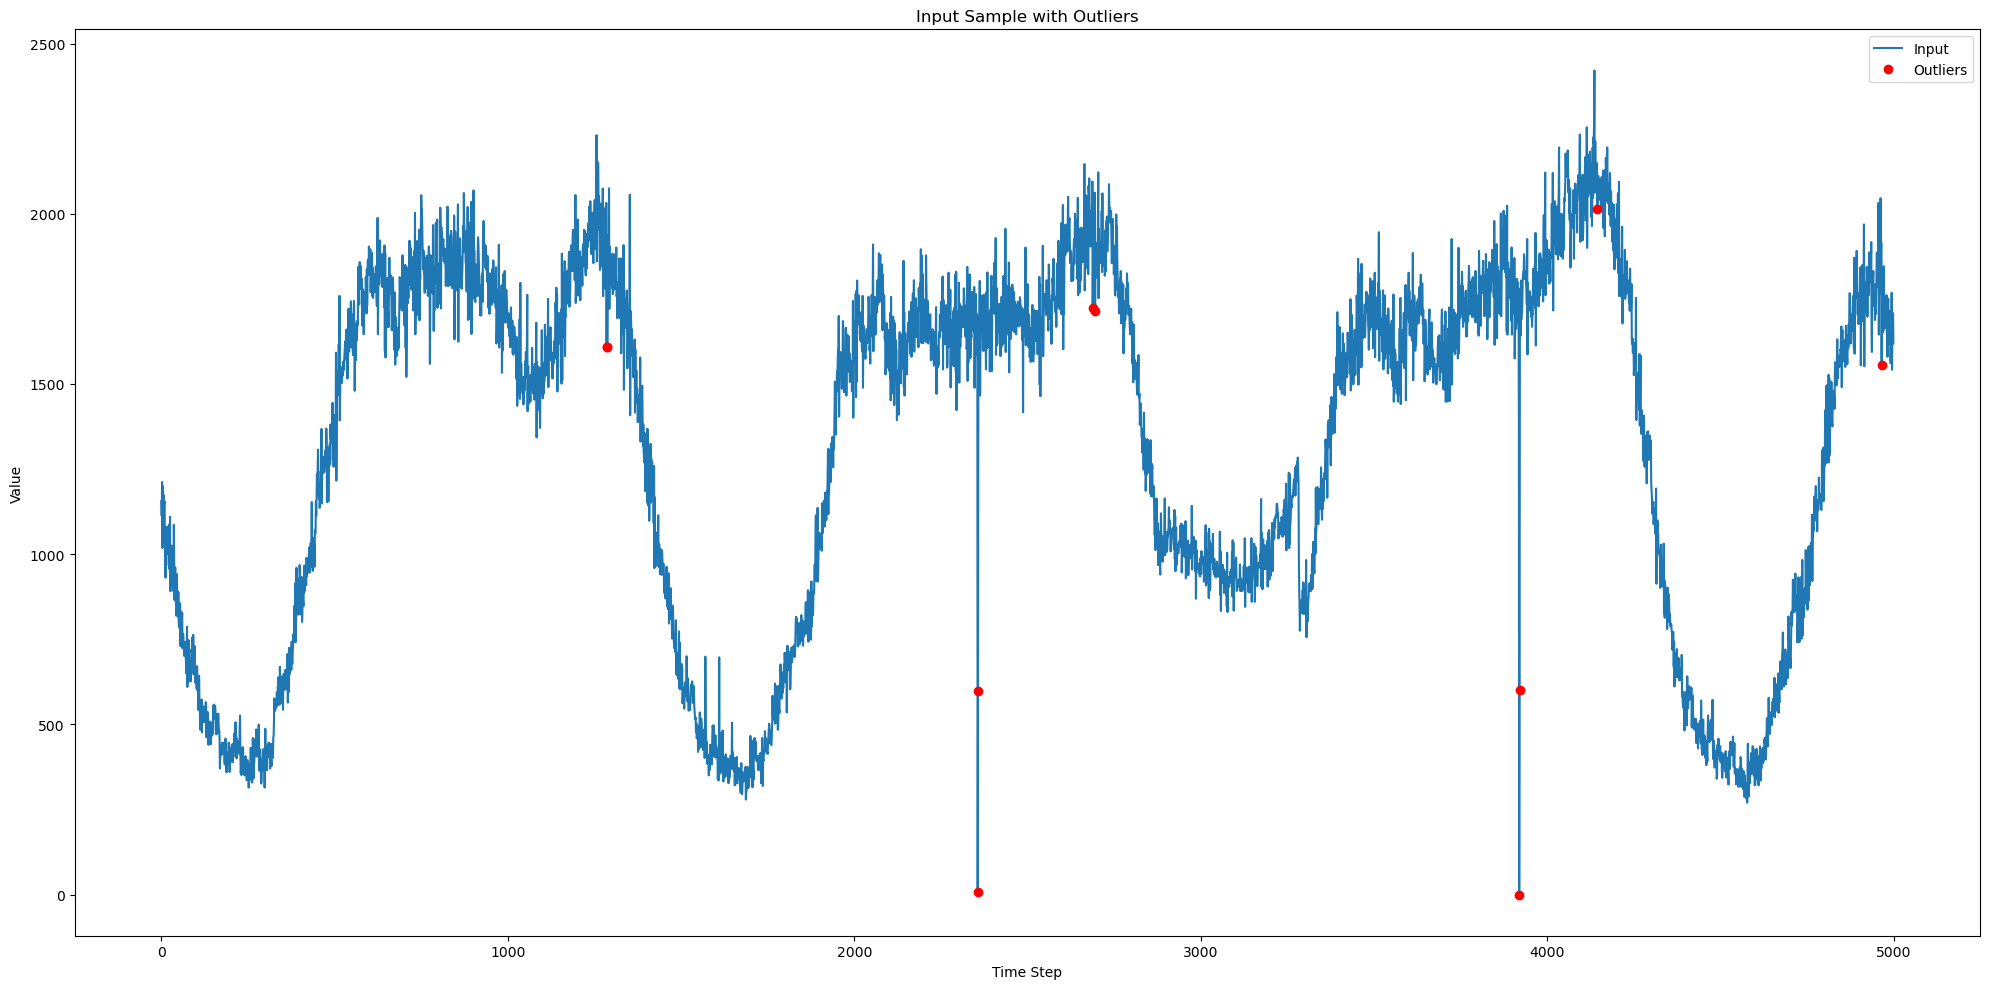

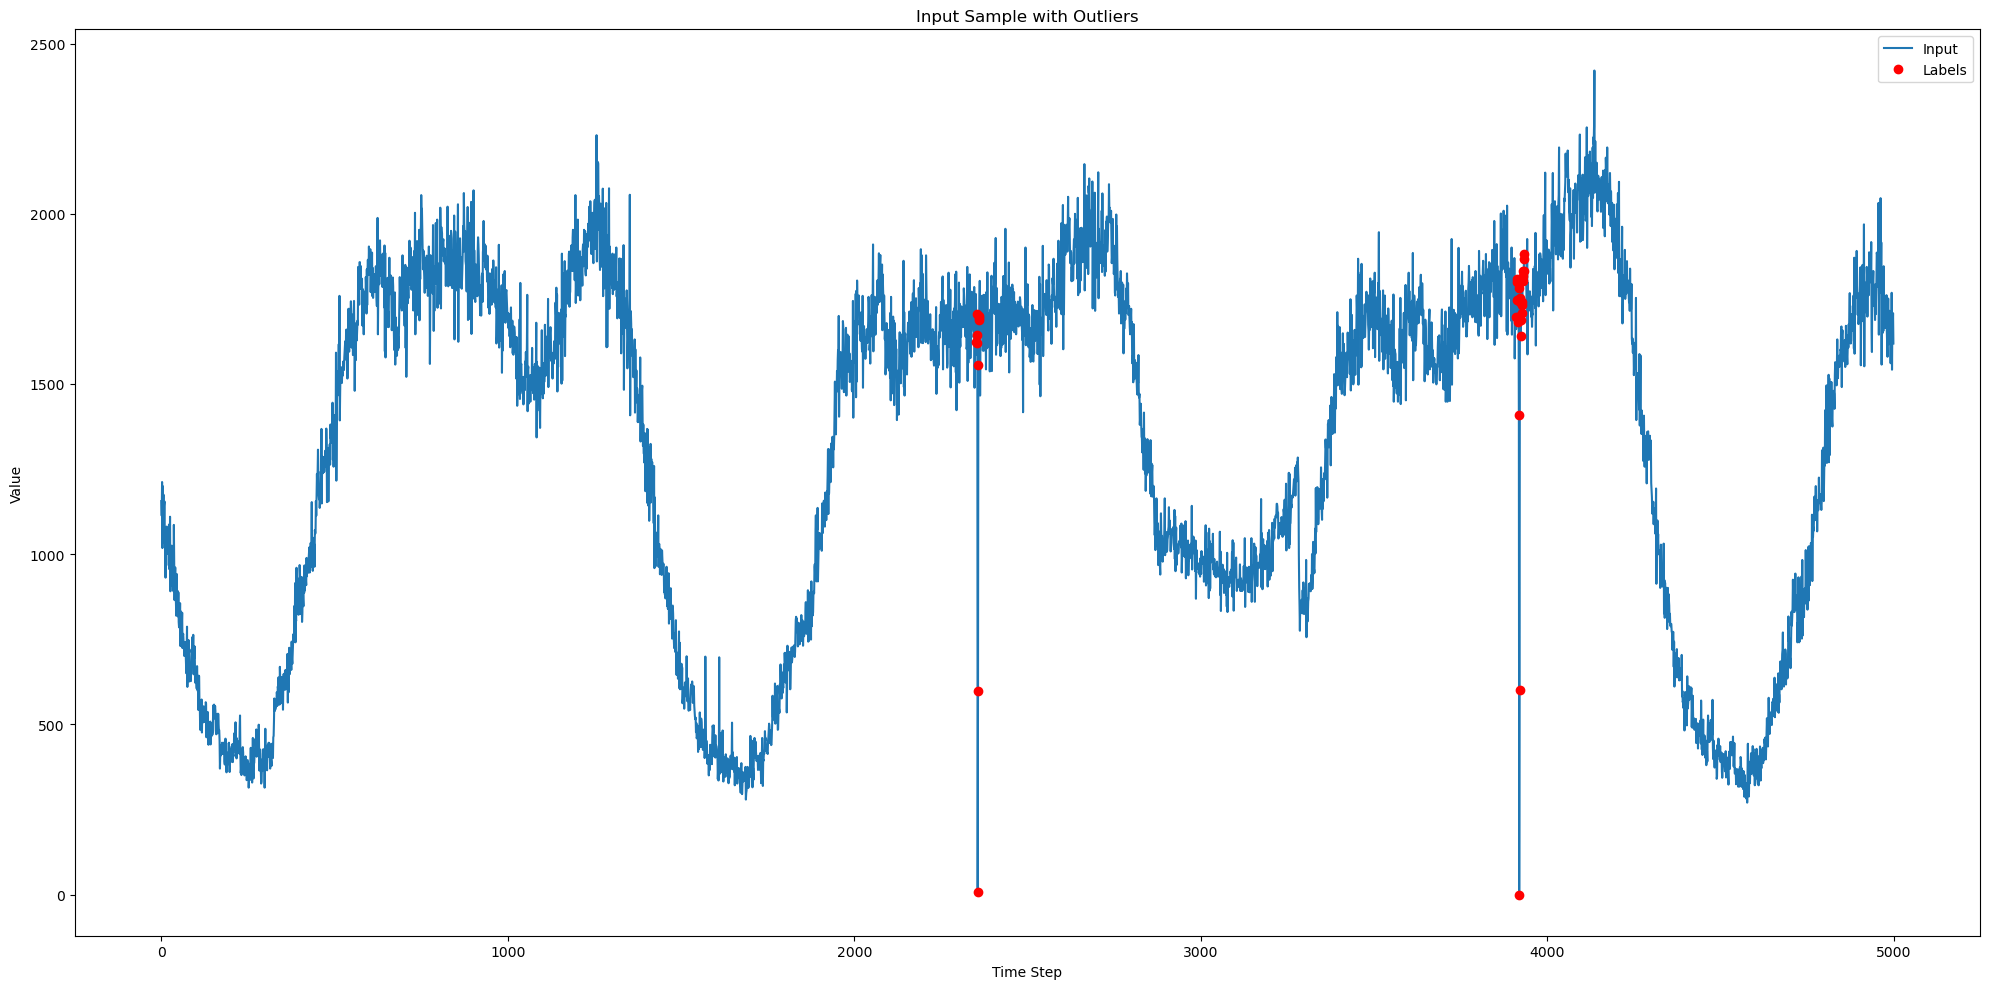

  0%|          | 0/1 [00:01<?, ?it/s]

Classification report


In [13]:
model.eval()
eval_batch_size = config.eval_batch_size

for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
    
    # after sapling random noise, predict using the model to denoise the sample
    with torch.no_grad():
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
        print("eval timesteps", timesteps)
    
        std_data = torch.std(sample)
        noise_level = 0.5
        noise = torch.randn_like(sample) * std_data * noise_level
        noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
        
        noisy_sample = noisy_sample.unsqueeze(-1)
        sample = sample.unsqueeze(-1)
        denoised_sample = model(sample) #*2
        # Visualize the input the noisy and denoised data
        
        fig, axs = plt.subplots(3, 1, figsize=(20, 10))
        ax = axs[0]
        ax.plot(sample[0].cpu().numpy())
        ax.set_title("Input Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])
        
        ax = axs[1]
        ax.plot(noisy_sample[0].cpu().numpy())
        ax.set_title("Noisy Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Noisy"])
        
        ax = axs[2]
        ax.plot(denoised_sample[0].cpu().numpy())
        ax.set_title("Denoised Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Denoised"])
        
        plt.tight_layout()
        plt.show()
        
        # predict outlier points in the input sample by comparing the denoised sample with the input sample with a threshold
        threshold = std_data

        outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()

        # before the sample shape was (16, 5000) now it is (16,5000, 1)
        #outliers 
        print("Outliers:", outliers)
        print("labels", labels)
        
        labels = labels.cpu().numpy()
        
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        outlier_indices = np.where(outliers[0] == 1)[0]
        ax.plot(outlier_indices, sample[0][outlier_indices].cpu().numpy(), 'ro', label="Outliers")

        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
                
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        label_indices = np.where(labels[0] == True)[0]
        ax.plot(label_indices, sample[0][label_indices].cpu().numpy(), 'ro', label="Labels")
        
        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        # classification report of outliers vs labels focus on the True positive, True negative, False positive and False negative
        print("Classification report")

        
        
    break


## <font color='green'> Ajout incremental PyTorch TCN - prediction Image de base - simplex noise :</font> 

Training model...


  0%|          | 0/20 [00:00<?, ?it/s]

timesteps tensor([ 13,  58,  87, 103, 105, 214, 231, 241, 252, 292, 393, 654, 711, 740,
        848, 985])


noise_pred torch.Size([16, 5000, 1])


  5%|▌         | 1/20 [00:03<01:09,  3.65s/it]

timesteps tensor([ 18, 110, 141, 153, 274, 276, 335, 395, 419, 448, 619, 794, 871, 876,
        878, 921])
noise_pred torch.Size([16, 5000, 1])


 10%|█         | 2/20 [00:07<01:05,  3.67s/it]

timesteps tensor([195, 278, 333, 449, 450, 459, 473, 538, 555, 629, 655, 687, 780, 798,
        802, 989])
noise_pred torch.Size([16, 5000, 1])


 15%|█▌        | 3/20 [00:10<01:02,  3.65s/it]

timesteps tensor([ 55, 136, 164, 252, 291, 317, 478, 539, 603, 643, 647, 693, 744, 827,
        944, 978])
noise_pred torch.Size([16, 5000, 1])


 20%|██        | 4/20 [00:14<00:58,  3.66s/it]

timesteps tensor([  7,  68, 138, 197, 204, 260, 266, 434, 440, 463, 471, 530, 718, 819,
        863, 933])
noise_pred torch.Size([16, 5000, 1])


 25%|██▌       | 5/20 [00:18<00:54,  3.66s/it]

timesteps tensor([ 71,  76, 117, 172, 275, 281, 612, 631, 691, 701, 720, 735, 885, 890,
        978, 999])
noise_pred torch.Size([16, 5000, 1])


 30%|███       | 6/20 [00:21<00:51,  3.66s/it]

timesteps tensor([ 67, 201, 251, 328, 395, 451, 602, 619, 682, 747, 774, 778, 795, 883,
        965, 979])
noise_pred torch.Size([16, 5000, 1])


 35%|███▌      | 7/20 [00:25<00:47,  3.67s/it]

timesteps tensor([  7,  17,  24,  89,  98, 165, 260, 319, 361, 489, 524, 575, 725, 731,
        740, 827])
noise_pred torch.Size([16, 5000, 1])


 40%|████      | 8/20 [00:29<00:43,  3.66s/it]

timesteps tensor([167, 183, 252, 291, 454, 467, 525, 525, 526, 530, 703, 724, 755, 774,
        843, 912])
noise_pred torch.Size([16, 5000, 1])


 45%|████▌     | 9/20 [00:32<00:40,  3.66s/it]

timesteps tensor([ 15,  31, 134, 143, 243, 414, 519, 552, 568, 612, 803, 855, 859, 893,
        897, 971])
noise_pred torch.Size([16, 5000, 1])


 50%|█████     | 10/20 [00:36<00:36,  3.66s/it]

timesteps tensor([245, 269, 271, 421, 453, 474, 485, 579, 682, 684, 695, 702, 721, 832,
        986, 994])
noise_pred torch.Size([16, 5000, 1])


 55%|█████▌    | 11/20 [00:40<00:33,  3.68s/it]

timesteps tensor([108, 189, 241, 265, 283, 316, 329, 358, 369, 432, 675, 781, 873, 897,
        946, 980])
noise_pred torch.Size([16, 5000, 1])


 60%|██████    | 12/20 [00:44<00:29,  3.69s/it]

timesteps tensor([ 88,  93, 100, 156, 241, 271, 283, 286, 493, 500, 621, 624, 635, 899,
        910, 963])
noise_pred torch.Size([16, 5000, 1])


 65%|██████▌   | 13/20 [00:47<00:25,  3.70s/it]

timesteps tensor([ 24,  46, 165, 192, 193, 258, 259, 442, 462, 485, 500, 576, 715, 800,
        897, 965])
noise_pred torch.Size([16, 5000, 1])


 70%|███████   | 14/20 [00:51<00:22,  3.70s/it]

timesteps tensor([ 48, 151, 313, 382, 580, 622, 651, 690, 745, 802, 850, 859, 885, 927,
        937, 989])
noise_pred torch.Size([16, 5000, 1])


 75%|███████▌  | 15/20 [00:55<00:18,  3.70s/it]

timesteps tensor([ 26, 139, 201, 261, 282, 293, 337, 345, 348, 519, 612, 650, 726, 774,
        844, 907])
noise_pred torch.Size([16, 5000, 1])


 80%|████████  | 16/20 [00:58<00:14,  3.69s/it]

timesteps tensor([116, 132, 165, 214, 251, 270, 395, 411, 444, 459, 521, 553, 582, 669,
        819, 824])
noise_pred torch.Size([16, 5000, 1])


 85%|████████▌ | 17/20 [01:02<00:11,  3.69s/it]

timesteps tensor([  4,  38,  84, 134, 160, 175, 236, 240, 609, 649, 716, 720, 883, 899,
        965, 971])
noise_pred torch.Size([16, 5000, 1])


 90%|█████████ | 18/20 [01:06<00:07,  3.69s/it]

timesteps tensor([ 34,  54,  62, 107, 208, 222, 253, 344, 360, 367, 418, 522, 537, 680,
        897, 929])
noise_pred torch.Size([16, 5000, 1])


 95%|█████████▌| 19/20 [01:09<00:03,  3.69s/it]

timesteps tensor([ 26,  38, 120, 140, 153, 309, 427, 504, 515, 659, 771, 782, 865, 867,
        894, 990])
noise_pred torch.Size([16, 5000, 1])


eval timesteps tensor([669, 845, 463, 453, 742,  65, 817, 511, 225,  52,  46, 112,   2, 516,
        586, 829])


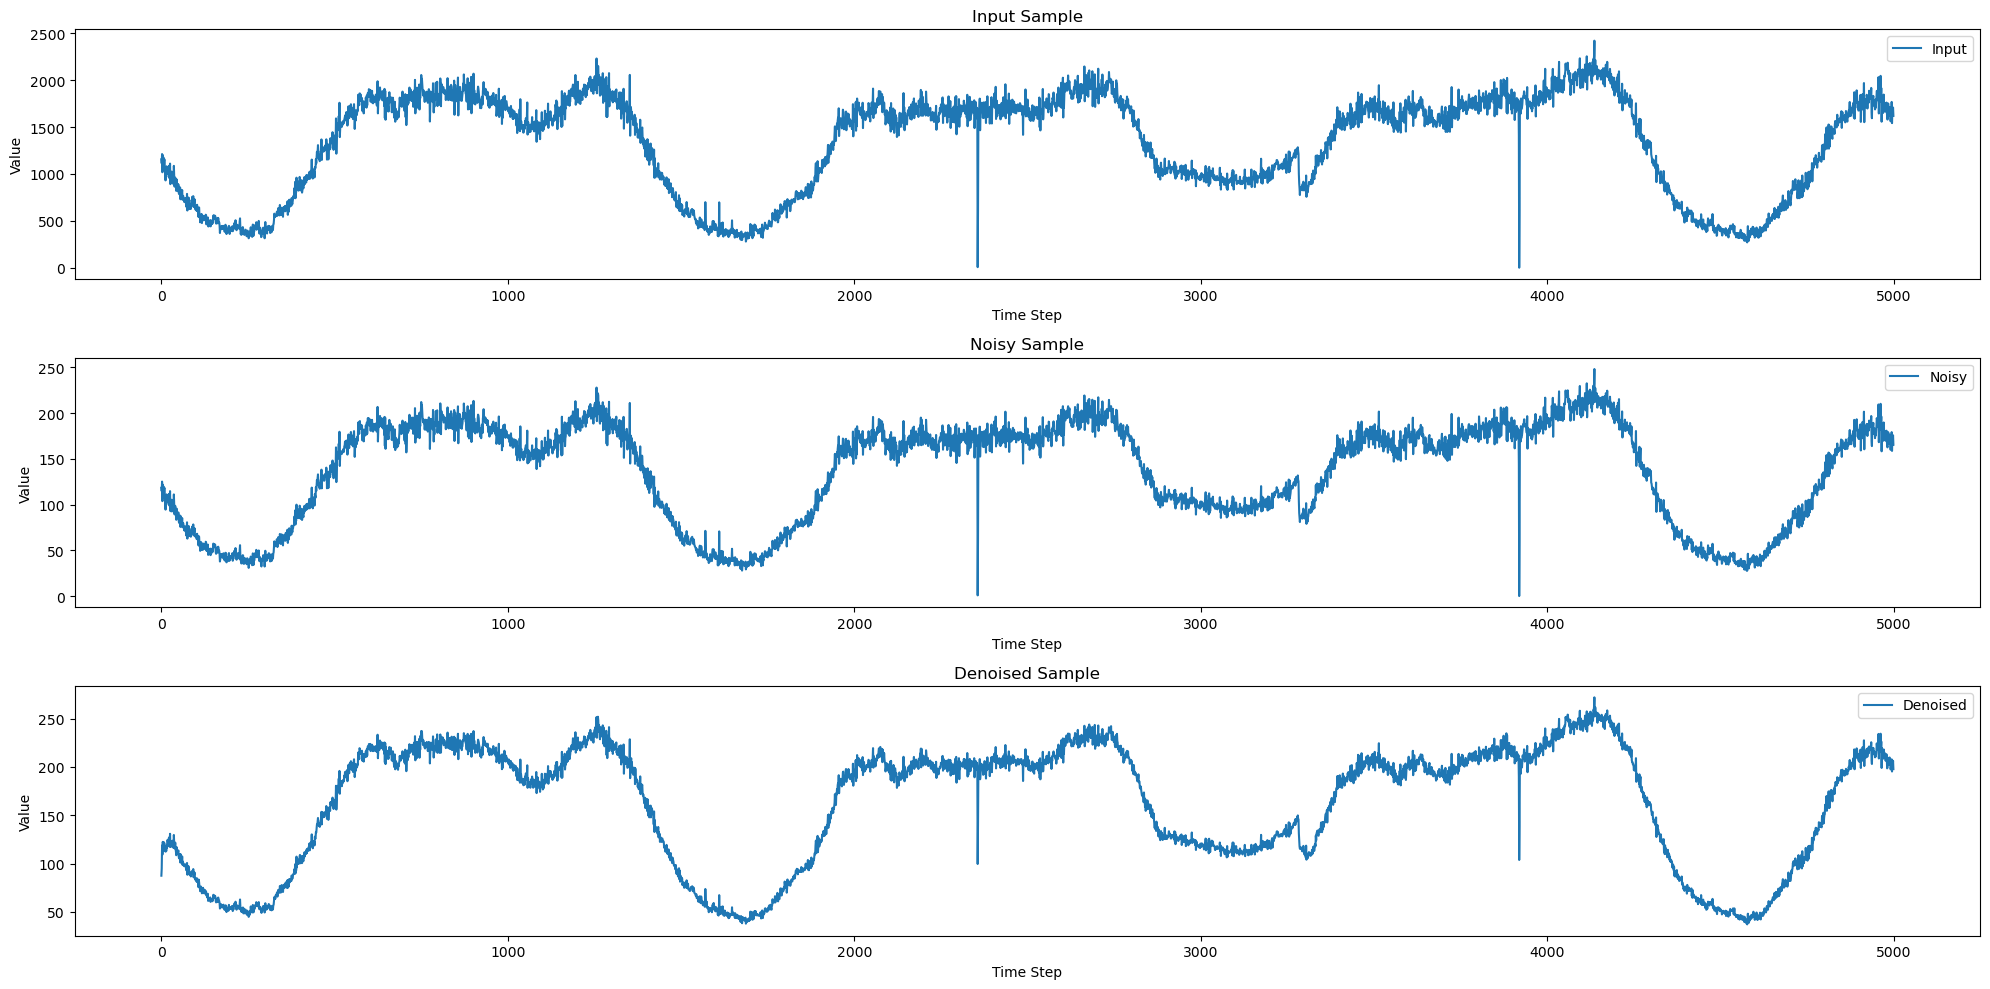

100%|██████████| 20/20 [01:14<00:00,  3.73s/it]


In [37]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

# Continue with the rest of your training loop...

sequence_length = 5000
input_size = 1  # Assuming 1D time series data


# Assuming you have the rest of your code defined already...

# Initialize the new TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[64, 128, 256, 512,256,128,64,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)


# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)
# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Set up dataset and dataloader for test data
test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

# Create dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

#================================================================================================


noise_scheduler = SimplexNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in tqdm(range(config.num_epochs)):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(dataloader):

        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        # order timesteps 
        timesteps = timesteps.sort()[0]
        
        print('timesteps', timesteps)
        
        noise = noise_scheduler.generate_simplex_noise_like(batch)
        
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        noisy = noisy.unsqueeze(-1) 
        
        # pred noise from the model
        noise_pred = model(noisy)
        
        print("noise_pred", noise_pred.shape)
        batch = batch.unsqueeze(-1)
        
        loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
   # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0 :
        model.eval()
        eval_batch_size = config.eval_batch_size

        for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
            
            # after sapling random noise, predict using the model to denoise the sample
            with torch.no_grad():
                timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
                print("eval timesteps", timesteps)
                
                std_data = torch.std(sample)
                noise_level = 0.1
                noise = torch.randn_like(sample) #* std_data * noise_level
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = noisy_sample.unsqueeze(-1)
                denoised_sample = model(noisy_sample)
                
                # Visualize the input the noisy and denoised data
                
                fig, axs = plt.subplots(3, 1, figsize=(20, 10))
                
                ax = axs[0]
                ax.plot(sample[0].cpu().numpy())
                ax.set_title("Input Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Input"])
                
                ax = axs[1]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title("Noisy Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Noisy"])
                
                ax = axs[2]
                ax.plot(denoised_sample[0].cpu().numpy())
                ax.set_title("Denoised Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Denoised"])
                
                plt.tight_layout()
                plt.show()
                
            break
            

        
    progress_bar.close()


  0%|          | 0/1 [00:00<?, ?it/s]

std_data tensor(527.8704)
eval timesteps tensor([752, 632, 638,  36, 857, 871, 124,  79, 598, 894, 624, 963, 327, 935,
        250, 181])


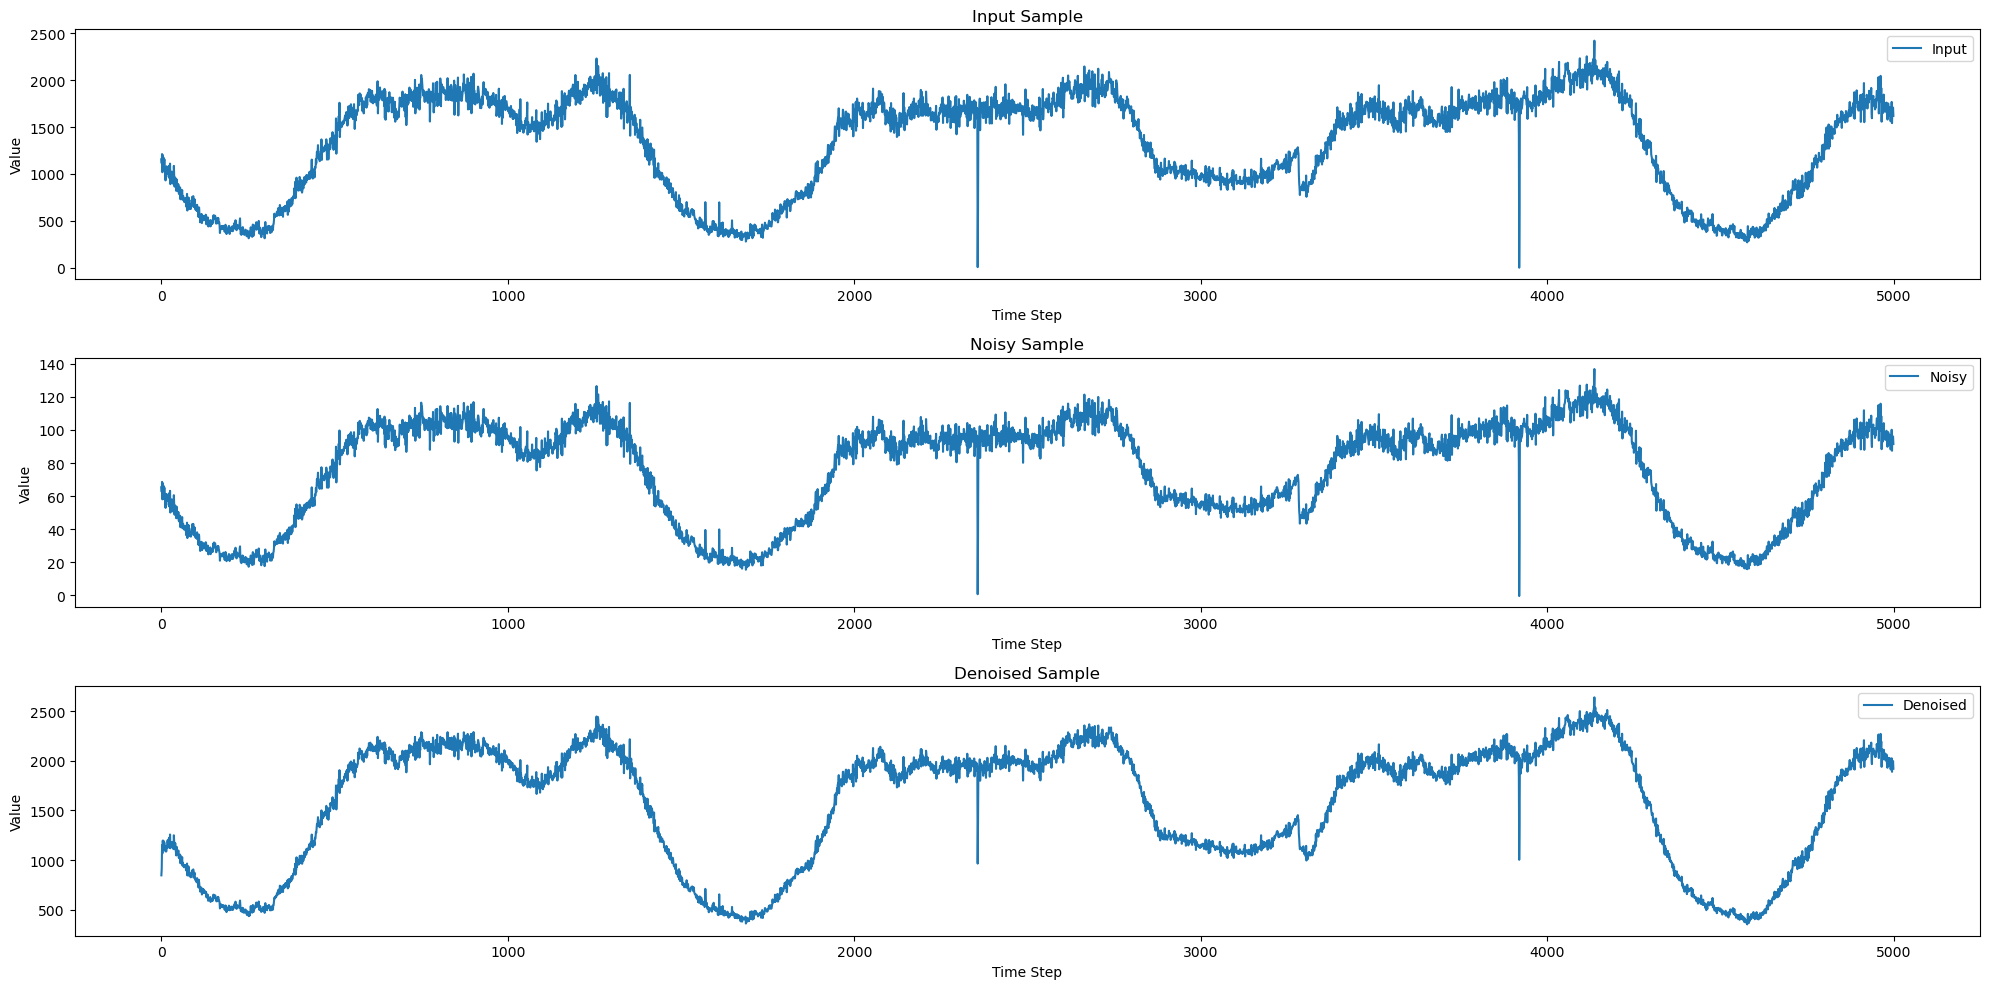

Outliers: [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[ True]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[ True]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[ True]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]
labels tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


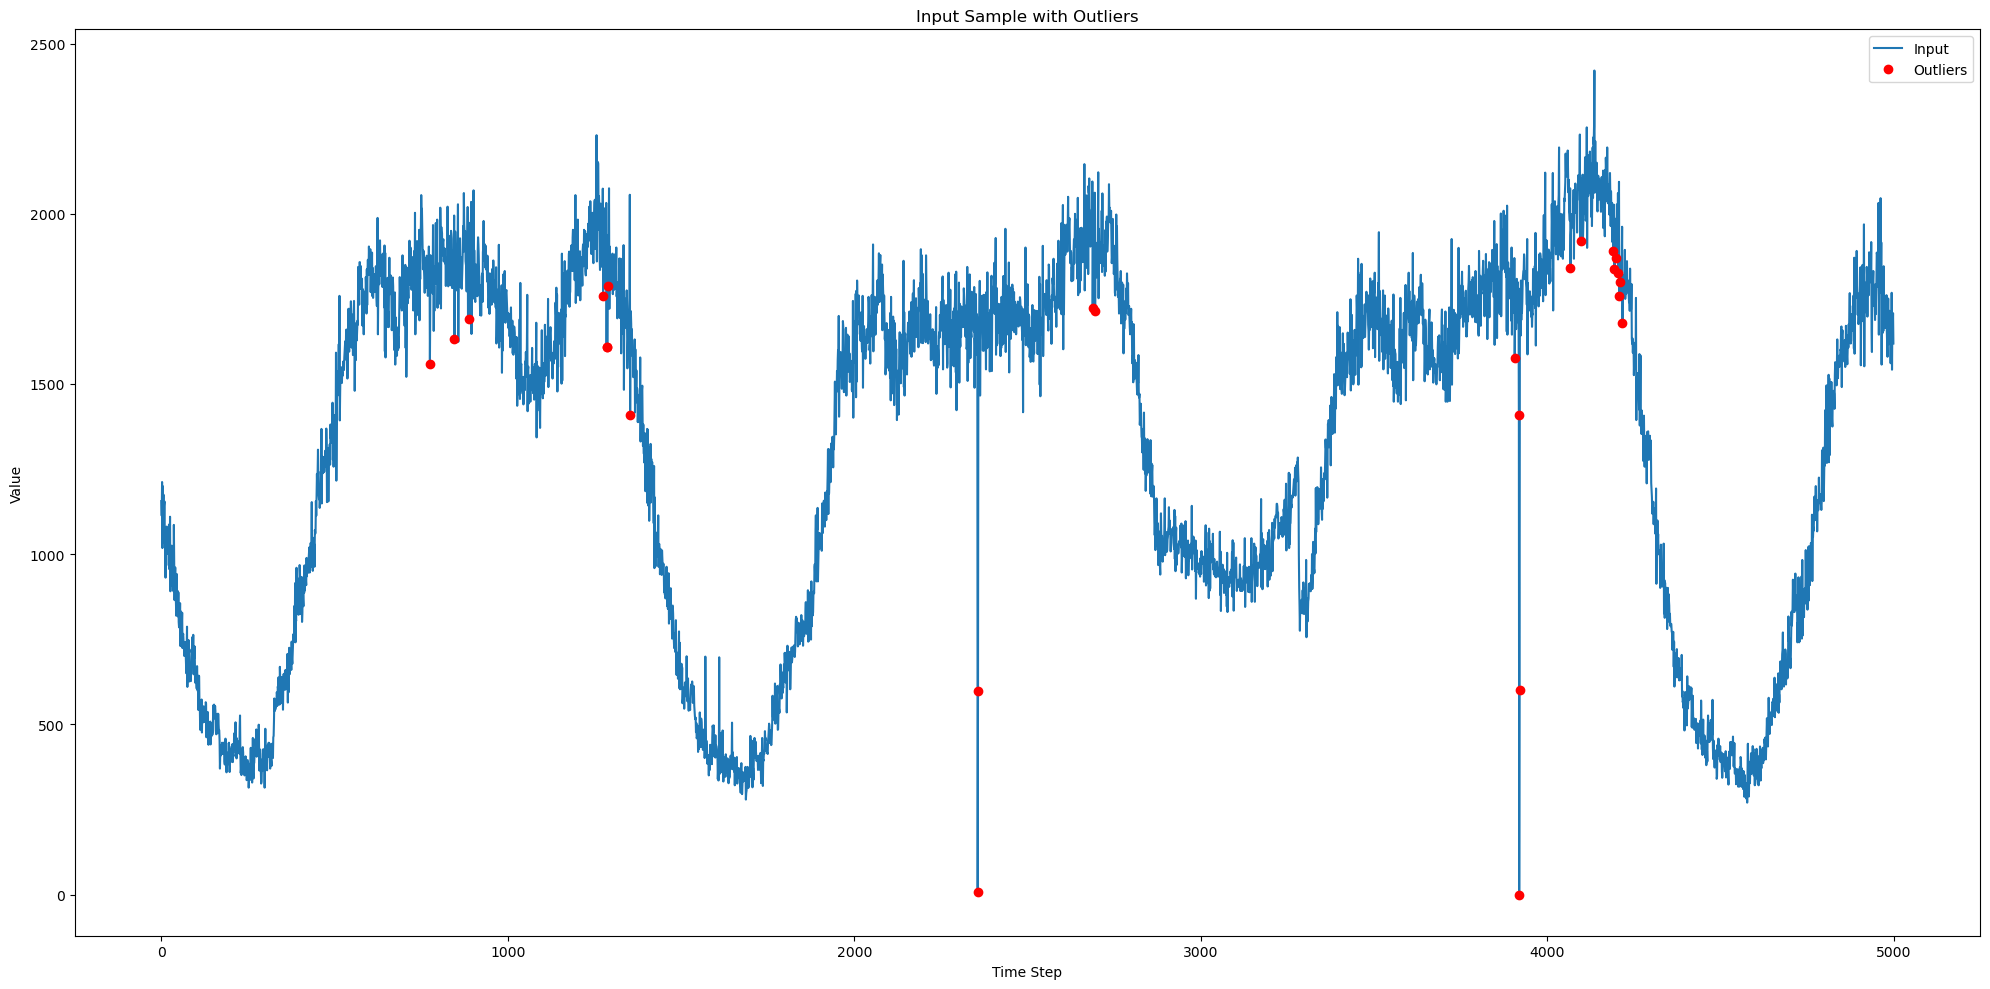

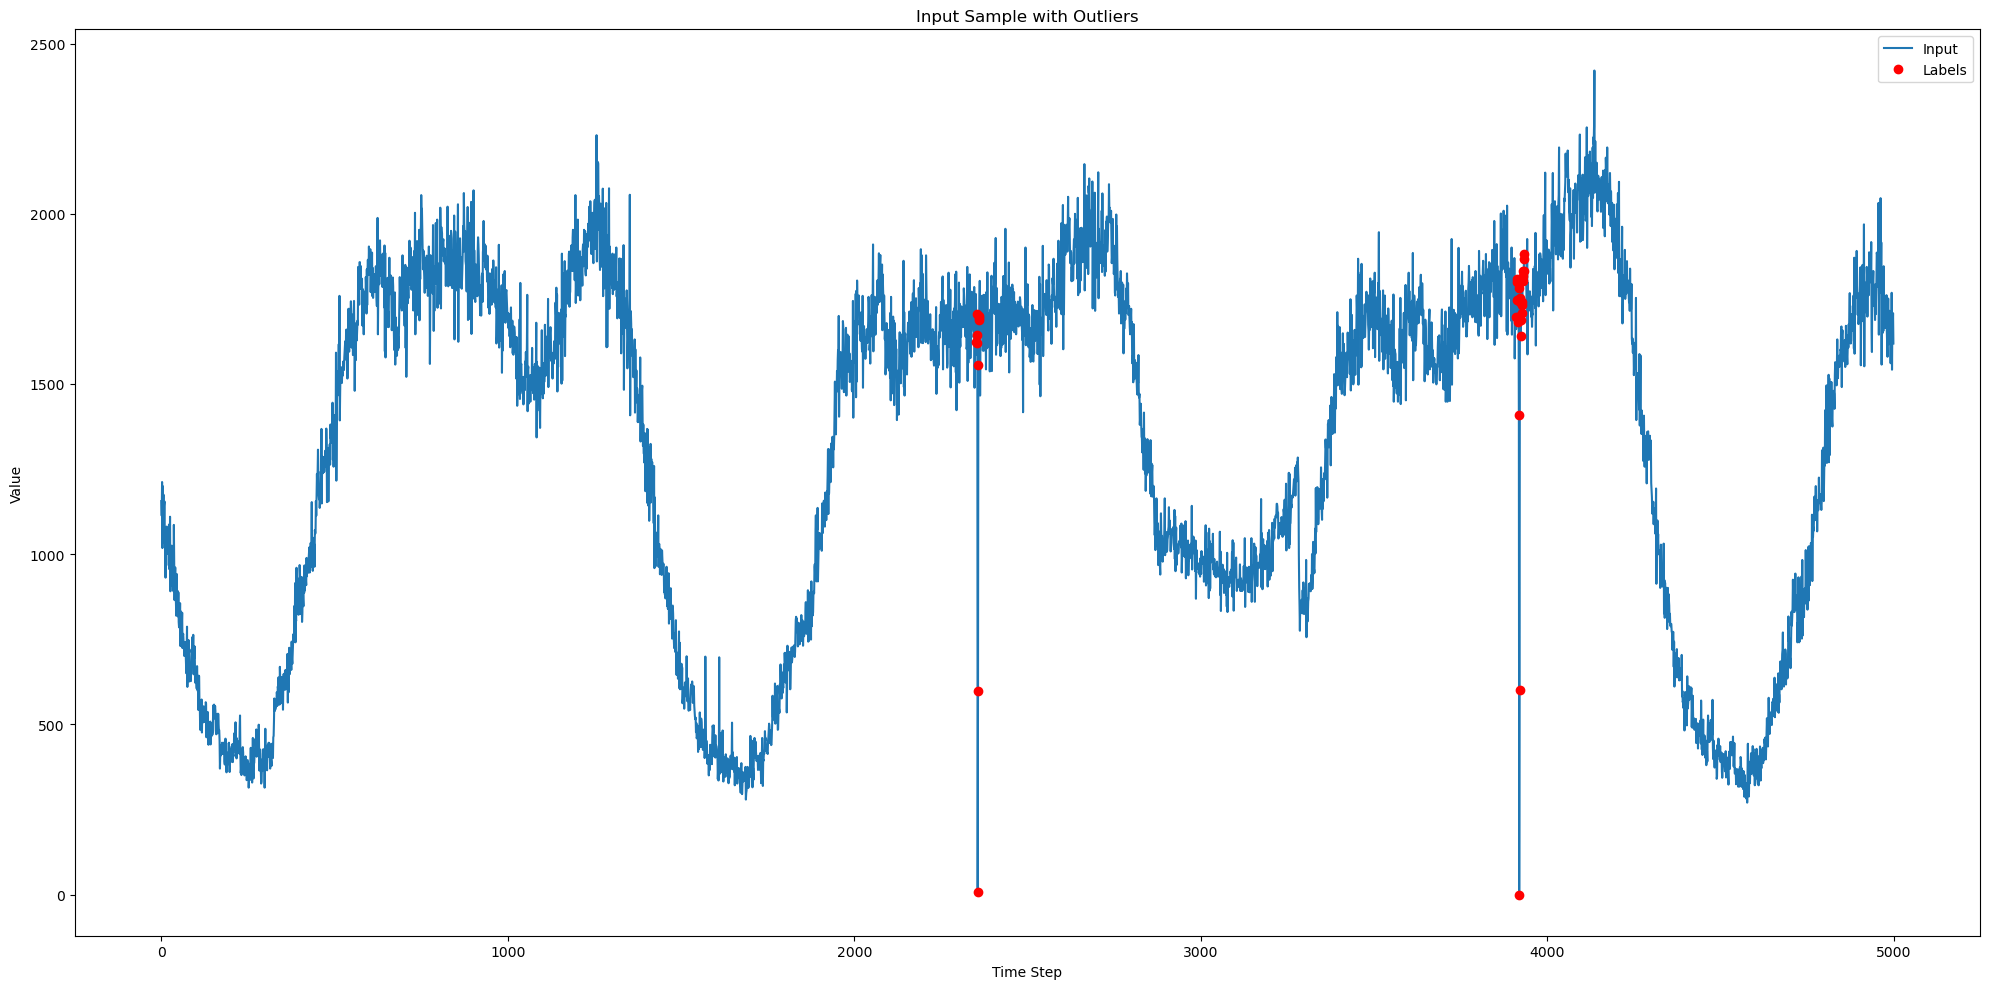

  0%|          | 0/1 [00:03<?, ?it/s]

Classification report


In [45]:
model.eval()
eval_batch_size = config.eval_batch_size

for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
    
    std_data = torch.std(sample)
    print("std_data", std_data)
    # after sapling random noise, predict using the model to denoise the sample
    with torch.no_grad():
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
        print("eval timesteps", timesteps)
    
        noise = noise_scheduler.generate_simplex_noise_like(sample)
        
        noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
        
        noisy_sample = noisy_sample.unsqueeze(-1)
        sample = sample.unsqueeze(-1)
        denoised_sample = model(sample) 
        # Visualize the input the noisy and denoised data
        
        fig, axs = plt.subplots(3, 1, figsize=(20, 10))
        ax = axs[0]
        ax.plot(sample[0].cpu().numpy())
        ax.set_title("Input Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])
        
        ax = axs[1]
        ax.plot(noisy_sample[0].cpu().numpy())
        ax.set_title("Noisy Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Noisy"])
        
        ax = axs[2]
        ax.plot(denoised_sample[0].cpu().numpy())
        ax.set_title("Denoised Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Denoised"])
        
        plt.tight_layout()
        plt.show()
        
        # predict outlier points in the input sample by comparing the denoised sample with the input sample with a threshold
        threshold = 400

        outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()

        # before the sample shape was (16, 5000) now it is (16,5000, 1)
        #outliers 
        print("Outliers:", outliers)
        print("labels", labels)
        
        labels = labels.cpu().numpy()
        
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        outlier_indices = np.where(outliers[0] == 1)[0]
        ax.plot(outlier_indices, sample[0][outlier_indices].cpu().numpy(), 'ro', label="Outliers")

        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
                
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        label_indices = np.where(labels[0] == True)[0]
        ax.plot(label_indices, sample[0][label_indices].cpu().numpy(), 'ro', label="Labels")
        
        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        # classification report of outliers vs labels focus on the True positive, True negative, False positive and False negative
        print("Classification report")
        
        
    break


## <font color='green'> Ajout incremental with epochs PyTorch TCN - prediction Image de base - simplex noise :</font> 

Training model...


  0%|          | 0/20 [00:00<?, ?it/s]

timesteps tensor([  2,  23,  39,  94, 154, 204, 220, 317, 318, 560, 567, 667, 691, 752,
        867, 892])
noise_pred torch.Size([16, 5000, 1])


  5%|▌         | 1/20 [00:04<01:31,  4.81s/it]

timesteps tensor([167, 231, 268, 364, 382, 414, 440, 462, 505, 659, 698, 699, 775, 807,
        831, 930])
noise_pred torch.Size([16, 5000, 1])


 10%|█         | 2/20 [00:09<01:25,  4.75s/it]

timesteps tensor([ 21,  53, 129, 217, 313, 396, 445, 470, 562, 671, 679, 753, 762, 772,
        808, 946])
noise_pred torch.Size([16, 5000, 1])


 15%|█▌        | 3/20 [00:14<01:20,  4.76s/it]

timesteps tensor([234, 268, 404, 519, 622, 678, 681, 713, 715, 750, 772, 810, 813, 829,
        831, 838])
noise_pred torch.Size([16, 5000, 1])


 20%|██        | 4/20 [00:18<01:14,  4.66s/it]

timesteps tensor([ 33,  78, 162, 223, 507, 540, 556, 639, 682, 705, 731, 778, 801, 802,
        964, 984])
noise_pred torch.Size([16, 5000, 1])


 25%|██▌       | 5/20 [00:23<01:11,  4.76s/it]

timesteps tensor([ 52, 171, 190, 194, 231, 235, 373, 386, 398, 497, 570, 602, 707, 720,
        726, 981])
noise_pred torch.Size([16, 5000, 1])


 30%|███       | 6/20 [00:28<01:06,  4.74s/it]

timesteps tensor([117, 169, 212, 225, 266, 278, 412, 422, 449, 491, 514, 669, 888, 892,
        980, 987])
noise_pred torch.Size([16, 5000, 1])


 35%|███▌      | 7/20 [00:32<01:00,  4.67s/it]

timesteps tensor([124, 171, 211, 236, 355, 364, 377, 455, 502, 550, 707, 778, 857, 921,
        961, 975])
noise_pred torch.Size([16, 5000, 1])


 40%|████      | 8/20 [00:37<00:56,  4.71s/it]

timesteps tensor([ 97, 261, 271, 489, 530, 566, 582, 594, 654, 673, 678, 680, 722, 726,
        828, 988])
noise_pred torch.Size([16, 5000, 1])


 45%|████▌     | 9/20 [00:42<00:52,  4.75s/it]

timesteps tensor([ 19,  33, 146, 266, 329, 350, 474, 567, 601, 634, 726, 742, 748, 767,
        996, 997])
noise_pred torch.Size([16, 5000, 1])


 50%|█████     | 10/20 [00:47<00:47,  4.71s/it]

timesteps tensor([180, 185, 352, 374, 399, 511, 545, 690, 737, 737, 855, 859, 920, 947,
        971, 982])
noise_pred torch.Size([16, 5000, 1])


 55%|█████▌    | 11/20 [00:52<00:43,  4.82s/it]

timesteps tensor([ 39,  86, 137, 157, 647, 687, 695, 704, 831, 851, 879, 888, 915, 924,
        959, 991])
noise_pred torch.Size([16, 5000, 1])


 60%|██████    | 12/20 [00:57<00:39,  4.96s/it]

timesteps tensor([ 23,  41,  57,  73, 123, 163, 176, 245, 250, 296, 425, 535, 654, 750,
        763, 814])
noise_pred torch.Size([16, 5000, 1])


 65%|██████▌   | 13/20 [01:02<00:34,  4.88s/it]

timesteps tensor([ 59,  67,  90, 114, 233, 326, 349, 435, 500, 505, 575, 628, 648, 689,
        775, 881])
noise_pred torch.Size([16, 5000, 1])


 70%|███████   | 14/20 [01:06<00:28,  4.77s/it]

timesteps tensor([ 25,  37,  49, 145, 161, 184, 193, 488, 584, 616, 655, 790, 913, 913,
        954, 992])
noise_pred torch.Size([16, 5000, 1])


 75%|███████▌  | 15/20 [01:11<00:24,  4.82s/it]

timesteps tensor([ 76,  91, 193, 369, 387, 458, 573, 622, 652, 735, 743, 806, 917, 953,
        981, 989])
noise_pred torch.Size([16, 5000, 1])


 80%|████████  | 16/20 [01:16<00:18,  4.72s/it]

timesteps tensor([137, 184, 343, 367, 382, 439, 462, 581, 648, 704, 751, 792, 804, 813,
        860, 941])
noise_pred torch.Size([16, 5000, 1])


 85%|████████▌ | 17/20 [01:21<00:14,  4.81s/it]

timesteps tensor([  5,  21,  67, 306, 421, 629, 632, 661, 774, 807, 837, 886, 895, 914,
        978, 987])
noise_pred torch.Size([16, 5000, 1])


 90%|█████████ | 18/20 [01:26<00:09,  4.80s/it]

timesteps tensor([ 62, 138, 229, 246, 266, 311, 313, 400, 474, 642, 658, 692, 703, 819,
        857, 950])
noise_pred torch.Size([16, 5000, 1])


 95%|█████████▌| 19/20 [01:30<00:04,  4.81s/it]

timesteps tensor([ 23,  91,  92, 179, 242, 288, 315, 318, 496, 576, 576, 580, 591, 660,
        834, 878])
noise_pred torch.Size([16, 5000, 1])


eval timesteps tensor([444, 366, 752, 794,  31, 769, 110, 364, 215, 273, 464, 753, 137, 861,
        427, 337])


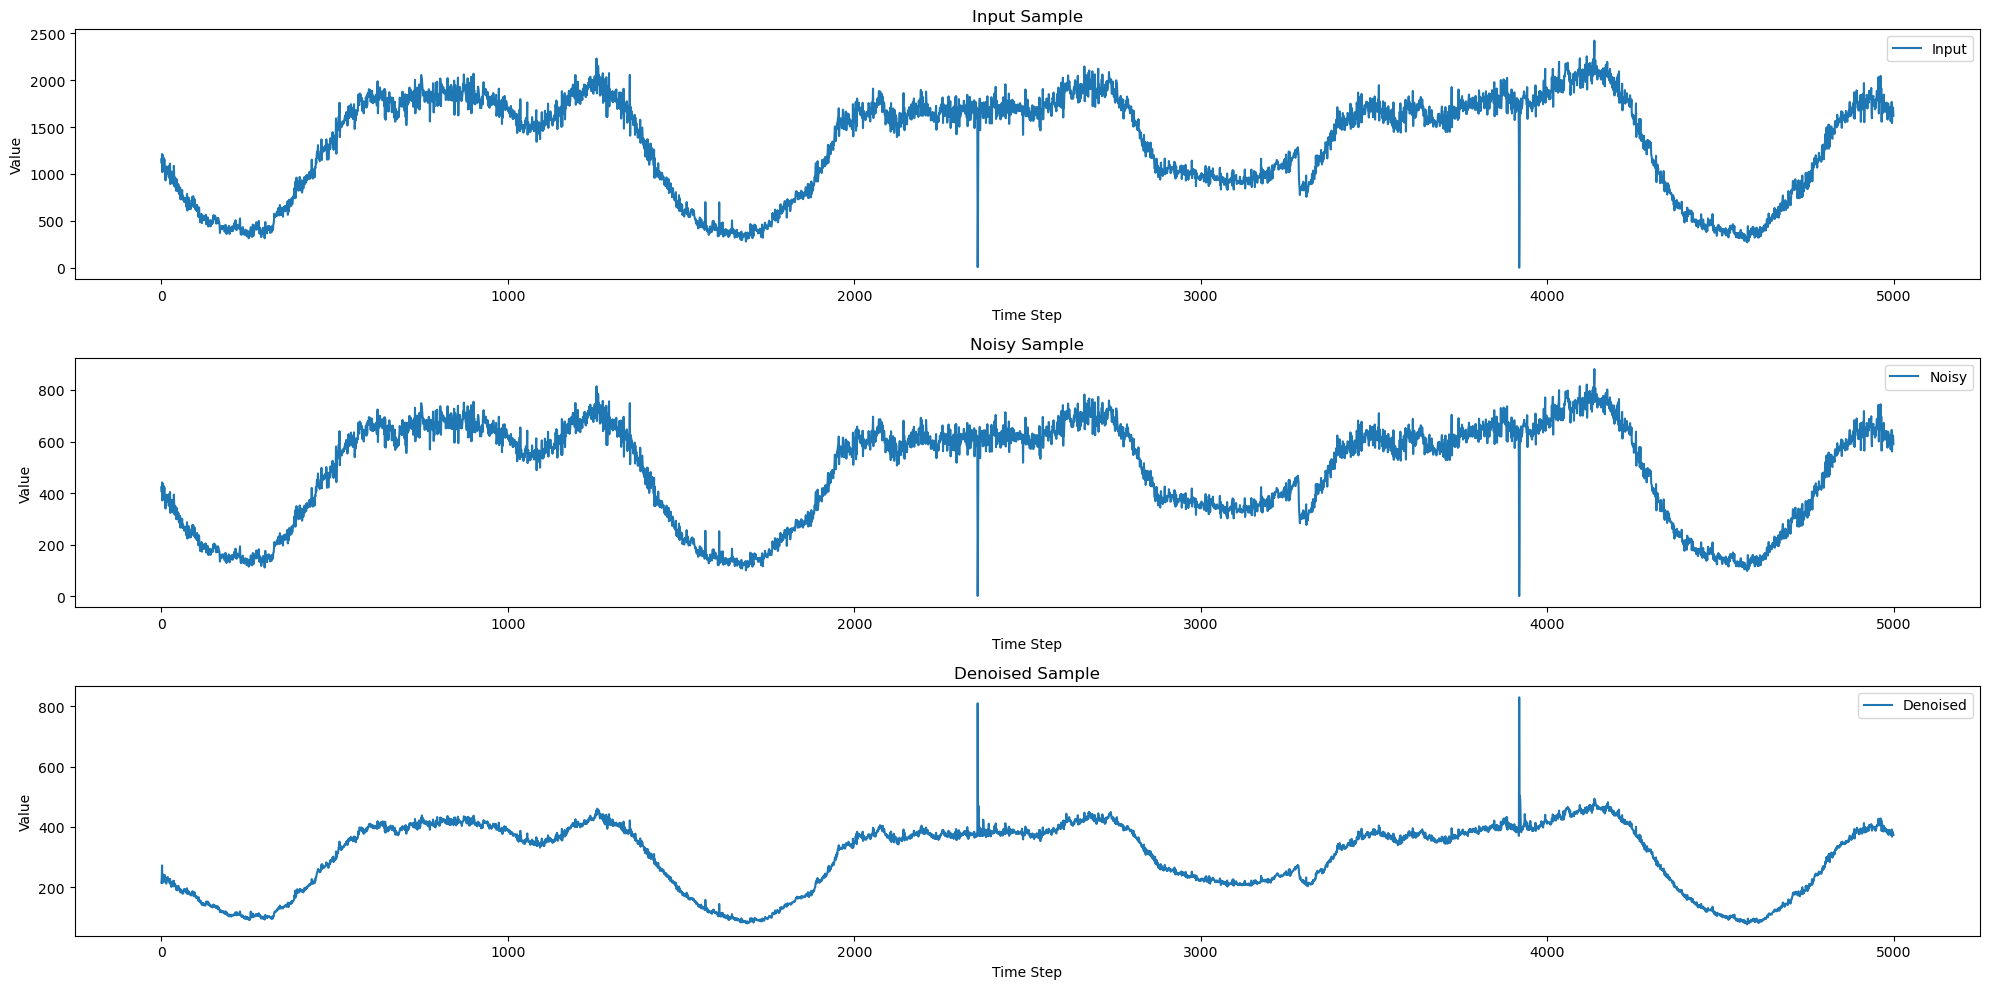

100%|██████████| 20/20 [01:37<00:00,  4.85s/it]


In [46]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

# Continue with the rest of your training loop...

sequence_length = 5000
input_size = 1  # Assuming 1D time series data


# Assuming you have the rest of your code defined already...

# Initialize the new TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[64, 128, 256, 512,256,128,64,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)


# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)
# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Set up dataset and dataloader for test data
test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

# Create dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

#================================================================================================


noise_scheduler = SimplexNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

for epoch in tqdm(range(config.num_epochs)):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(dataloader):

        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        # order timesteps 
        timesteps = timesteps.sort()[0]
        
        print('timesteps', timesteps)
        
        noise = noise_scheduler.generate_simplex_noise_like(batch)
        std_data = torch.std(batch)

        # I want the noise level increasing with epoch
        noise_level = 0.1 * (epoch+10)/5
        noise = torch.randn_like(batch) * std_data * noise_level
        
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        noisy = noisy.unsqueeze(-1) 
        
        # pred noise from the model
        noise_pred = model(noisy)
        
        print("noise_pred", noise_pred.shape)
        batch = batch.unsqueeze(-1)
        
        loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
   # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0 :
        model.eval()
        eval_batch_size = config.eval_batch_size

        for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
            
            # after sapling random noise, predict using the model to denoise the sample
            with torch.no_grad():
                timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
                print("eval timesteps", timesteps)
                
                std_data = torch.std(sample)
                noise_level = 0.1
                noise = torch.randn_like(sample) #* std_data * noise_level
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = noisy_sample.unsqueeze(-1)
                denoised_sample = model(noisy_sample)
                
                # Visualize the input the noisy and denoised data
                
                fig, axs = plt.subplots(3, 1, figsize=(20, 10))
                
                ax = axs[0]
                ax.plot(sample[0].cpu().numpy())
                ax.set_title("Input Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Input"])
                
                ax = axs[1]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title("Noisy Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Noisy"])
                
                ax = axs[2]
                ax.plot(denoised_sample[0].cpu().numpy())
                ax.set_title("Denoised Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Denoised"])
                
                plt.tight_layout()
                plt.show()
                
            break
            

        
    progress_bar.close()


  0%|          | 0/1 [00:00<?, ?it/s]

std_data tensor(527.8704)
eval timesteps tensor([849, 607,   0,   0, 488, 335, 642, 540,   5, 616, 345, 955, 469, 893,
        637, 547])


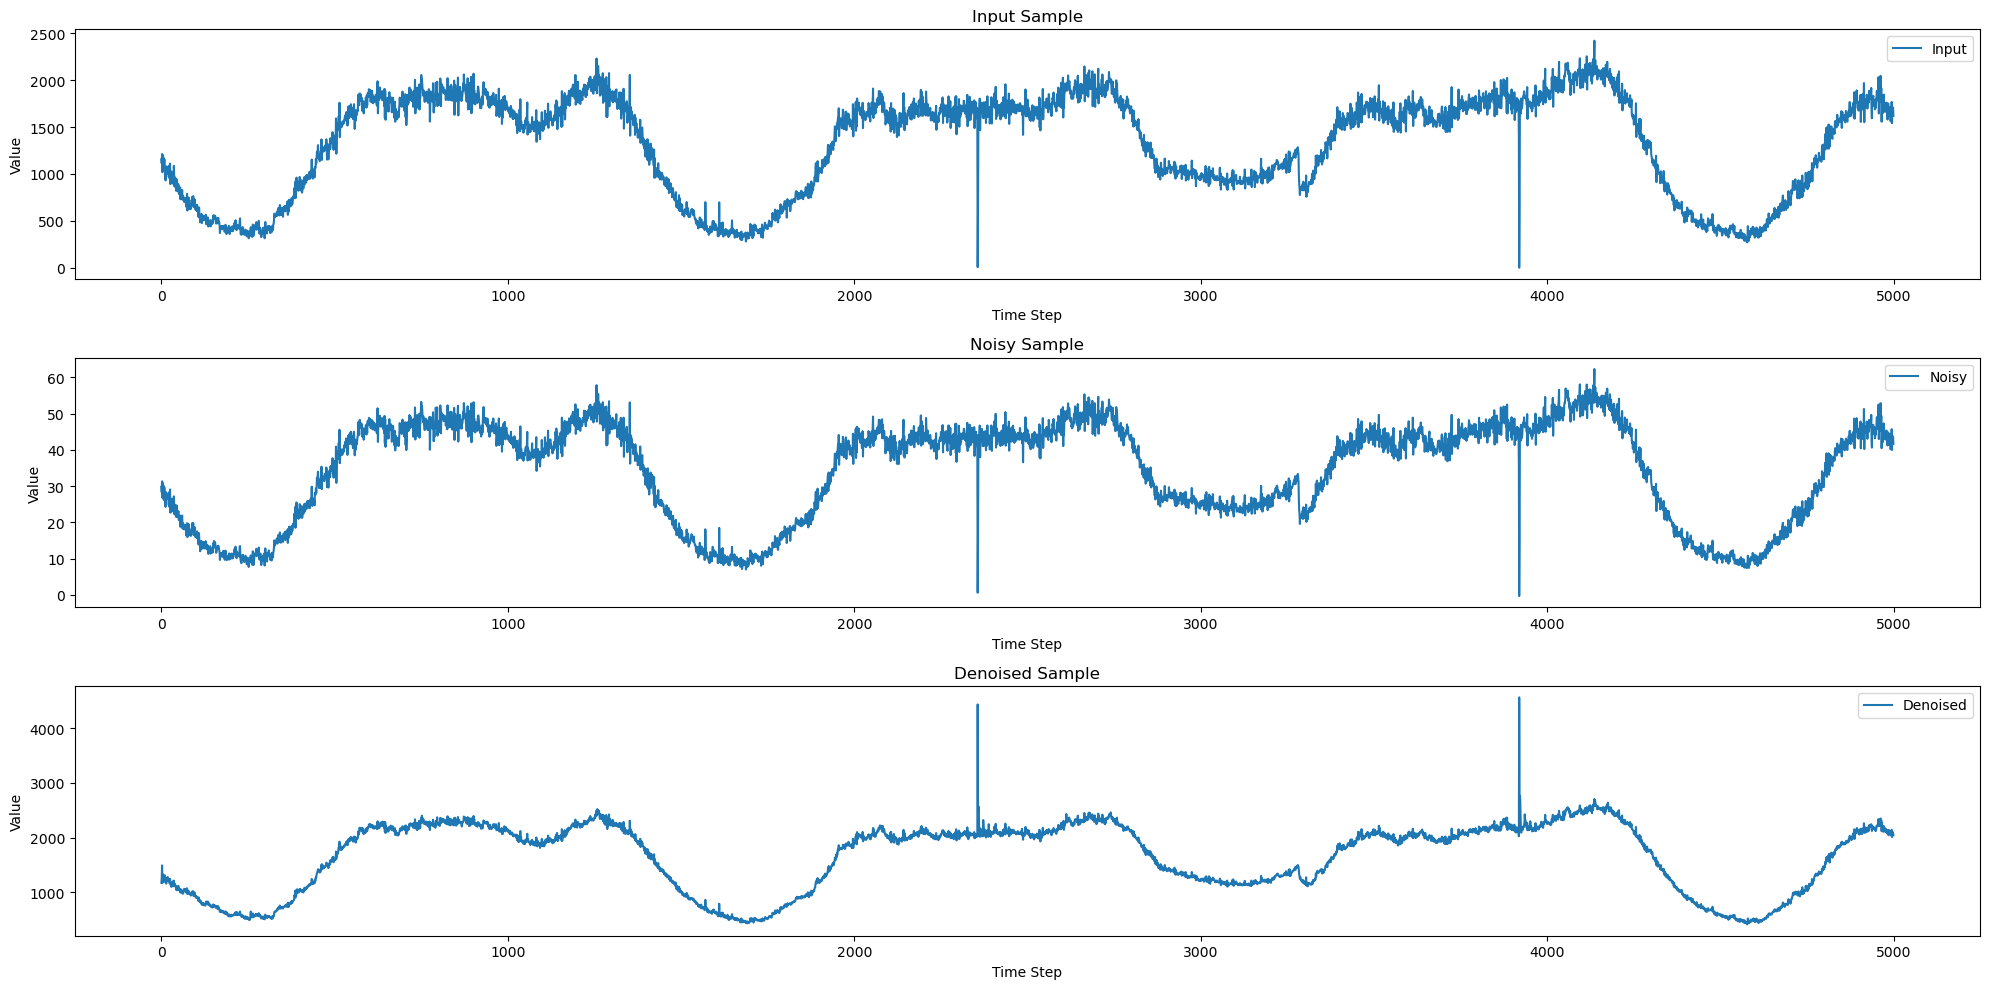

Outliers: [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]
labels tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


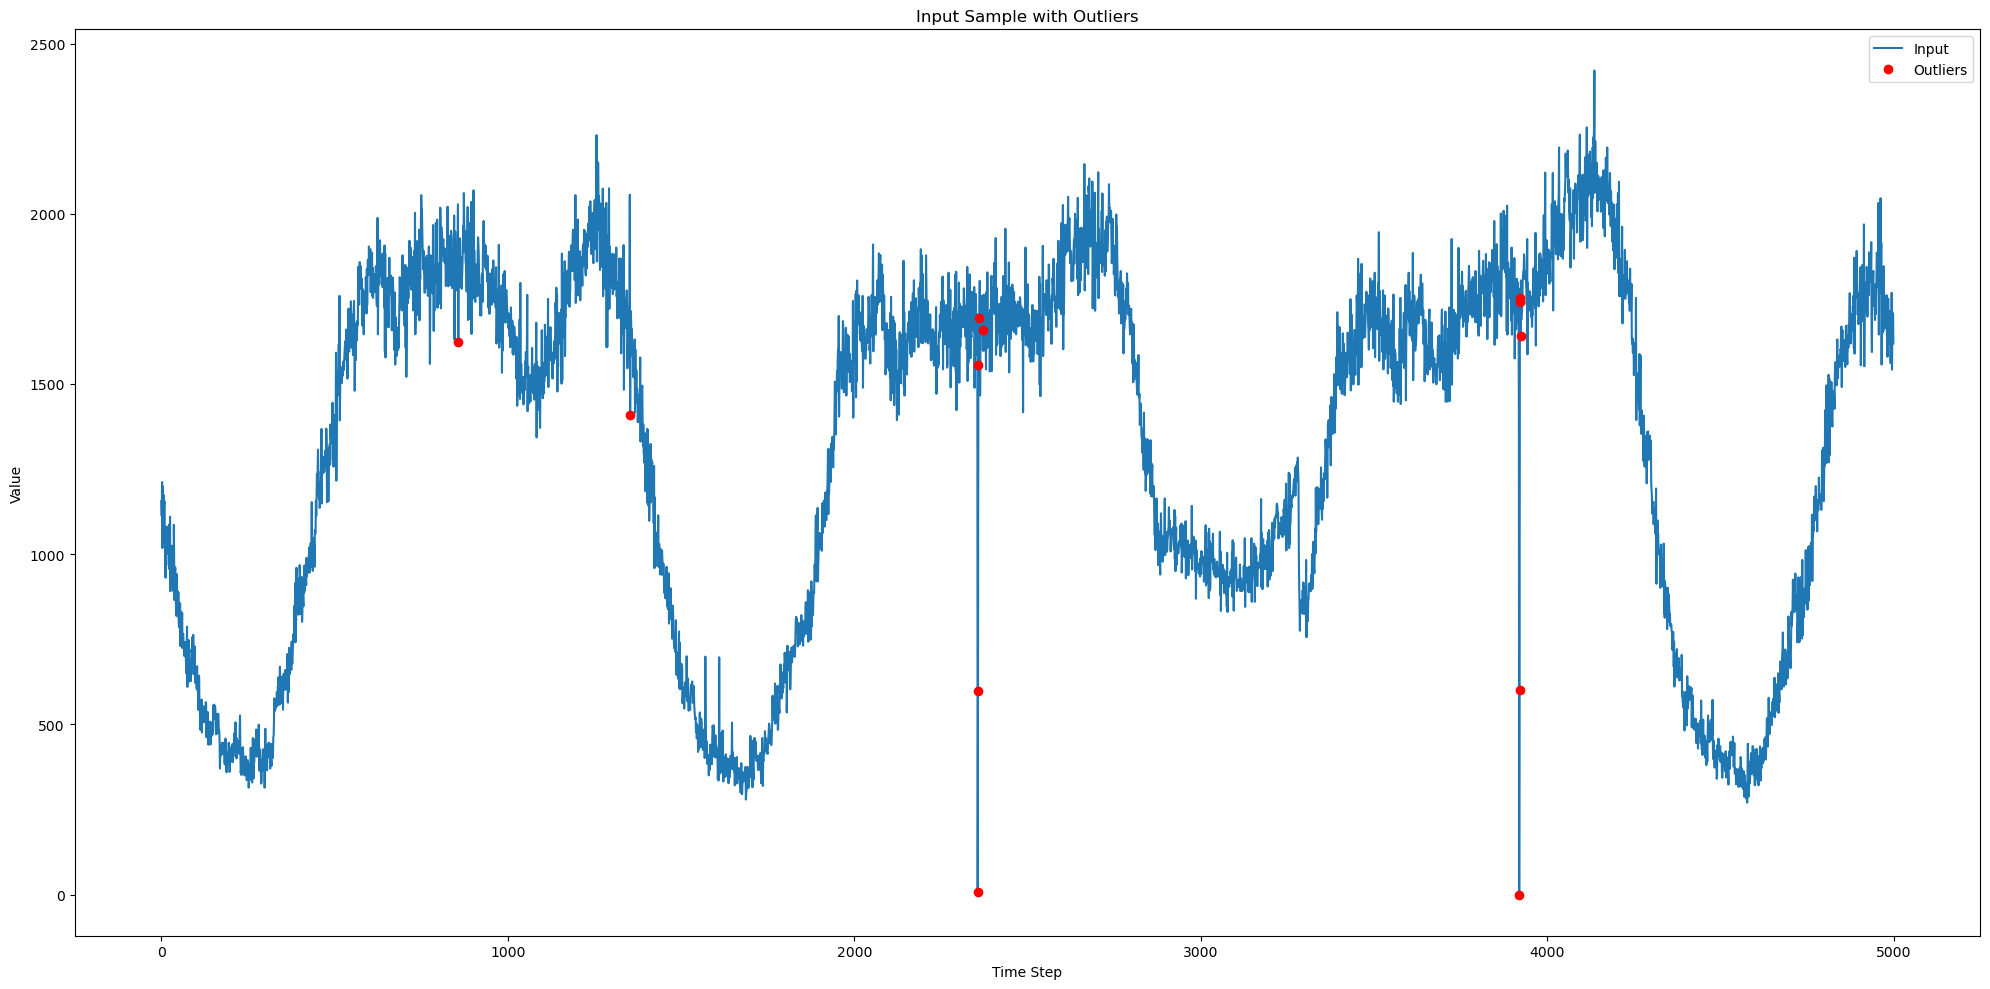

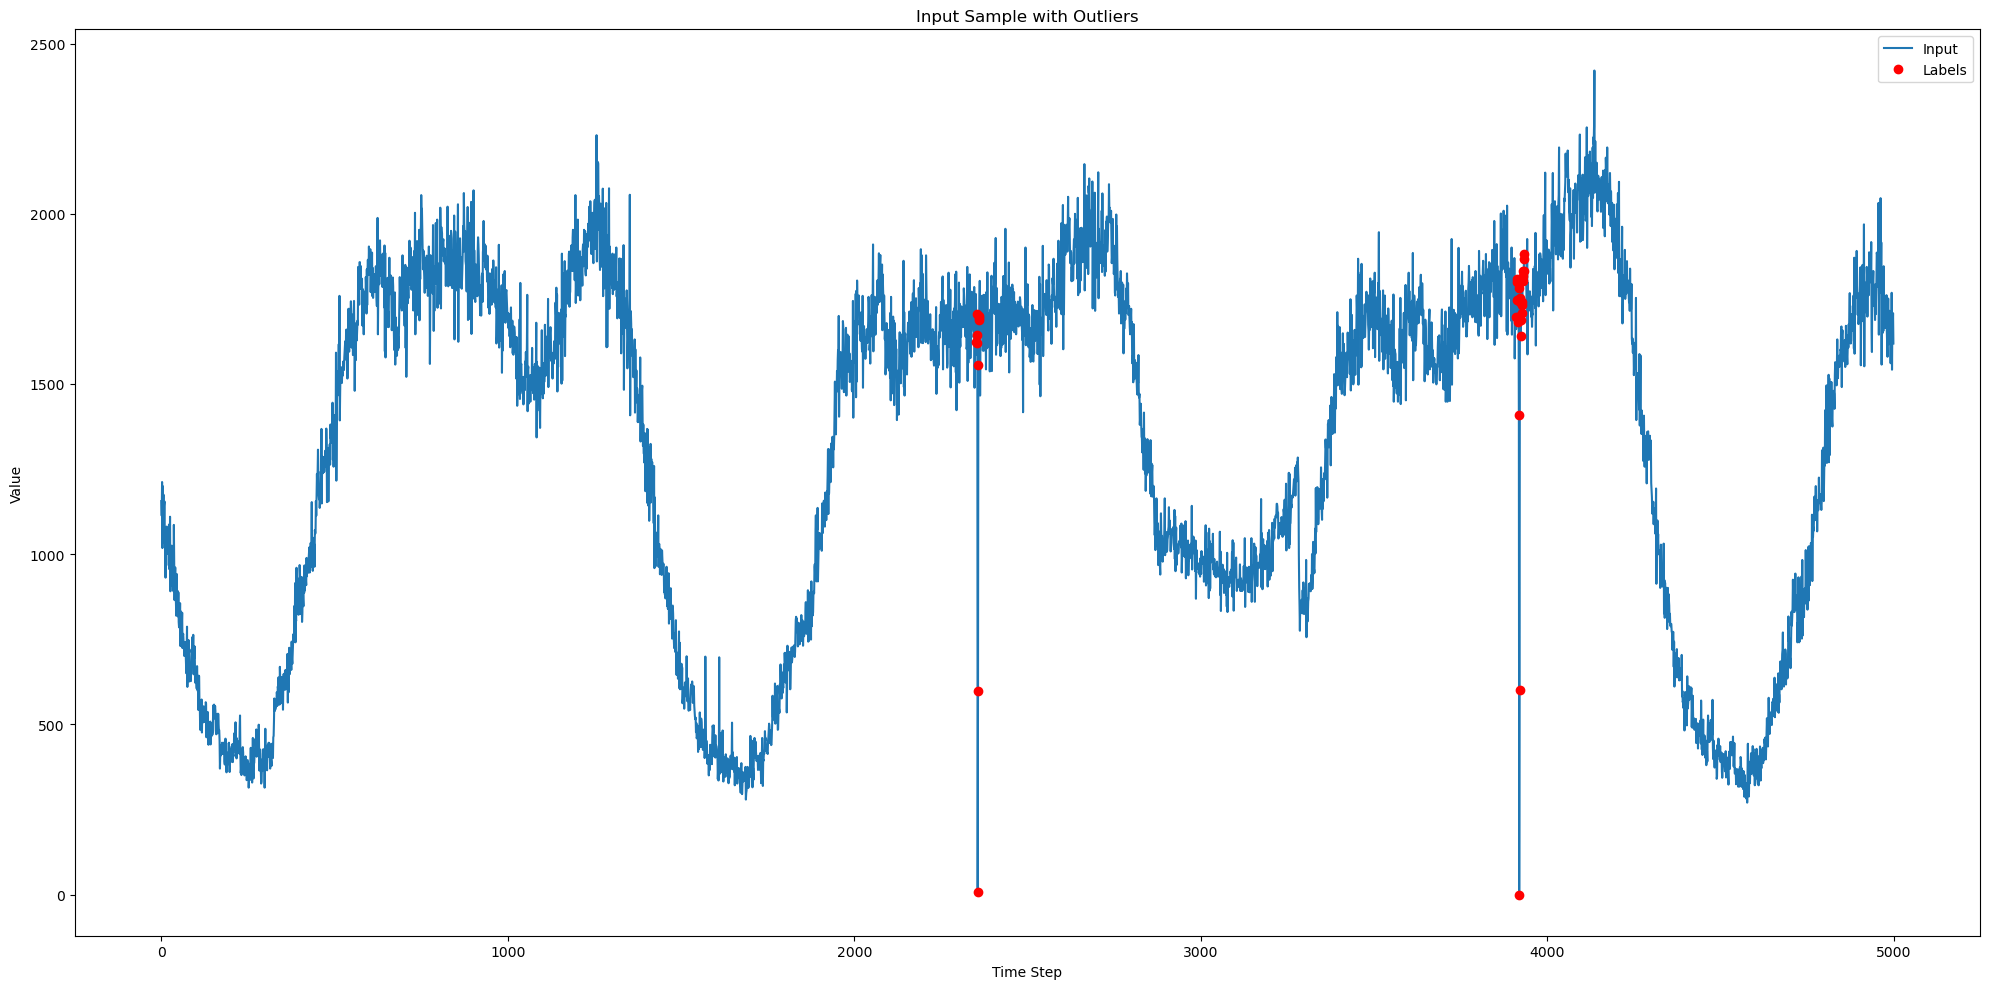

  0%|          | 0/1 [00:02<?, ?it/s]

Classification report


In [48]:
model.eval()
eval_batch_size = config.eval_batch_size

for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
    
    std_data = torch.std(sample)
    print("std_data", std_data)
    # after sapling random noise, predict using the model to denoise the sample
    with torch.no_grad():
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
        print("eval timesteps", timesteps)
    
        noise = noise_scheduler.generate_simplex_noise_like(sample)
        
        noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
        
        noisy_sample = noisy_sample.unsqueeze(-1)
        sample = sample.unsqueeze(-1)
        denoised_sample = model(sample) *2
        # Visualize the input the noisy and denoised data
        
        fig, axs = plt.subplots(3, 1, figsize=(20, 10))
        ax = axs[0]
        ax.plot(sample[0].cpu().numpy())
        ax.set_title("Input Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])
        
        ax = axs[1]
        ax.plot(noisy_sample[0].cpu().numpy())
        ax.set_title("Noisy Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Noisy"])
        
        ax = axs[2]
        ax.plot(denoised_sample[0].cpu().numpy())
        ax.set_title("Denoised Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Denoised"])
        
        plt.tight_layout()
        plt.show()
        
        # predict outlier points in the input sample by comparing the denoised sample with the input sample with a threshold
        threshold = std_data*1.2

        outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()

        # before the sample shape was (16, 5000) now it is (16,5000, 1)
        #outliers 
        print("Outliers:", outliers)
        print("labels", labels)
        
        labels = labels.cpu().numpy()
        
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        outlier_indices = np.where(outliers[0] == 1)[0]
        ax.plot(outlier_indices, sample[0][outlier_indices].cpu().numpy(), 'ro', label="Outliers")

        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
                
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        label_indices = np.where(labels[0] == True)[0]
        ax.plot(label_indices, sample[0][label_indices].cpu().numpy(), 'ro', label="Labels")
        
        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        # classification report of outliers vs labels focus on the True positive, True negative, False positive and False negative
        print("Classification report")
        
        
    break


## <font color='green'> Ajout incremental with epochs PyTorch TCN - prediction Image de base - gaussian noise + classifier guidance:</font> 

In [5]:
import torch
import torch.nn as nn
from pytorch_tcn import TCN

class TCNWithClassifier(nn.Module):
    def __init__(self, tcn_params, classifier_hidden_size=64):
        super(TCNWithClassifier, self).__init__()
        self.tcn = TCN(**tcn_params)
        self.classifier = nn.Sequential(
            nn.Linear(tcn_params['num_channels'][-1], classifier_hidden_size),
            nn.ReLU(),
            nn.Linear(classifier_hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        tcn_output = self.tcn(x)
        # Use the last time step for classification
        last_step = tcn_output[:, :, -1]  # Changed from tcn_output[:, -1, :]
        classification = self.classifier(last_step)
        return tcn_output, classification.squeeze()

# Assuming input_size and config are defined elsewhere in your code
input_size = 1  # Adjust this value if necessary

# TCN parameters
tcn_params = {
    "num_inputs": input_size,  # Number of input channels
    "num_channels": [64, 128, 256, 512, 256, 128, 64, 1],  # Number of channels in each residual block
    "kernel_size": 3,  # Size of the convolution kernel
    "dilations": None,  # Dilation sizes
    "dilation_reset": None,  # Reset dilation size
    "dropout": 0.2,  # Dropout rate
    "causal": True,  # Causal convolutions for real-time applications
    "use_norm": 'weight_norm',  # Normalization method
    "activation": 'relu',  # Activation function
    "kernel_initializer": 'xavier_uniform',  # Weight initializer
    "use_skip_connections": False,  # Skip connections
    "input_shape": 'NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    "embedding_shapes": None,  # Embedding shapes
    "embedding_mode": 'add',  # Embedding mode ('add' or 'concat')
    "use_gate": False,  # Use gated linear unit
    "lookahead": 0,  # Lookahead for future time steps
    "output_projection": None,  # Output projection
    "output_activation": None,  # Output activation
}

# Initialize the new model
model = TCNWithClassifier(tcn_params)

# Update optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

# Add classification loss
bce_loss = nn.BCELoss()

In [6]:
class TCNWithClassifier(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCNWithClassifier, self).__init__()
        self.tcn = TCN(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.fc = nn.Linear(num_channels[-1], output_size)
        self.classifier = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        # Ensure input is the correct shape (batch_size, sequence_length, input_size)
        if x.dim() == 2:
            x = x.unsqueeze(-1)
        
        # TCN expects input shape (batch_size, input_size, sequence_length)
        x = x.transpose(1, 2)
        
        features = self.tcn(x)
        # Use the last output for classification and denoising
        last_output = features[:, :, -1]
        denoised = self.fc(last_output).unsqueeze(1).repeat(1, x.shape[2], 1)
        classification = self.classifier(last_output).squeeze(-1)
        
        return denoised, classification
    
  # Initialize the model with correct parameters
input_size = 1  # Your input size
output_size = 1  # Your output size
num_channels = [64, 128, 256, 512, 256, 128, 64, 1]  # Adjust as needed
kernel_size = 3
dropout = 0.2

model = TCNWithClassifier(input_size, output_size, num_channels, kernel_size, dropout)
  

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_tcn import TCN

class TCNWithClassifier(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCNWithClassifier, self).__init__()
        self.tcn = TCN(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.fc = nn.Linear(num_channels[-1], output_size)
        self.classifier = nn.Sequential(
            nn.Linear(num_channels[-1], 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Ensure input is the correct shape (batch_size, sequence_length, input_size)
        if x.dim() == 2:
            x = x.unsqueeze(-1)
        
        # TCN expects input shape (batch_size, input_size, sequence_length)
        x = x.transpose(1, 2)
        
        features = self.tcn(x)
        # Use the last output for classification and denoising
        last_output = features[:, :, -1]
        denoised = self.fc(last_output).unsqueeze(1).repeat(1, x.shape[2], 1)
        classification = self.classifier(last_output).squeeze(-1)
        
        # Repeat classification output to match the sequence length
        classification = classification.unsqueeze(1).repeat(1, x.shape[2])
        
        return denoised, classification

# Initialize the model with correct parameters
input_size = 1  # Your input size
output_size = 1  # Your output size
num_channels = [64, 128, 256, 512, 256, 128, 64, 1]  # Adjust as needed
kernel_size = 3
dropout = 0.2

model = TCNWithClassifier(input_size, output_size, num_channels, kernel_size, dropout)

Training model...


Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, accuracy=0.00535, batch_size=16, classification_loss=0.498, denoising_loss=1.94e+6, loss=1.94e+6, step=9]

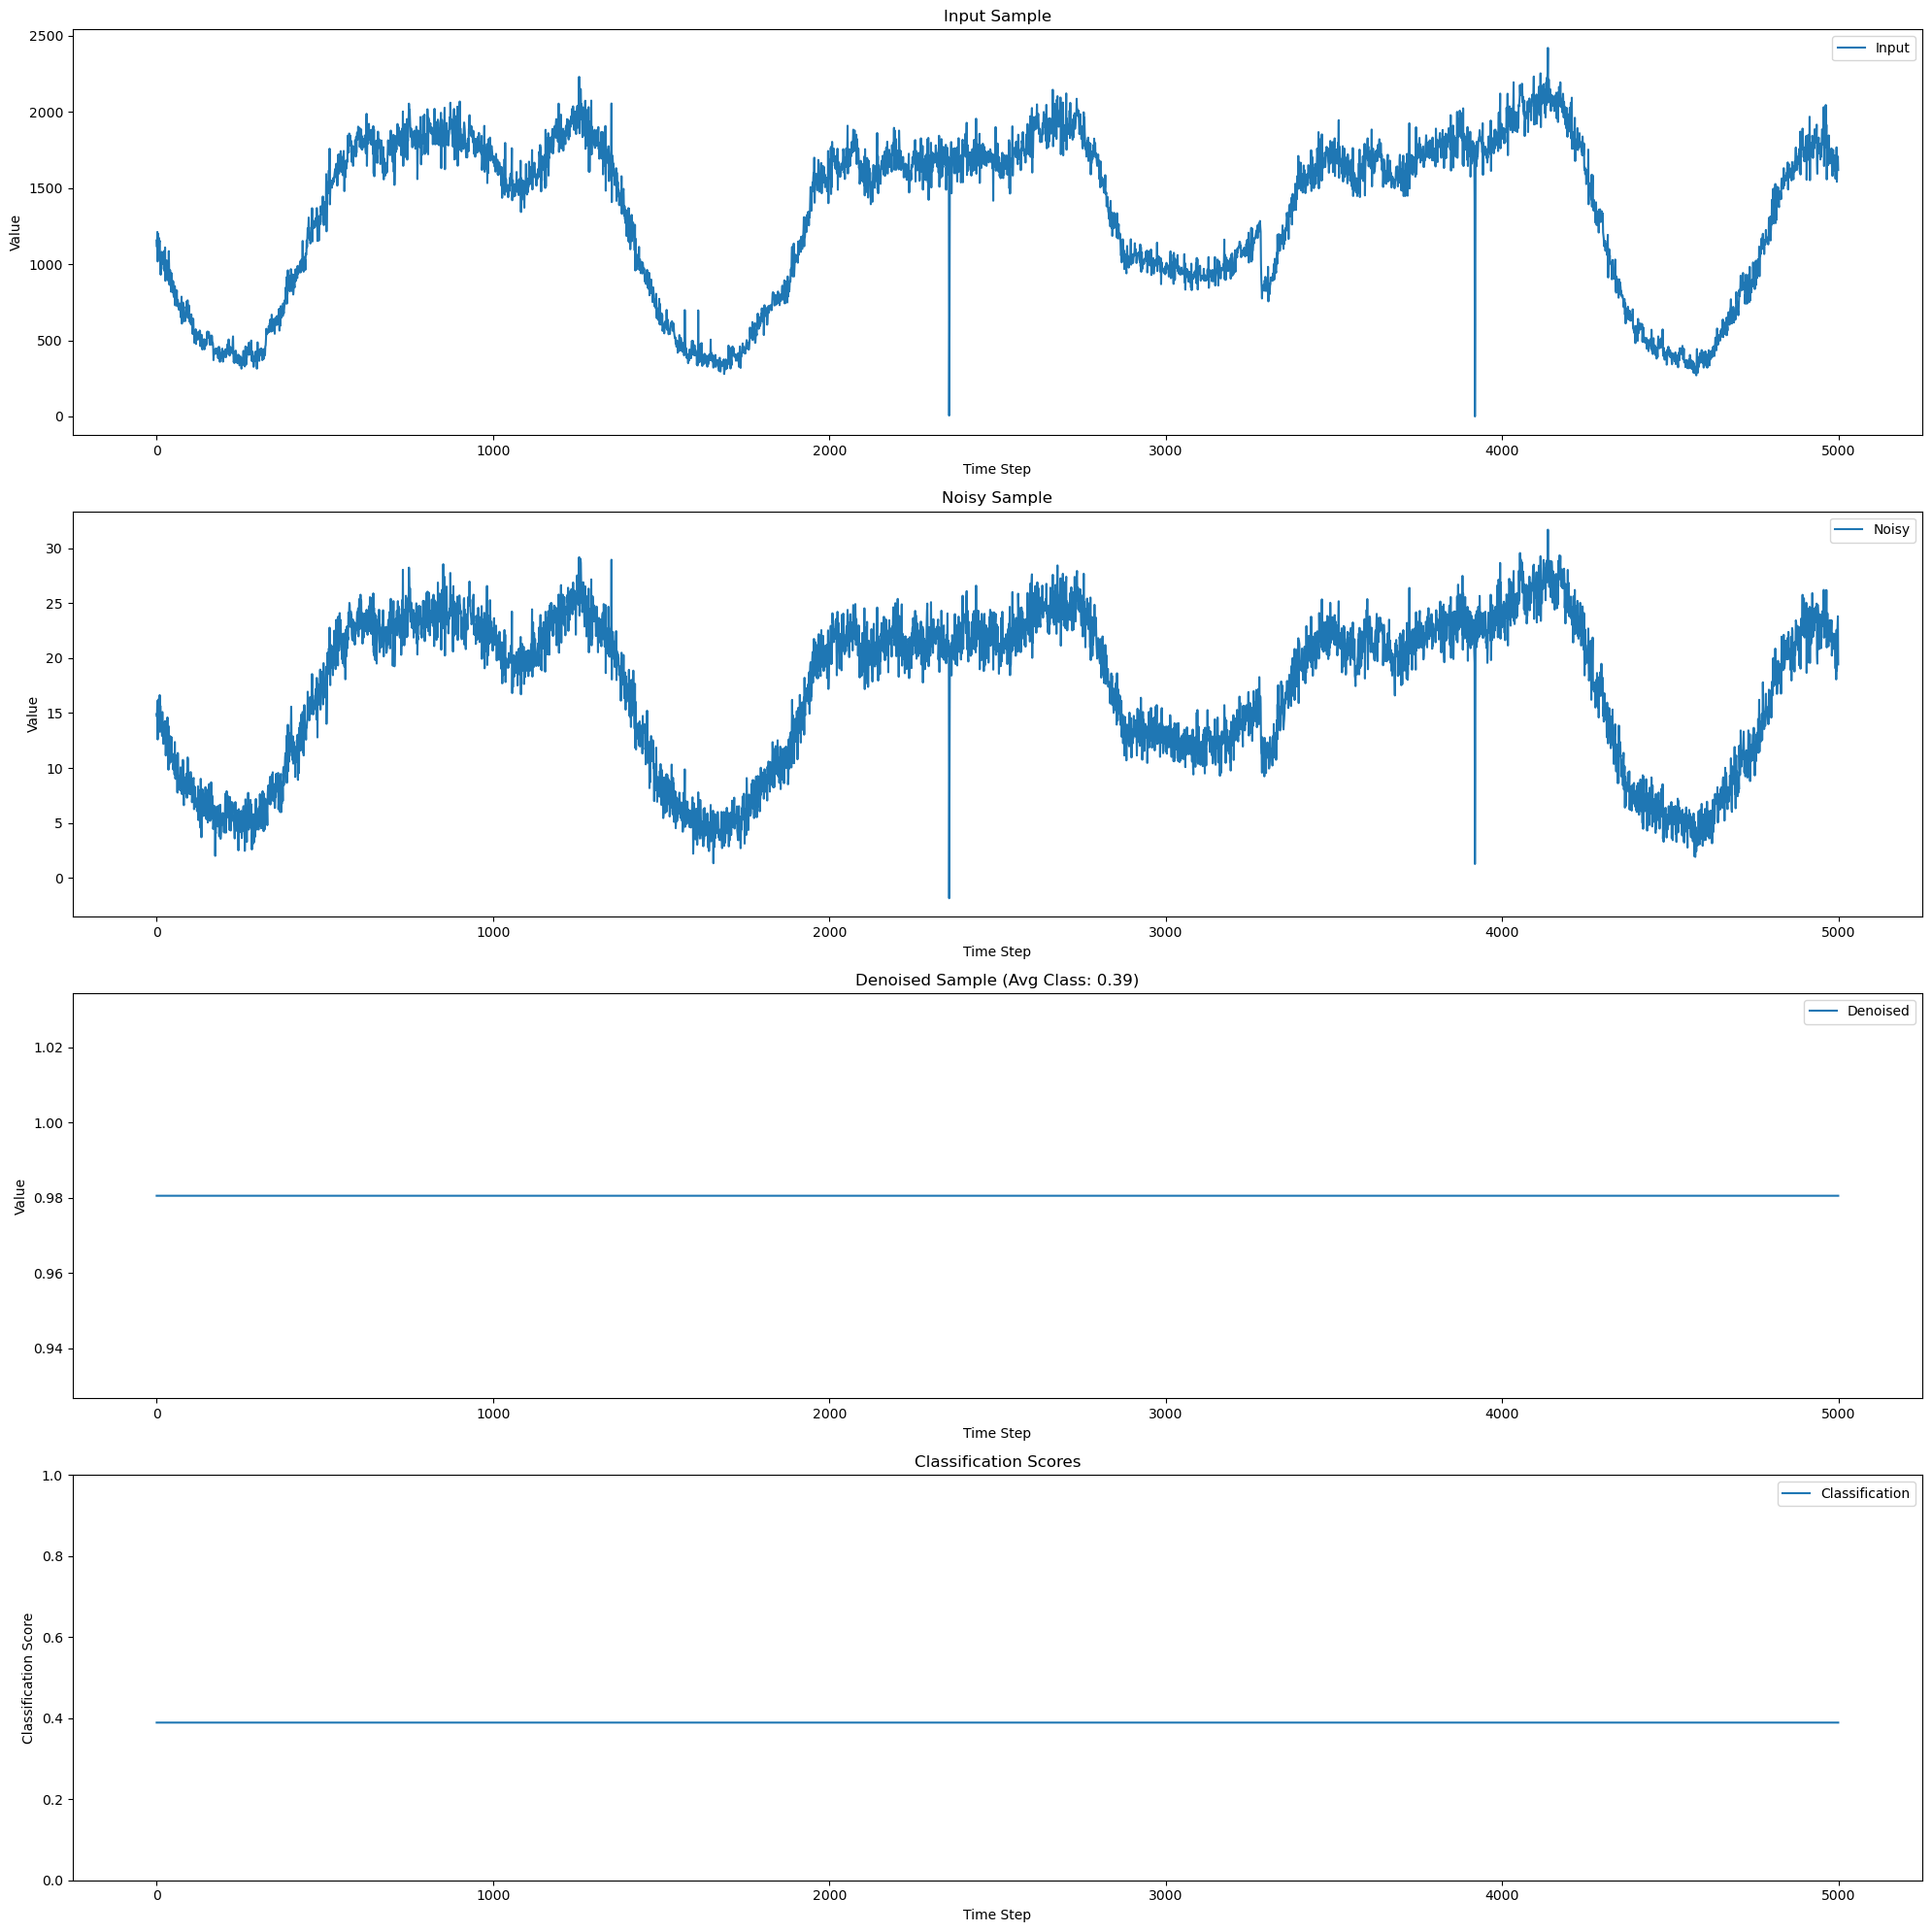

Epoch 9: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it, accuracy=0.00535, batch_size=16, classification_loss=0.498, denoising_loss=1.94e+6, loss=1.94e+6, step=9]


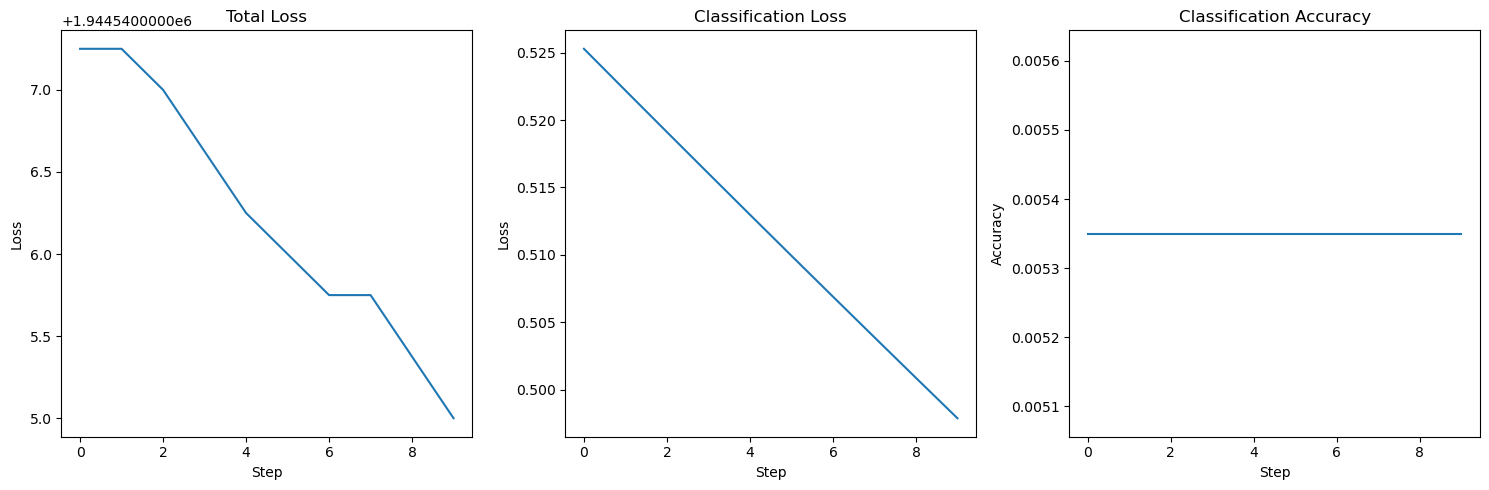

In [12]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

# Continue with the rest of your training loop...

sequence_length = 5000
input_size = 1  # Assuming 1D time series data

# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)
# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Set up dataset and dataloader for test data
test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

# Create dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Assuming the TCNWithClassifier model and other necessary components are defined as before

# the training loop
global_step = 0
frames = []
losses = []
classification_losses = []
accuracies = []

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, timestamps, labels) in enumerate(dataloader):
        # Calculate initial noise level
        initial_noise_level = 0.1 * (epoch + 10) / 5
        initial_noise = torch.randn_like(batch) * torch.std(batch) * initial_noise_level
        
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (batch.size(0),)).long()
        
        # Apply initial noise
        noisy = noise_scheduler.add_noise(batch, initial_noise, timesteps)
        
        # Apply additional noise after add_noise function
        additional_noise_level = 0.05  # Adjust this value as needed
        additional_noise = torch.randn_like(noisy) * torch.std(noisy) * additional_noise_level
        noisy = noisy + additional_noise
        
        # Forward pass
        denoised, classification = model(noisy)
        
        # reshaape the batch
        batch = batch.unsqueeze(-1)
        
        #print("denoised", denoised.shape)
        #print("batch", batch.shape)
        
        #print("classification", classification.shape)
        #print("labels", labels.shape)
        
        # Calculate losses
        denoising_loss = F.mse_loss(denoised, batch)
        classification_loss = F.binary_cross_entropy(classification, labels.float())
        
        # Combine losses
        loss = denoising_loss + classification_loss
        
        # Backward pass and optimization
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        # Calculate accuracy
        predicted_labels = (torch.sigmoid(classification) > 0.5).float()
        accuracy = (predicted_labels == labels.float()).float().mean()

        # Logging
        progress_bar.update(1)
        logs = {
            "loss": loss.detach().item(),
            "denoising_loss": denoising_loss.detach().item(),
            "classification_loss": classification_loss.detach().item(),
            "accuracy": accuracy.item(),
            "step": global_step,
            "batch_size": batch.size(0)
        }
        losses.append(loss.detach().item())
        classification_losses.append(classification_loss.detach().item())
        accuracies.append(accuracy.item())
        progress_bar.set_postfix(**logs)
        global_step += 1
        
    # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0:
        model.eval()
        eval_batch_size = config.eval_batch_size

        for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
            with torch.no_grad():
                timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
                
                noise = torch.randn_like(sample)
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                sample = sample.unsqueeze(-1)
                noisy_sample = noisy_sample.unsqueeze(-1)
                
                denoised_sample, classification = model(sample)
                
                # Calculate average classification score
                avg_classification = classification[0].mean().item()
                
                # Visualize the input, noisy, and denoised data
                fig, axs = plt.subplots(4, 1, figsize=(20, 20))
                
                axs[0].plot(sample[0].cpu().numpy())
                axs[0].set_title("Input Sample")
                axs[0].set_xlabel("Time Step")
                axs[0].set_ylabel("Value")
                axs[0].legend(["Input"])
                
                axs[1].plot(noisy_sample[0].cpu().numpy())
                axs[1].set_title("Noisy Sample")
                axs[1].set_xlabel("Time Step")
                axs[1].set_ylabel("Value")
                axs[1].legend(["Noisy"])
                
                axs[2].plot(denoised_sample[0].cpu().numpy())
                axs[2].set_title(f"Denoised Sample (Avg Class: {avg_classification:.2f})")
                axs[2].set_xlabel("Time Step")
                axs[2].set_ylabel("Value")
                axs[2].legend(["Denoised"])
                
                # Plot classification scores
                axs[3].plot(classification[0].cpu().numpy())
                axs[3].set_title("Classification Scores")
                axs[3].set_xlabel("Time Step")
                axs[3].set_ylabel("Classification Score")
                axs[3].set_ylim(0, 1)
                axs[3].legend(["Classification"])
                
                plt.tight_layout()
                plt.show()
                
            break
            
    progress_bar.close()

# Plot training metrics
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.title("Total Loss")
plt.xlabel("Step")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(classification_losses)
plt.title("Classification Loss")
plt.xlabel("Step")
plt.ylabel("Loss")

plt.subplot(1, 3, 3)
plt.plot(accuracies)
plt.title("Classification Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()



In [ ]:
model.eval()
eval_batch_size = config.eval_batch_size

for step, (sample, timestamps, labels) in enumerate(tqdm(test_dataloader)):
    
    # after sapling random noise, predict using the model to denoise the sample
    with torch.no_grad():
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
        print("eval timesteps", timesteps)
    
        std_data = torch.std(sample)
        noise_level = 0.5
        noise = torch.randn_like(sample) * std_data * noise_level
        noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
        
        noisy_sample = noisy_sample.unsqueeze(-1)
        sample = sample.unsqueeze(-1)
        denoised_sample = model(sample) *2
        # Visualize the input the noisy and denoised data
        
        fig, axs = plt.subplots(3, 1, figsize=(20, 10))
        ax = axs[0]
        ax.plot(sample[0].cpu().numpy())
        ax.set_title("Input Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])
        
        ax = axs[1]
        ax.plot(noisy_sample[0].cpu().numpy())
        ax.set_title("Noisy Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Noisy"])
        
        ax = axs[2]
        ax.plot(denoised_sample[0].cpu().numpy())
        ax.set_title("Denoised Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Denoised"])
        
        plt.tight_layout()
        plt.show()
        
        # predict outlier points in the input sample by comparing the denoised sample with the input sample with a threshold
        threshold = std_data

        outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()

        # before the sample shape was (16, 5000) now it is (16,5000, 1)
        #outliers 
        print("Outliers:", outliers)
        print("labels", labels)
        
        labels = labels.cpu().numpy()
        
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        outlier_indices = np.where(outliers[0] == 1)[0]
        ax.plot(outlier_indices, sample[0][outlier_indices].cpu().numpy(), 'ro', label="Outliers")

        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
                
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        label_indices = np.where(labels[0] == True)[0]
        ax.plot(label_indices, sample[0][label_indices].cpu().numpy(), 'ro', label="Labels")
        
        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        # classification report of outliers vs labels focus on the True positive, True negative, False positive and False negative
        print("Classification report")

        
        
    break
